In [7]:
import tensorflow as tf
from __future__ import print_function
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(1, 784)


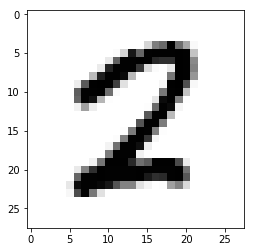

In [2]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')


In [3]:
def discriminator(images, reuse=False):
    with tf.variable_scope("discriminator") as scope:
        if (reuse):
            scope.reuse_variables()

        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # d4 contains unscaled values
        return d4

In [4]:
def generator(z, batch_size, z_dim):
    with tf.variable_scope("generator") as scope:
        g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g1 = tf.matmul(z, g_w1) + g_b1
        g1 = tf.reshape(g1, [-1, 56, 56, 1])
        g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
        g1 = tf.nn.relu(g1)

        # Generate 50 features
        g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
        g2 = g2 + g_b2
        g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
        g2 = tf.nn.relu(g2)
        g2 = tf.image.resize_images(g2, [56, 56])

        # Generate 25 features
        g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
        g3 = g3 + g_b3
        g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
        g3 = tf.nn.relu(g3)
        g3 = tf.image.resize_images(g3, [56, 56])

        # Final convolution with one output channel
        g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
        g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
        g4 = g4 + g_b4
        g4 = tf.sigmoid(g4)

        # Dimensions of g4: batch_size x 28 x 28 x 1
        return g4

In [5]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [6]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

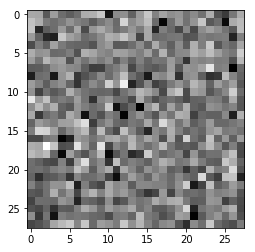

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

In [9]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse=True)

In [10]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [11]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

[u'discriminator/d_w1:0', u'discriminator/d_b1:0', u'discriminator/d_w2:0', u'discriminator/d_b2:0', u'discriminator/d_w3:0', u'discriminator/d_b3:0', u'discriminator/d_w4:0', u'discriminator/d_b4:0']
[u'generator/g_w1:0', u'generator/g_b1:0', u'generator/g_w2:0', u'generator/g_b2:0', u'generator/g_w3:0', u'generator/g_b3:0', u'generator/g_w4:0', u'generator/g_b4:0']


In [12]:
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [13]:
tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

## Added scope change 
tf.get_variable_scope().reuse_variables()
images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard-log/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

In [19]:
import scipy.misc


'20170703-003139.png'

dLossReal: 0.694382 dLossFake: 0.691896
dLossReal: 0.0177325 dLossFake: 0.0188684
dLossReal: 0.00163274 dLossFake: 0.00184839
Iteration: 0 at 2017-07-03 00:33:31.471232


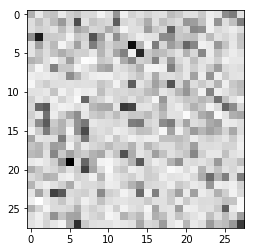

Estimate: [[-7.49586725]]
Iteration: 100 at 2017-07-03 00:33:38.365446


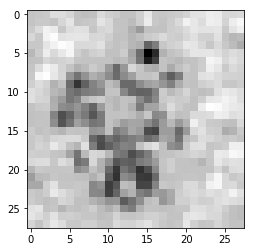

Estimate: [[-7.68996429]]
Iteration: 200 at 2017-07-03 00:33:45.332501


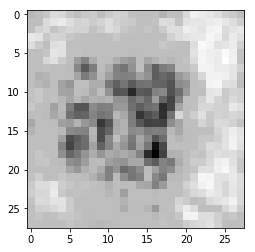

Estimate: [[-8.64249325]]
Iteration: 300 at 2017-07-03 00:33:52.287616


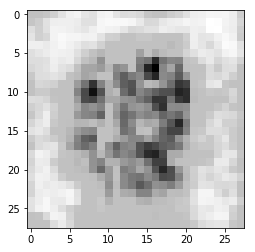

Estimate: [[-15.2149725]]
Iteration: 400 at 2017-07-03 00:33:59.337946


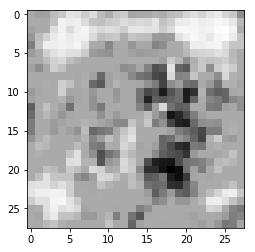

Estimate: [[-13.80705738]]
Iteration: 500 at 2017-07-03 00:34:06.575238


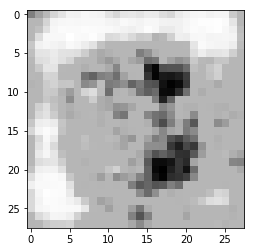

Estimate: [[-11.89813328]]
Iteration: 600 at 2017-07-03 00:34:13.566306


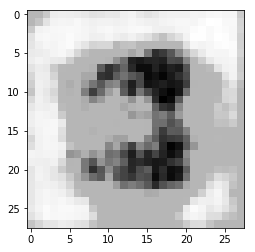

Estimate: [[-12.07500267]]
Iteration: 700 at 2017-07-03 00:34:20.565405


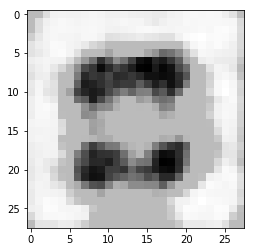

Estimate: [[-10.06629181]]
Iteration: 800 at 2017-07-03 00:34:27.554994


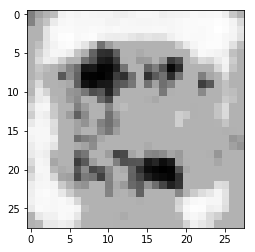

Estimate: [[-11.04881382]]
Iteration: 900 at 2017-07-03 00:34:34.521454


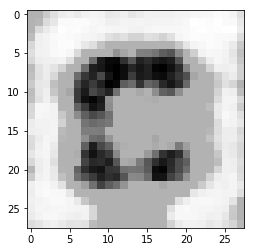

Estimate: [[-9.66176128]]
Iteration: 1000 at 2017-07-03 00:34:41.514545


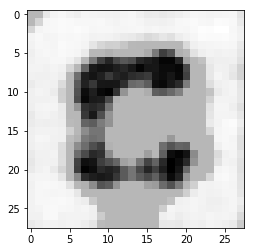

Estimate: [[-9.8332243]]
Iteration: 1100 at 2017-07-03 00:34:48.480097


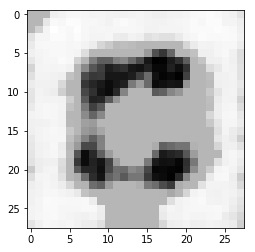

Estimate: [[-9.70532799]]
Iteration: 1200 at 2017-07-03 00:34:55.321421


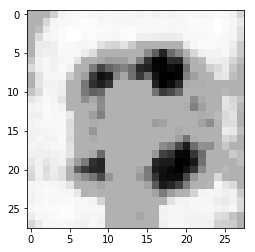

Estimate: [[-8.43055344]]
Iteration: 1300 at 2017-07-03 00:35:02.181152


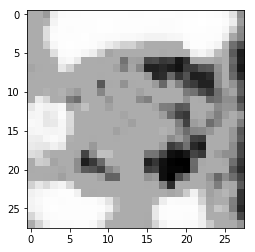

Estimate: [[-5.62835693]]
Iteration: 1400 at 2017-07-03 00:35:09.078453


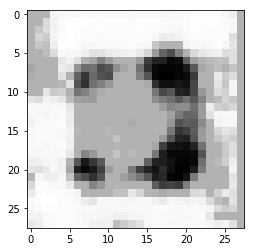

Estimate: [[-6.40634298]]
Iteration: 1500 at 2017-07-03 00:35:16.013234


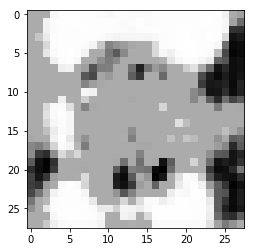

Estimate: [[-6.78606558]]
Iteration: 1600 at 2017-07-03 00:35:22.874732


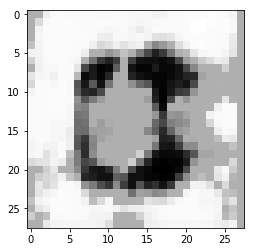

Estimate: [[-7.26545429]]
Iteration: 1700 at 2017-07-03 00:35:29.699628


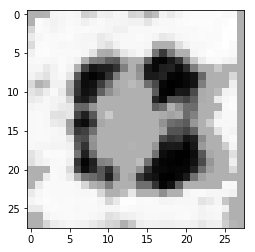

Estimate: [[-6.8458066]]
Iteration: 1800 at 2017-07-03 00:35:36.525399


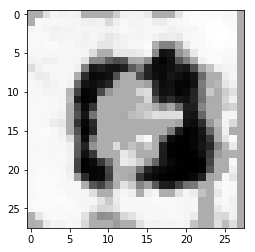

Estimate: [[-8.03643703]]
Iteration: 1900 at 2017-07-03 00:35:43.432547


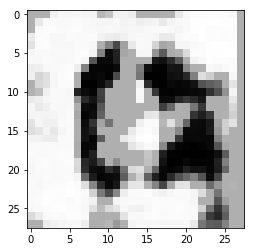

Estimate: [[-7.53758717]]
Iteration: 2000 at 2017-07-03 00:35:50.288961


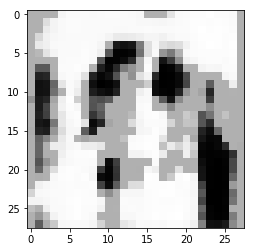

Estimate: [[-6.29451418]]
Iteration: 2100 at 2017-07-03 00:35:57.147450


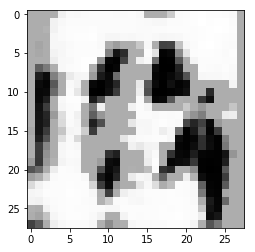

Estimate: [[-6.16146564]]
Iteration: 2200 at 2017-07-03 00:36:04.050501


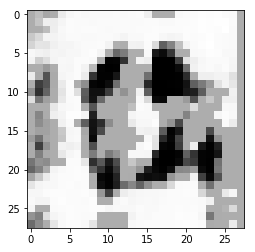

Estimate: [[-6.35451174]]
Iteration: 2300 at 2017-07-03 00:36:11.277945


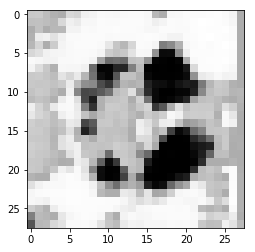

Estimate: [[-21.40505791]]
Iteration: 2400 at 2017-07-03 00:36:18.195504


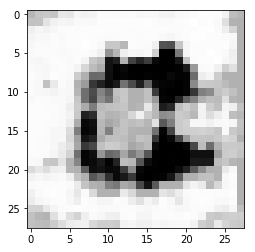

Estimate: [[ 2.4393177]]
Iteration: 2500 at 2017-07-03 00:36:25.109601


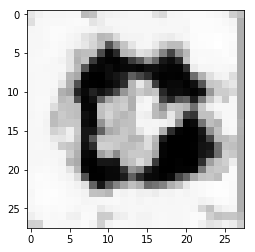

Estimate: [[-5.07809496]]
Iteration: 2600 at 2017-07-03 00:36:32.062653


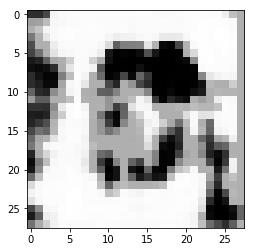

Estimate: [[-6.18101072]]
Iteration: 2700 at 2017-07-03 00:36:38.993775


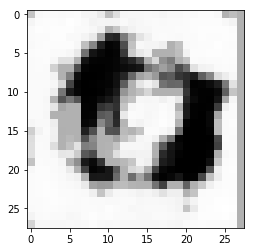

Estimate: [[-4.42963839]]
Iteration: 2800 at 2017-07-03 00:36:45.913961


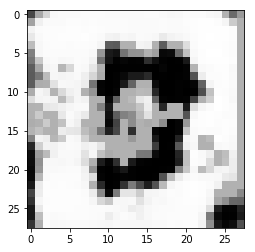

Estimate: [[-5.89176226]]
Iteration: 2900 at 2017-07-03 00:36:52.820024


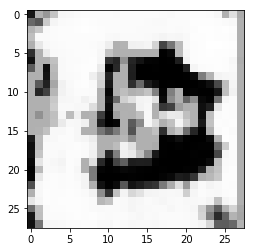

Estimate: [[-7.97152805]]
Iteration: 3000 at 2017-07-03 00:36:59.744071


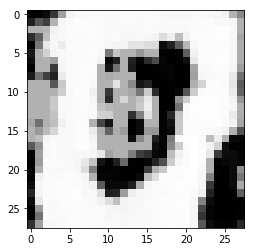

Estimate: [[-20.90492439]]
Iteration: 3100 at 2017-07-03 00:37:06.622492


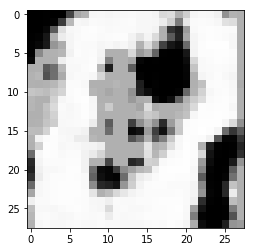

Estimate: [[-7.6451869]]
Iteration: 3200 at 2017-07-03 00:37:13.591016


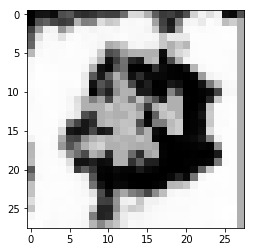

Estimate: [[-4.93245935]]
Iteration: 3300 at 2017-07-03 00:37:20.530396


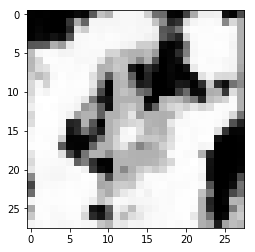

Estimate: [[-10.17063427]]
Iteration: 3400 at 2017-07-03 00:37:27.438470


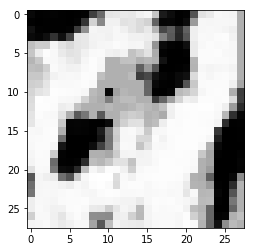

Estimate: [[-11.93711185]]
Iteration: 3500 at 2017-07-03 00:37:34.385114


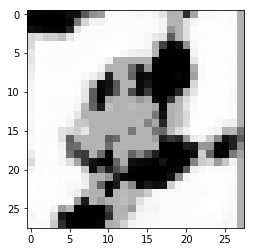

Estimate: [[-7.8376689]]
Iteration: 3600 at 2017-07-03 00:37:41.320705


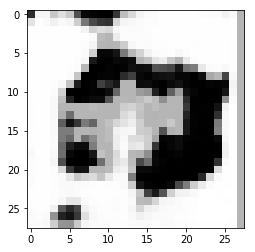

Estimate: [[-3.72341847]]
Iteration: 3700 at 2017-07-03 00:37:48.337885


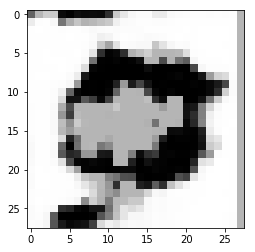

Estimate: [[-5.12686253]]
Iteration: 3800 at 2017-07-03 00:37:55.260543


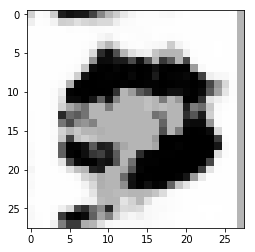

Estimate: [[-5.15433216]]
Iteration: 3900 at 2017-07-03 00:38:02.195569


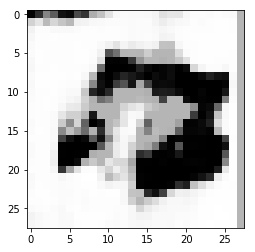

Estimate: [[-3.9222362]]
Iteration: 4000 at 2017-07-03 00:38:09.130986


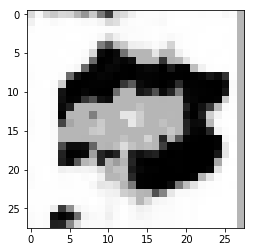

Estimate: [[-3.97565007]]
Iteration: 4100 at 2017-07-03 00:38:16.106912


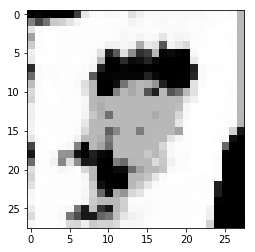

Estimate: [[-8.20436001]]
Iteration: 4200 at 2017-07-03 00:38:23.006871


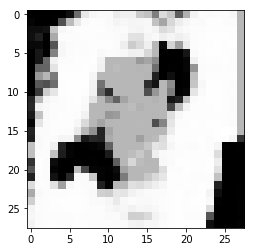

Estimate: [[-5.23379087]]
Iteration: 4300 at 2017-07-03 00:38:30.296314


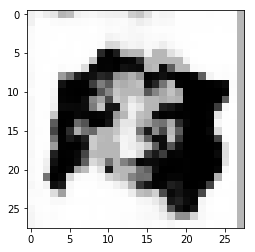

Estimate: [[-4.7936635]]
Iteration: 4400 at 2017-07-03 00:38:37.287431


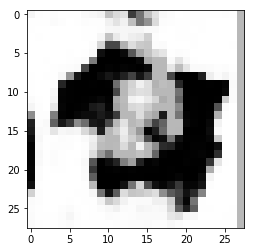

Estimate: [[-2.73446584]]
Iteration: 4500 at 2017-07-03 00:38:44.324640


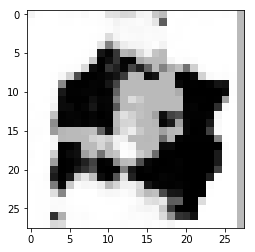

Estimate: [[-3.95937014]]
Iteration: 4600 at 2017-07-03 00:38:51.303478


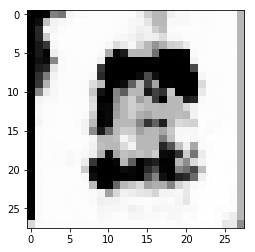

Estimate: [[-35.77287292]]
Iteration: 4700 at 2017-07-03 00:38:58.267037


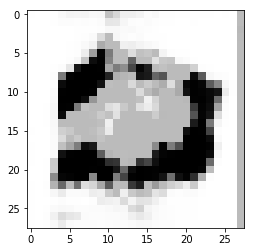

Estimate: [[-7.49405718]]
Iteration: 4800 at 2017-07-03 00:39:05.297203


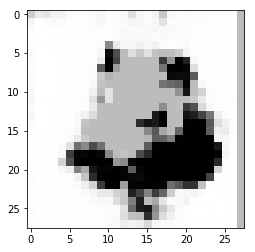

Estimate: [[-8.38108158]]
Iteration: 4900 at 2017-07-03 00:39:12.339753


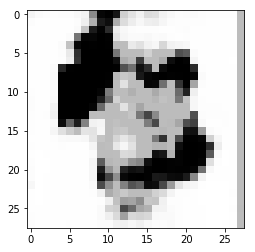

Estimate: [[-5.19010687]]
Iteration: 5000 at 2017-07-03 00:39:19.301199


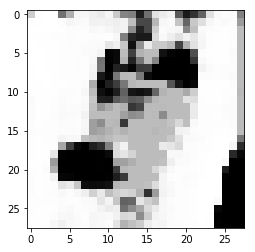

Estimate: [[-13.74720764]]
Iteration: 5100 at 2017-07-03 00:39:26.306111


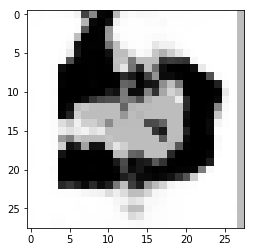

Estimate: [[-5.57902145]]
Iteration: 5200 at 2017-07-03 00:39:33.257024


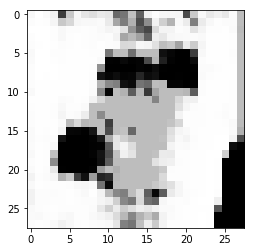

Estimate: [[-13.82155228]]
Iteration: 5300 at 2017-07-03 00:39:40.237277


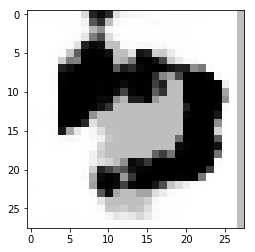

Estimate: [[-6.14082336]]
Iteration: 5400 at 2017-07-03 00:39:47.244267


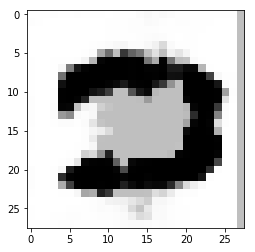

Estimate: [[-7.138659]]
Iteration: 5500 at 2017-07-03 00:39:54.243987


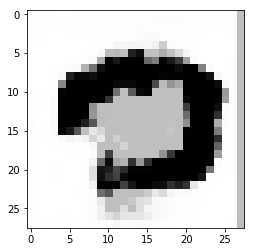

Estimate: [[-0.71355605]]
Iteration: 5600 at 2017-07-03 00:40:01.284755


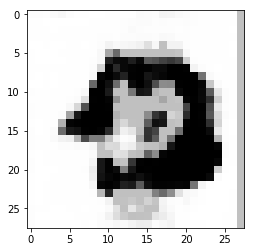

Estimate: [[-4.4531846]]
Iteration: 5700 at 2017-07-03 00:40:08.365415


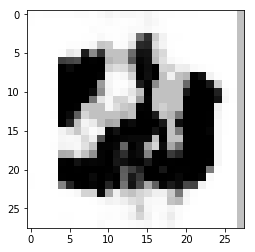

Estimate: [[-9.36369801]]
Iteration: 5800 at 2017-07-03 00:40:15.439921


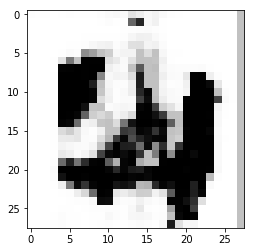

Estimate: [[-2.99915457]]
Iteration: 5900 at 2017-07-03 00:40:22.571884


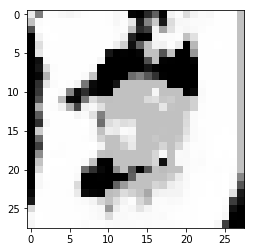

Estimate: [[-17.97145653]]
Iteration: 6000 at 2017-07-03 00:40:29.629693


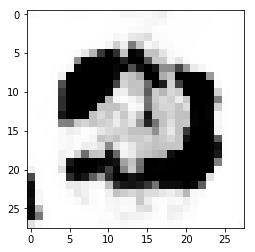

Estimate: [[-3.44202018]]
Iteration: 6100 at 2017-07-03 00:40:36.685134


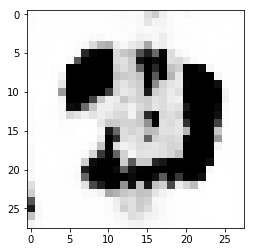

Estimate: [[-3.96344113]]
Iteration: 6200 at 2017-07-03 00:40:43.698865


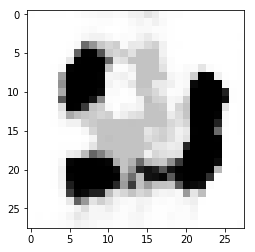

Estimate: [[ 1.94609785]]
Iteration: 6300 at 2017-07-03 00:40:50.688711


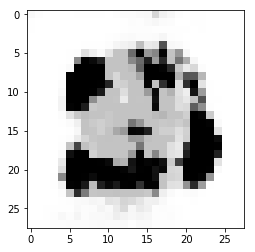

Estimate: [[-3.68980265]]
Iteration: 6400 at 2017-07-03 00:40:57.741329


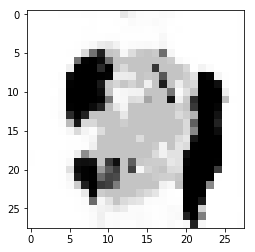

Estimate: [[-7.02054024]]
Iteration: 6500 at 2017-07-03 00:41:04.751715


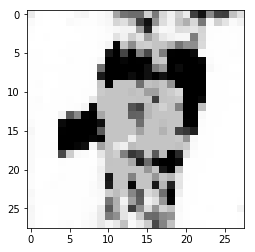

Estimate: [[-10.3804369]]
Iteration: 6600 at 2017-07-03 00:41:11.811058


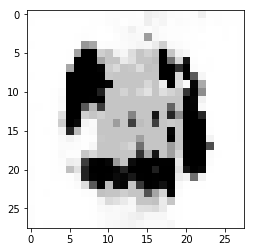

Estimate: [[-6.70891285]]
Iteration: 6700 at 2017-07-03 00:41:19.291768


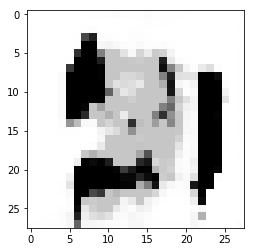

Estimate: [[ 0.31296092]]
Iteration: 6800 at 2017-07-03 00:41:26.420366


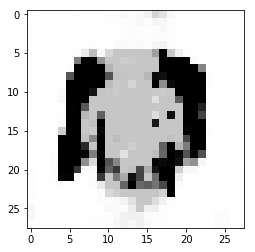

Estimate: [[-15.09699345]]
Iteration: 6900 at 2017-07-03 00:41:33.515341


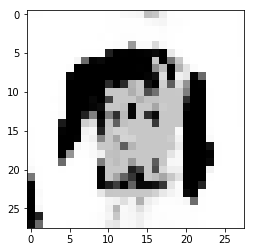

Estimate: [[-3.38114619]]
Iteration: 7000 at 2017-07-03 00:41:40.686782


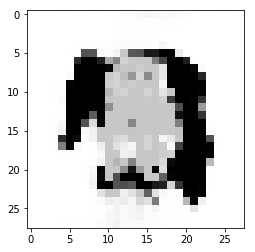

Estimate: [[-15.95405102]]
Iteration: 7100 at 2017-07-03 00:41:47.790029


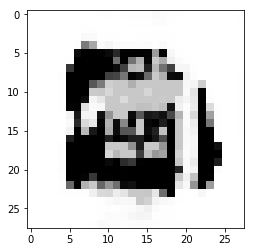

Estimate: [[-13.0952034]]
Iteration: 7200 at 2017-07-03 00:41:54.888302


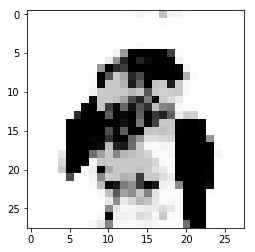

Estimate: [[-18.52745438]]
Iteration: 7300 at 2017-07-03 00:42:01.998753


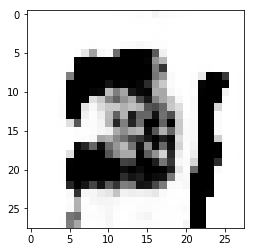

Estimate: [[-5.40239906]]
Iteration: 7400 at 2017-07-03 00:42:09.120696


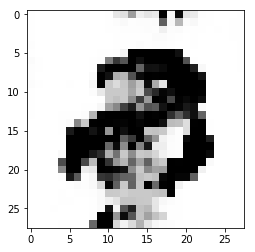

Estimate: [[-6.60335207]]
Iteration: 7500 at 2017-07-03 00:42:16.199694


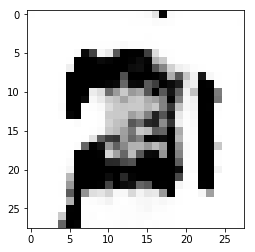

Estimate: [[-23.87264061]]
Iteration: 7600 at 2017-07-03 00:42:23.335997


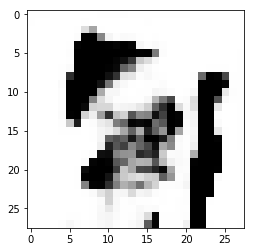

Estimate: [[-12.7206707]]
Iteration: 7700 at 2017-07-03 00:42:30.420341


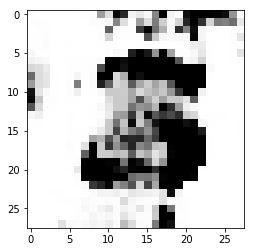

Estimate: [[-37.36425018]]
Iteration: 7800 at 2017-07-03 00:42:37.514333


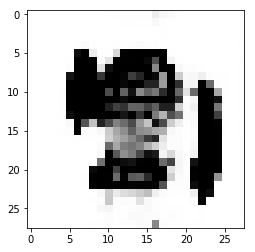

Estimate: [[-6.70338774]]
Iteration: 7900 at 2017-07-03 00:42:44.633840


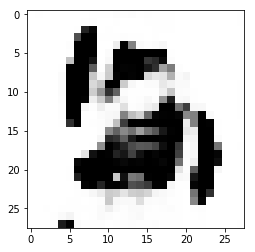

Estimate: [[-7.81653786]]
Iteration: 8000 at 2017-07-03 00:42:51.806281


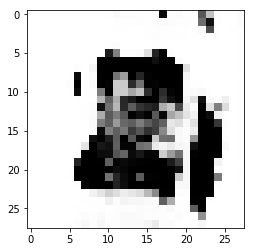

Estimate: [[-14.84369087]]
Iteration: 8100 at 2017-07-03 00:42:59.009507


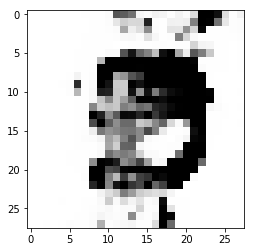

Estimate: [[-30.18253136]]
Iteration: 8200 at 2017-07-03 00:43:06.117930


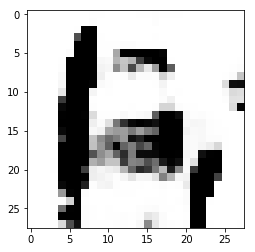

Estimate: [[-7.45559931]]
Iteration: 8300 at 2017-07-03 00:43:13.247915


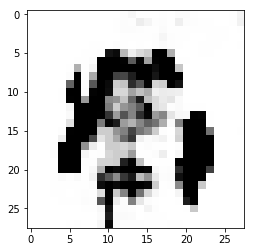

Estimate: [[-35.45737076]]
Iteration: 8400 at 2017-07-03 00:43:20.381402


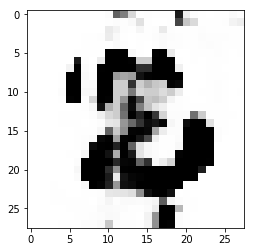

Estimate: [[-10.56200218]]
Iteration: 8500 at 2017-07-03 00:43:27.533934


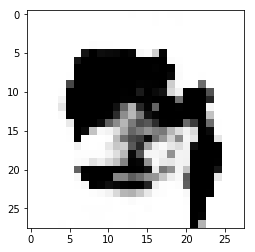

Estimate: [[-9.08228874]]
Iteration: 8600 at 2017-07-03 00:43:34.716062


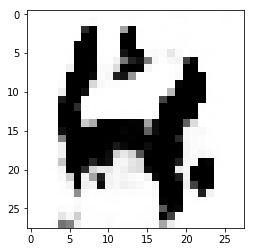

Estimate: [[-1.64923823]]
Iteration: 8700 at 2017-07-03 00:43:41.831232


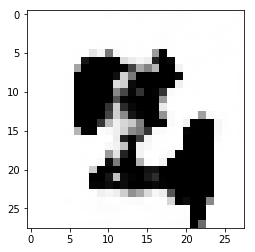

Estimate: [[-15.57895756]]
Iteration: 8800 at 2017-07-03 00:43:49.000987


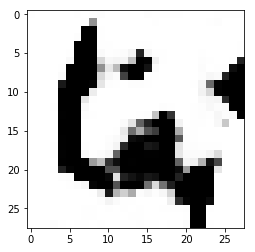

Estimate: [[-11.72212696]]
Iteration: 8900 at 2017-07-03 00:43:56.115710


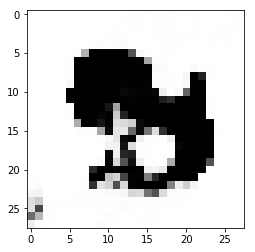

Estimate: [[-18.81098938]]
Iteration: 9000 at 2017-07-03 00:44:03.238058


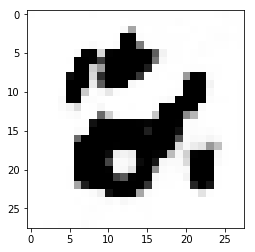

Estimate: [[-6.1530509]]
Iteration: 9100 at 2017-07-03 00:44:10.464233


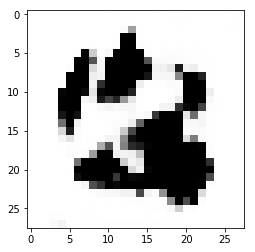

Estimate: [[-25.11702156]]
Iteration: 9200 at 2017-07-03 00:44:17.755430


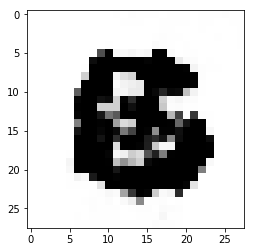

Estimate: [[-12.03830719]]
Iteration: 9300 at 2017-07-03 00:44:25.402730


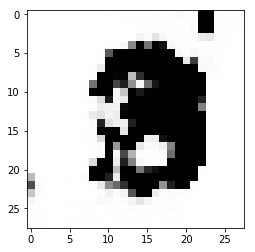

Estimate: [[-12.7300148]]
Iteration: 9400 at 2017-07-03 00:44:32.611042


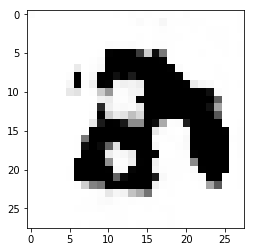

Estimate: [[-2.40805316]]
Iteration: 9500 at 2017-07-03 00:44:39.851037


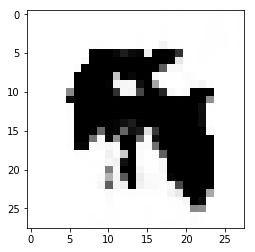

Estimate: [[ 7.54143]]
Iteration: 9600 at 2017-07-03 00:44:47.087913


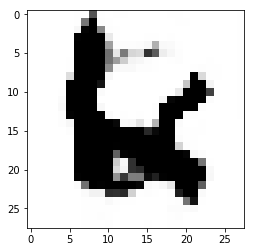

Estimate: [[ 2.34448481]]
Iteration: 9700 at 2017-07-03 00:44:54.305948


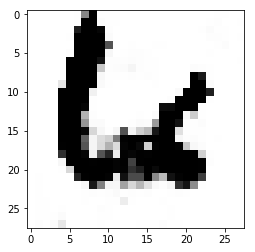

Estimate: [[-25.28995895]]
Iteration: 9800 at 2017-07-03 00:45:01.526169


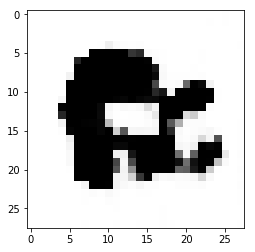

Estimate: [[-7.43211699]]
Iteration: 9900 at 2017-07-03 00:45:08.725577


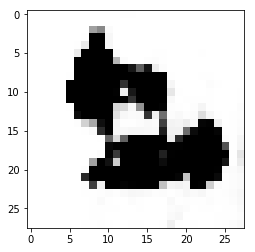

Estimate: [[-3.69422078]]
Iteration: 10000 at 2017-07-03 00:45:15.941125


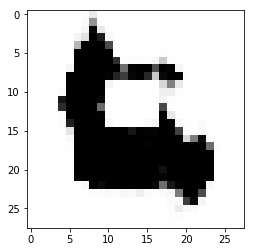

Estimate: [[-0.46818116]]
Iteration: 10100 at 2017-07-03 00:45:23.195888


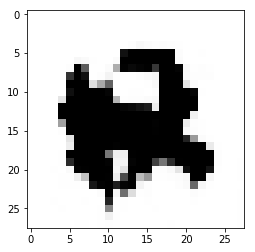

Estimate: [[-8.82505703]]
Iteration: 10200 at 2017-07-03 00:45:30.464491


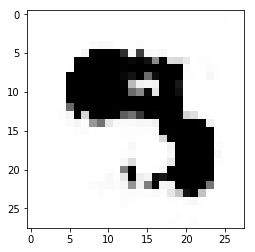

Estimate: [[ 2.37996769]]
Iteration: 10300 at 2017-07-03 00:45:37.820342


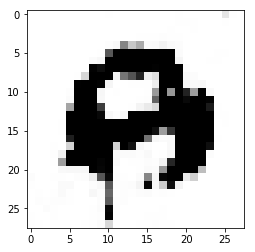

Estimate: [[-8.02212811]]
Iteration: 10400 at 2017-07-03 00:45:45.077235


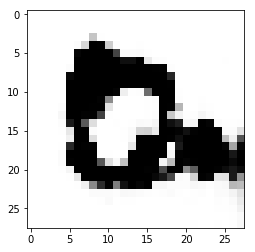

Estimate: [[-9.04839611]]
Iteration: 10500 at 2017-07-03 00:45:52.382382


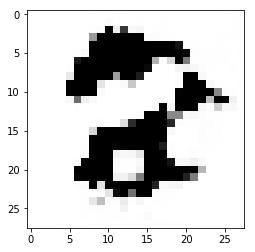

Estimate: [[ 4.63563871]]
Iteration: 10600 at 2017-07-03 00:45:59.641830


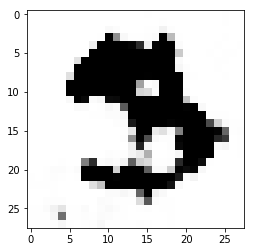

Estimate: [[-12.35071278]]
Iteration: 10700 at 2017-07-03 00:46:06.914429


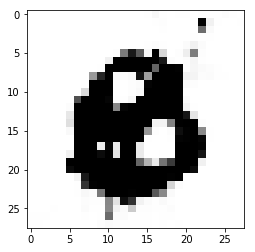

Estimate: [[-6.6750021]]
Iteration: 10800 at 2017-07-03 00:46:14.233627


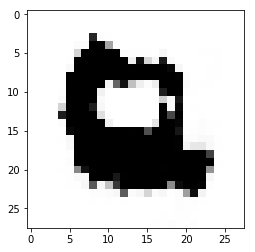

Estimate: [[-16.97055244]]
Iteration: 10900 at 2017-07-03 00:46:21.500682


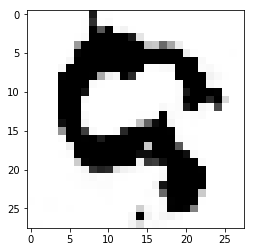

Estimate: [[ 8.23162937]]
Iteration: 11000 at 2017-07-03 00:46:28.741269


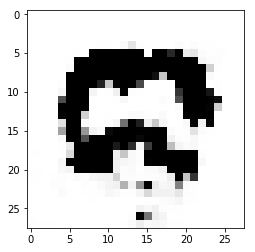

Estimate: [[-8.41714859]]
Iteration: 11100 at 2017-07-03 00:46:36.028765


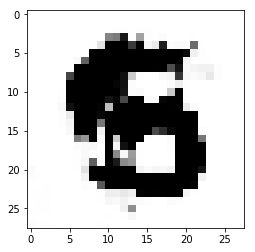

Estimate: [[-4.35968208]]
Iteration: 11200 at 2017-07-03 00:46:43.325481


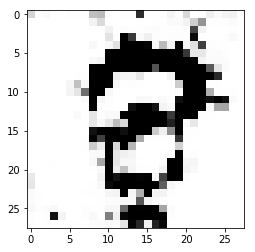

Estimate: [[-16.51091003]]
Iteration: 11300 at 2017-07-03 00:46:50.624628


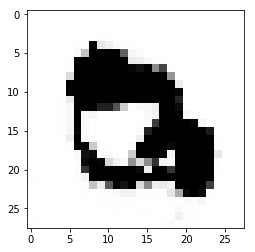

Estimate: [[-6.23036814]]
Iteration: 11400 at 2017-07-03 00:46:57.996030


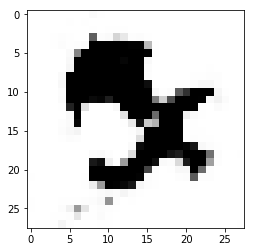

Estimate: [[-6.78610039]]
Iteration: 11500 at 2017-07-03 00:47:05.303507


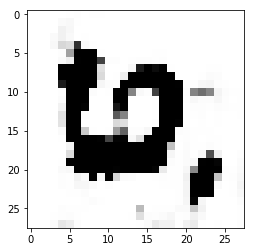

Estimate: [[-22.15481377]]
Iteration: 11600 at 2017-07-03 00:47:12.604542


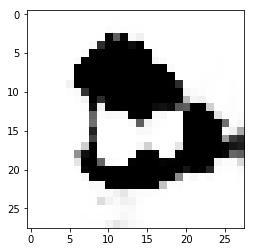

Estimate: [[-6.15436172]]
Iteration: 11700 at 2017-07-03 00:47:19.889756


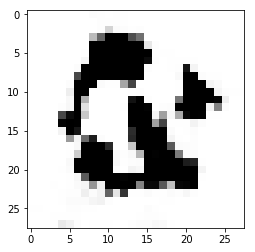

Estimate: [[ 4.93754721]]
Iteration: 11800 at 2017-07-03 00:47:27.131825


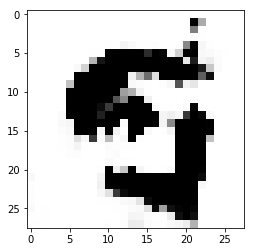

Estimate: [[-9.94326591]]
Iteration: 11900 at 2017-07-03 00:47:34.441102


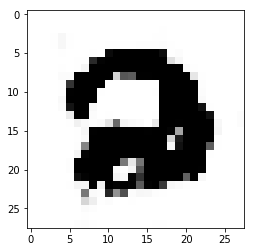

Estimate: [[-5.2458744]]
Iteration: 12000 at 2017-07-03 00:47:41.733346


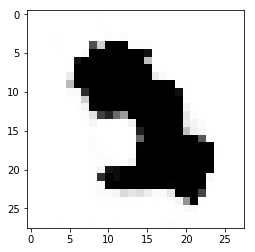

Estimate: [[-0.88046497]]
Iteration: 12100 at 2017-07-03 00:47:49.065847


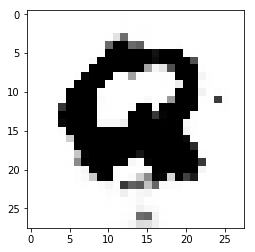

Estimate: [[-9.22570992]]
Iteration: 12200 at 2017-07-03 00:47:56.329424


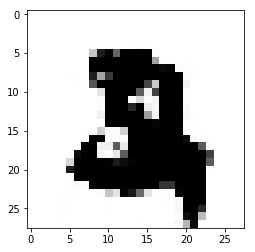

Estimate: [[-5.94767189]]
Iteration: 12300 at 2017-07-03 00:48:04.151204


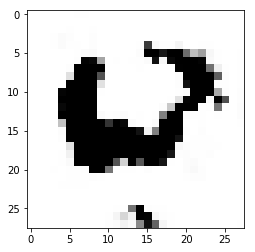

Estimate: [[ 4.69298744]]
Iteration: 12400 at 2017-07-03 00:48:11.461440


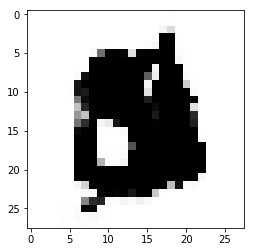

Estimate: [[ 18.90935707]]
Iteration: 12500 at 2017-07-03 00:48:18.856408


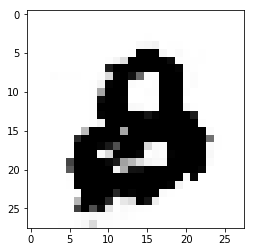

Estimate: [[-7.01773977]]
Iteration: 12600 at 2017-07-03 00:48:26.208758


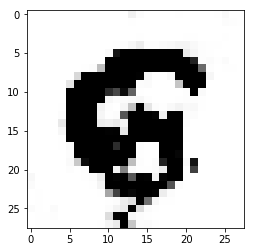

Estimate: [[-3.13771796]]
Iteration: 12700 at 2017-07-03 00:48:33.537490


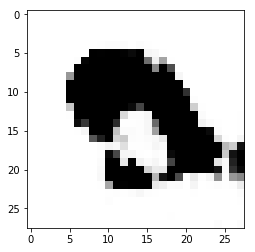

Estimate: [[-0.11701422]]
Iteration: 12800 at 2017-07-03 00:48:40.848560


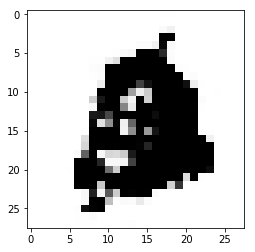

Estimate: [[-16.91836357]]
Iteration: 12900 at 2017-07-03 00:48:48.160890


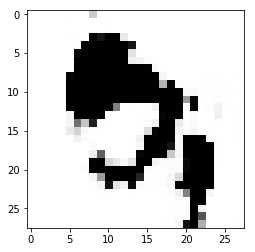

Estimate: [[ 15.84401321]]
Iteration: 13000 at 2017-07-03 00:48:55.519958


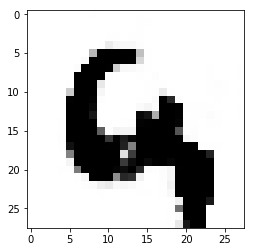

Estimate: [[ 6.77424908]]
Iteration: 13100 at 2017-07-03 00:49:02.840894


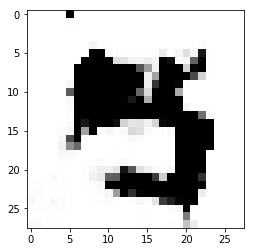

Estimate: [[ 7.70214701]]
Iteration: 13200 at 2017-07-03 00:49:10.252261


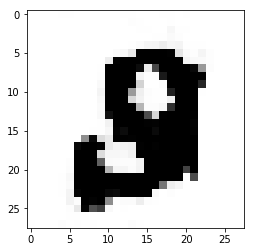

Estimate: [[ 2.44877362]]
Iteration: 13300 at 2017-07-03 00:49:17.620008


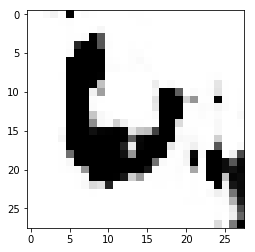

Estimate: [[-1.5812906]]
Iteration: 13400 at 2017-07-03 00:49:24.977285


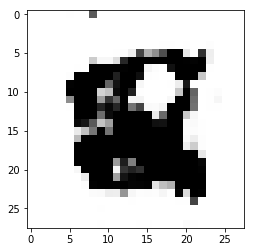

Estimate: [[-7.2740221]]
Iteration: 13500 at 2017-07-03 00:49:32.328753


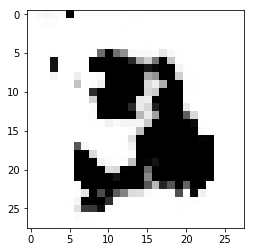

Estimate: [[ 10.11518383]]
Iteration: 13600 at 2017-07-03 00:49:39.722271


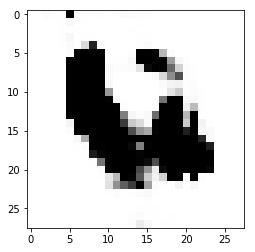

Estimate: [[ 7.30572033]]
Iteration: 13700 at 2017-07-03 00:49:47.060455


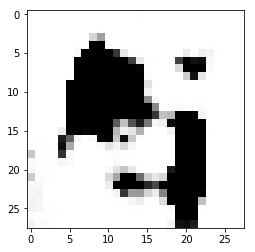

Estimate: [[ 4.88015985]]
Iteration: 13800 at 2017-07-03 00:49:54.420110


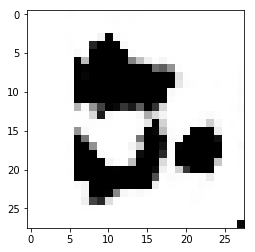

Estimate: [[-19.48901176]]
Iteration: 13900 at 2017-07-03 00:50:01.819923


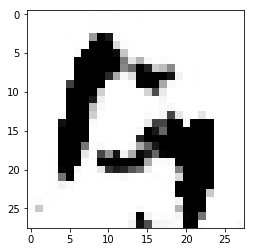

Estimate: [[-5.50000572]]
Iteration: 14000 at 2017-07-03 00:50:09.268370


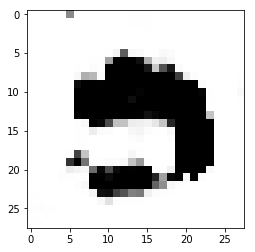

Estimate: [[-7.92159271]]
Iteration: 14100 at 2017-07-03 00:50:16.587595


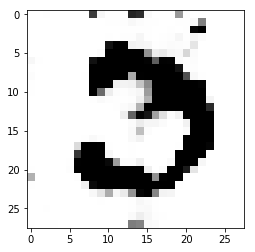

Estimate: [[ 14.54568672]]
Iteration: 14200 at 2017-07-03 00:50:23.976628


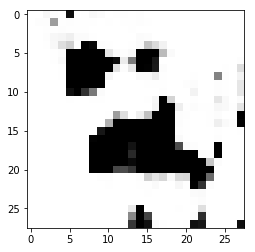

Estimate: [[-34.37487411]]
Iteration: 14300 at 2017-07-03 00:50:31.306931


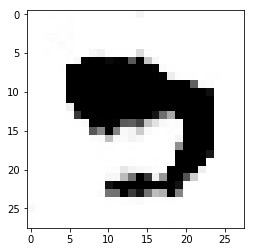

Estimate: [[ 4.38067722]]
Iteration: 14400 at 2017-07-03 00:50:38.659973


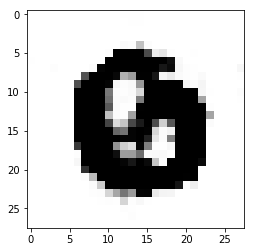

Estimate: [[ 1.34490609]]
Iteration: 14500 at 2017-07-03 00:50:46.068100


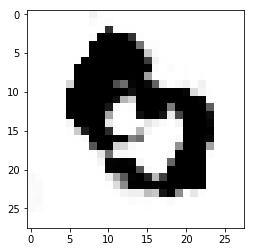

Estimate: [[-18.98768616]]
Iteration: 14600 at 2017-07-03 00:50:53.502798


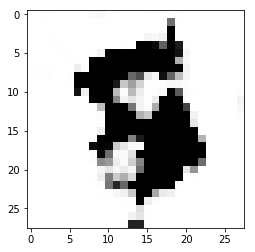

Estimate: [[ 6.97675991]]
Iteration: 14700 at 2017-07-03 00:51:00.965120


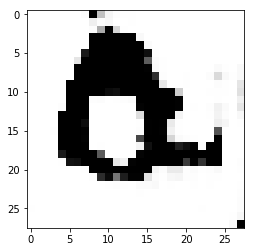

Estimate: [[ 0.17422366]]
Iteration: 14800 at 2017-07-03 00:51:08.425192


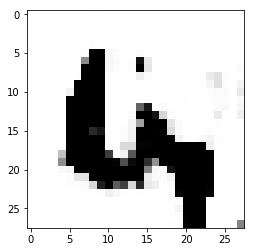

Estimate: [[-18.07255554]]
Iteration: 14900 at 2017-07-03 00:51:15.792787


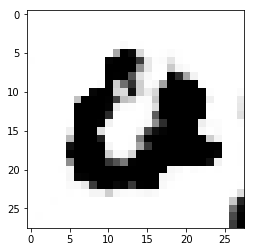

Estimate: [[ 24.53146744]]
Iteration: 15000 at 2017-07-03 00:51:23.194545


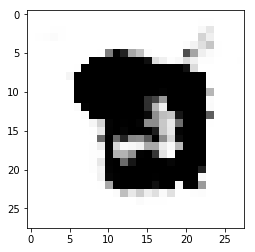

Estimate: [[-16.84527016]]
Iteration: 15100 at 2017-07-03 00:51:30.632136


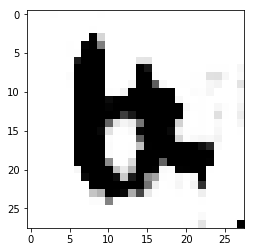

Estimate: [[ 16.61302567]]
Iteration: 15200 at 2017-07-03 00:51:38.098024


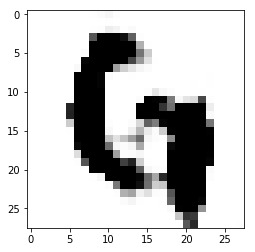

Estimate: [[-10.08486652]]
Iteration: 15300 at 2017-07-03 00:51:45.584931


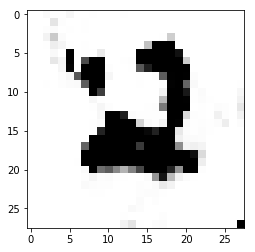

Estimate: [[ 2.97559047]]
Iteration: 15400 at 2017-07-03 00:51:53.025530


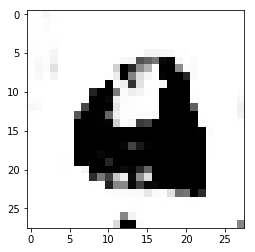

Estimate: [[-3.84822583]]
Iteration: 15500 at 2017-07-03 00:52:00.559050


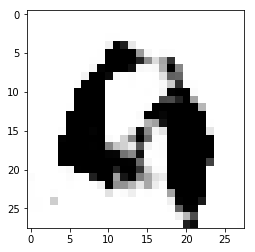

Estimate: [[ 2.23341417]]
Iteration: 15600 at 2017-07-03 00:52:08.032477


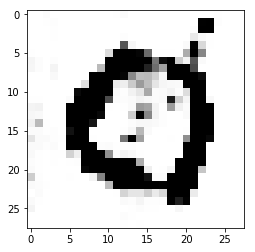

Estimate: [[ 0.38601637]]
Iteration: 15700 at 2017-07-03 00:52:16.048379


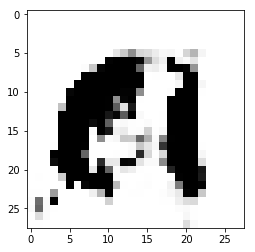

Estimate: [[-25.25125885]]
Iteration: 15800 at 2017-07-03 00:52:23.611692


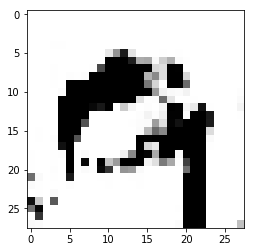

Estimate: [[-14.71011066]]
Iteration: 15900 at 2017-07-03 00:52:31.136672


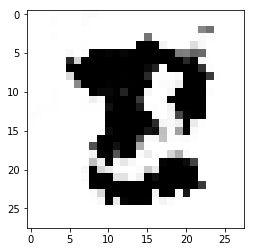

Estimate: [[-16.51428795]]
Iteration: 16000 at 2017-07-03 00:52:38.618610


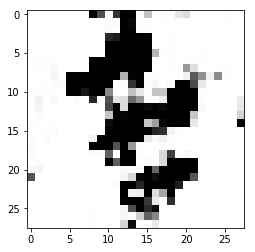

Estimate: [[-2.97594881]]
Iteration: 16100 at 2017-07-03 00:52:46.117985


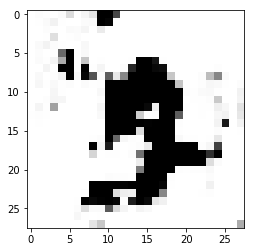

Estimate: [[-35.7618103]]
Iteration: 16200 at 2017-07-03 00:52:53.646683


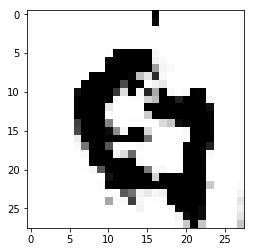

Estimate: [[ 16.24690437]]
Iteration: 16300 at 2017-07-03 00:53:01.223697


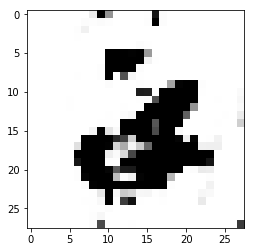

Estimate: [[-5.02189589]]
Iteration: 16400 at 2017-07-03 00:53:08.773427


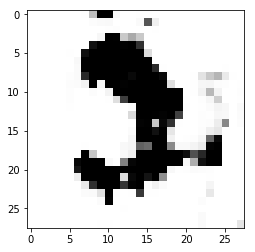

Estimate: [[ 17.90065384]]
Iteration: 16500 at 2017-07-03 00:53:16.311354


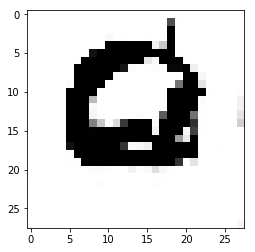

Estimate: [[ 22.93964958]]
Iteration: 16600 at 2017-07-03 00:53:23.788653


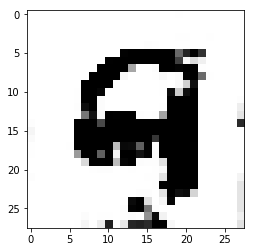

Estimate: [[-17.54162598]]
Iteration: 16700 at 2017-07-03 00:53:31.300931


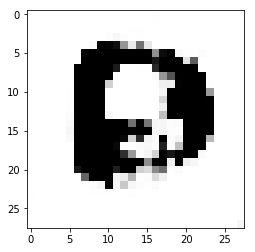

Estimate: [[-0.87510216]]
Iteration: 16800 at 2017-07-03 00:53:38.782328


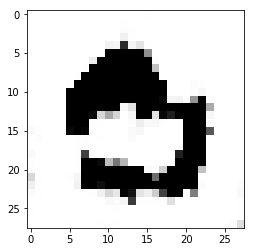

Estimate: [[ 6.08253527]]
Iteration: 16900 at 2017-07-03 00:53:46.387500


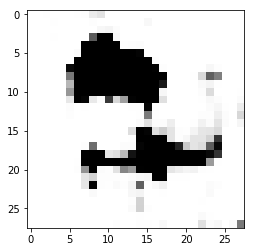

Estimate: [[-10.37069225]]
Iteration: 17000 at 2017-07-03 00:53:53.971075


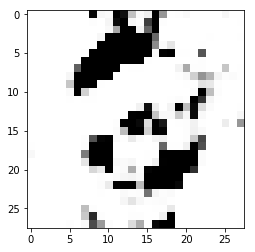

Estimate: [[-22.50379181]]
Iteration: 17100 at 2017-07-03 00:54:01.531771


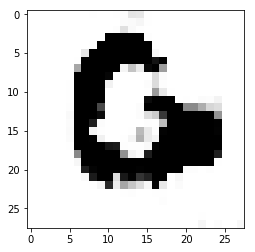

Estimate: [[ 6.67018175]]
Iteration: 17200 at 2017-07-03 00:54:09.066507


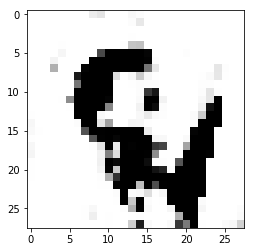

Estimate: [[-18.40062141]]
Iteration: 17300 at 2017-07-03 00:54:16.563993


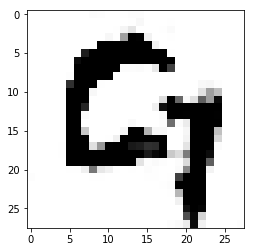

Estimate: [[ 10.72199631]]
Iteration: 17400 at 2017-07-03 00:54:24.095788


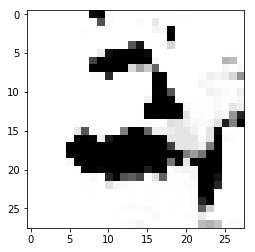

Estimate: [[ 40.32062531]]
Iteration: 17500 at 2017-07-03 00:54:31.635367


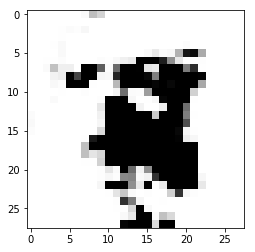

Estimate: [[-16.14130402]]
Iteration: 17600 at 2017-07-03 00:54:39.199641


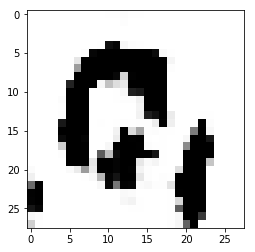

Estimate: [[ 1.88278663]]
Iteration: 17700 at 2017-07-03 00:54:46.767497


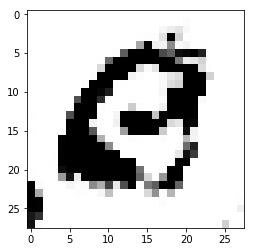

Estimate: [[ 9.51829243]]
Iteration: 17800 at 2017-07-03 00:54:54.342017


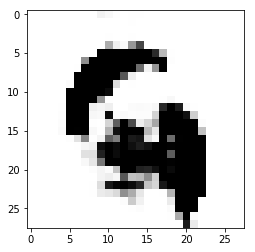

Estimate: [[-9.53526306]]
Iteration: 17900 at 2017-07-03 00:55:01.865664


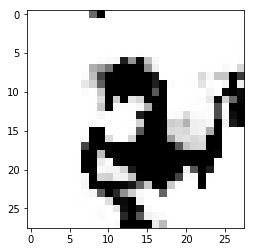

Estimate: [[ 30.89344597]]
Iteration: 18000 at 2017-07-03 00:55:09.459578


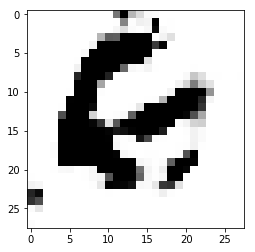

Estimate: [[-29.10651398]]
Iteration: 18100 at 2017-07-03 00:55:17.032696


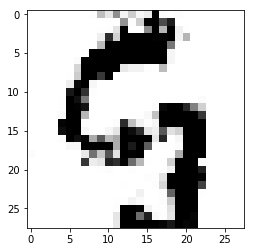

Estimate: [[-17.12532616]]
Iteration: 18200 at 2017-07-03 00:55:24.586794


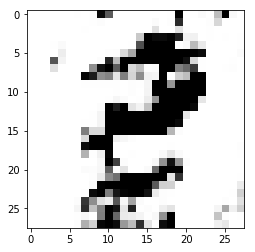

Estimate: [[ 10.79709148]]
Iteration: 18300 at 2017-07-03 00:55:32.230598


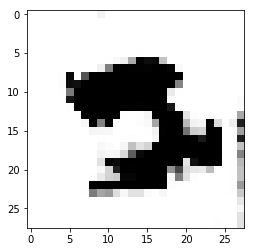

Estimate: [[-5.24845266]]
Iteration: 18400 at 2017-07-03 00:55:39.858148


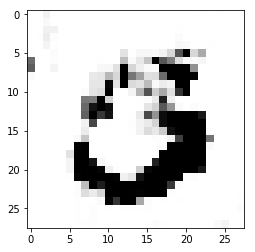

Estimate: [[-44.45374298]]
Iteration: 18500 at 2017-07-03 00:55:47.469034


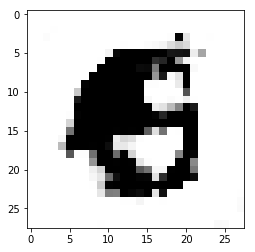

Estimate: [[-5.16272259]]
Iteration: 18600 at 2017-07-03 00:55:55.023391


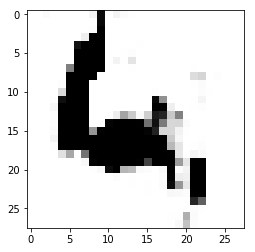

Estimate: [[-30.74882317]]
Iteration: 18700 at 2017-07-03 00:56:02.616149


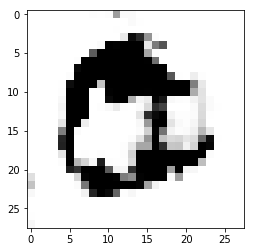

Estimate: [[-52.30761719]]
Iteration: 18800 at 2017-07-03 00:56:10.153294


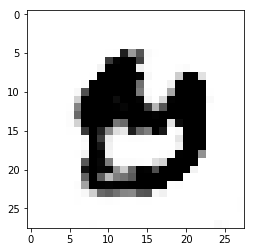

Estimate: [[ 33.07465363]]
Iteration: 18900 at 2017-07-03 00:56:17.772031


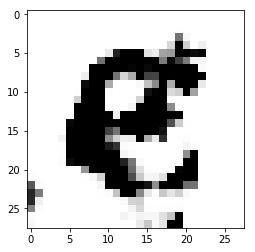

Estimate: [[ 0.64306366]]
Iteration: 19000 at 2017-07-03 00:56:25.361342


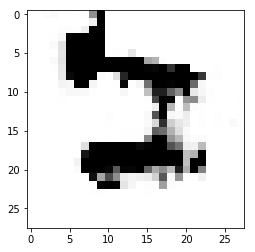

Estimate: [[ 6.8250742]]
Iteration: 19100 at 2017-07-03 00:56:33.052467


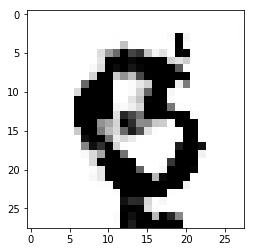

Estimate: [[ 11.94971657]]
Iteration: 19200 at 2017-07-03 00:56:40.722710


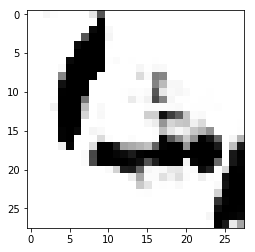

Estimate: [[ 43.90049362]]
Iteration: 19300 at 2017-07-03 00:56:48.348870


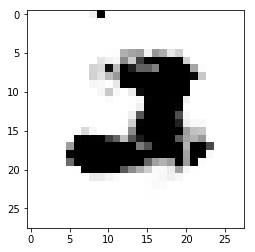

Estimate: [[ 4.29886055]]
Iteration: 19400 at 2017-07-03 00:56:56.040632


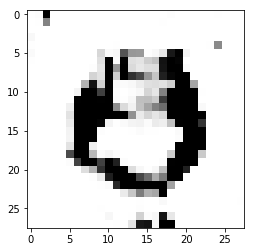

Estimate: [[-10.13262844]]
Iteration: 19500 at 2017-07-03 00:57:03.697193


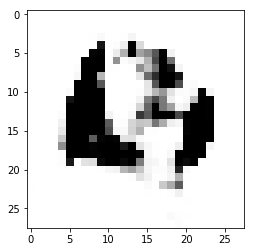

Estimate: [[-42.20320129]]
Iteration: 19600 at 2017-07-03 00:57:11.944543


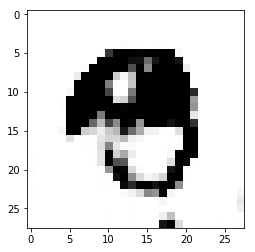

Estimate: [[-2.82350111]]
Iteration: 19700 at 2017-07-03 00:57:19.572832


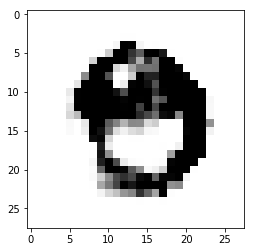

Estimate: [[ 5.09639883]]
Iteration: 19800 at 2017-07-03 00:57:27.280269


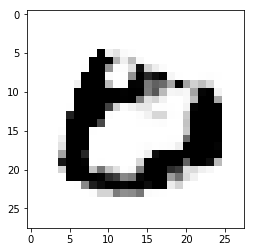

Estimate: [[ 19.7602787]]
Iteration: 19900 at 2017-07-03 00:57:34.995475


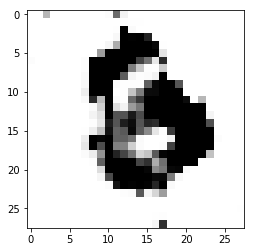

Estimate: [[ 11.21010685]]
Iteration: 20000 at 2017-07-03 00:57:42.751037


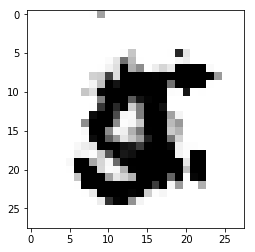

Estimate: [[ 26.06777191]]
Iteration: 20100 at 2017-07-03 00:57:50.500560


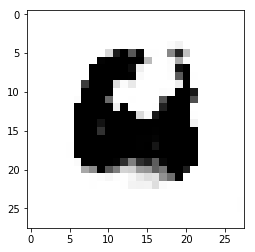

Estimate: [[-18.17533112]]
Iteration: 20200 at 2017-07-03 00:57:58.271236


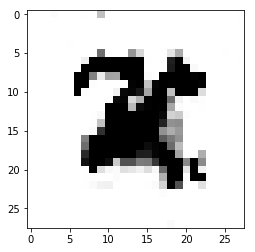

Estimate: [[ 33.71414948]]
Iteration: 20300 at 2017-07-03 00:58:06.016647


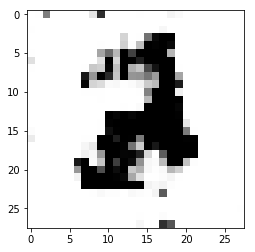

Estimate: [[-23.23182106]]
Iteration: 20400 at 2017-07-03 00:58:13.775221


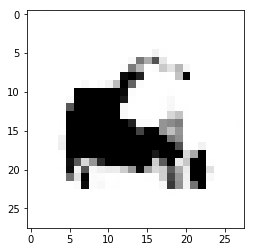

Estimate: [[ 22.1121006]]
Iteration: 20500 at 2017-07-03 00:58:21.484183


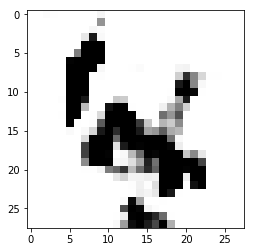

Estimate: [[-15.89176083]]
Iteration: 20600 at 2017-07-03 00:58:29.211035


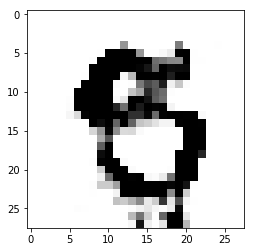

Estimate: [[-2.47873831]]
Iteration: 20700 at 2017-07-03 00:58:36.914249


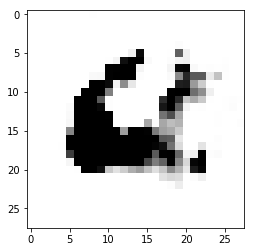

Estimate: [[ 22.41412163]]
Iteration: 20800 at 2017-07-03 00:58:44.721110


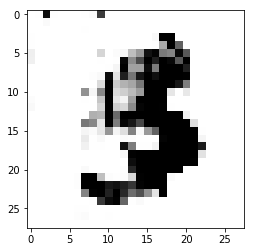

Estimate: [[ 23.77008057]]
Iteration: 20900 at 2017-07-03 00:58:52.485577


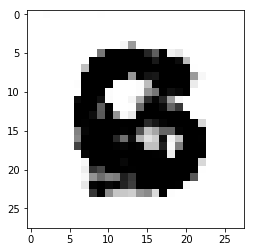

Estimate: [[ 5.28102303]]
Iteration: 21000 at 2017-07-03 00:59:00.197320


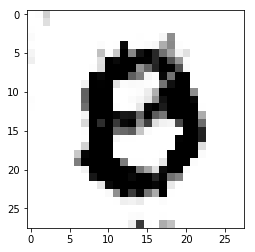

Estimate: [[-12.28620434]]
Iteration: 21100 at 2017-07-03 00:59:07.904980


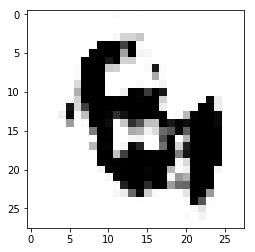

Estimate: [[-32.94750595]]
Iteration: 21200 at 2017-07-03 00:59:15.608584


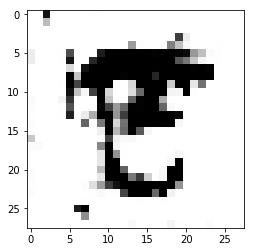

Estimate: [[-29.26131821]]
Iteration: 21300 at 2017-07-03 00:59:23.341359


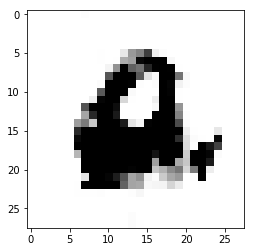

Estimate: [[-26.67924118]]
Iteration: 21400 at 2017-07-03 00:59:31.009771


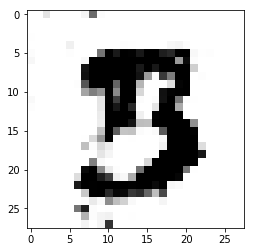

Estimate: [[ 16.14069557]]
Iteration: 21500 at 2017-07-03 00:59:38.754816


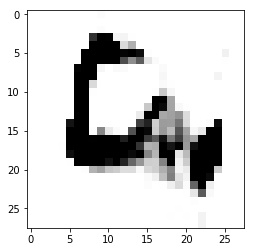

Estimate: [[-20.05288124]]
Iteration: 21600 at 2017-07-03 00:59:46.499184


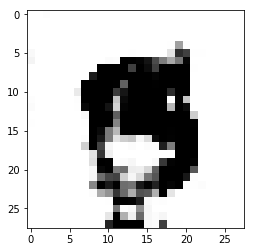

Estimate: [[-4.17163229]]
Iteration: 21700 at 2017-07-03 00:59:54.292411


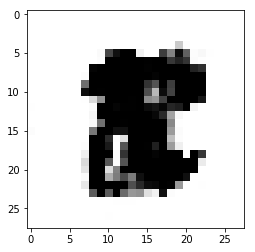

Estimate: [[ 10.53754997]]
Iteration: 21800 at 2017-07-03 01:00:02.114118


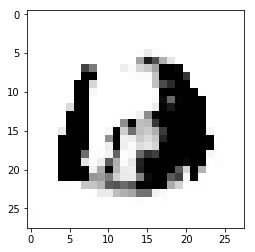

Estimate: [[-35.92383194]]
Iteration: 21900 at 2017-07-03 01:00:09.893476


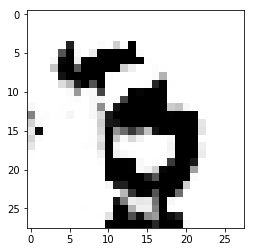

Estimate: [[ 42.25567245]]
Iteration: 22000 at 2017-07-03 01:00:17.649351


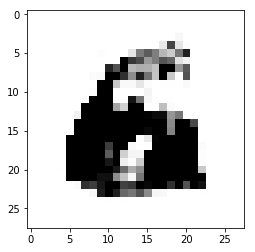

Estimate: [[-0.27938676]]
Iteration: 22100 at 2017-07-03 01:00:25.495351


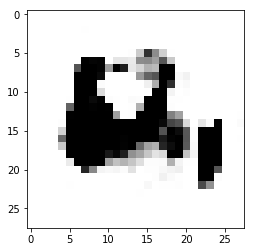

Estimate: [[-23.73041153]]
Iteration: 22200 at 2017-07-03 01:00:33.219372


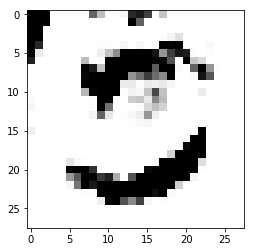

Estimate: [[-7.9250536]]
Iteration: 22300 at 2017-07-03 01:00:40.986091


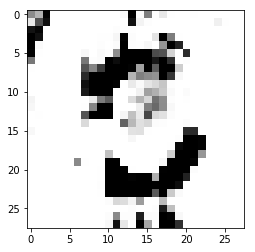

Estimate: [[-58.83629227]]
Iteration: 22400 at 2017-07-03 01:00:48.844404


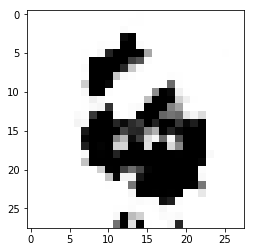

Estimate: [[-26.11253738]]
Iteration: 22500 at 2017-07-03 01:00:56.645386


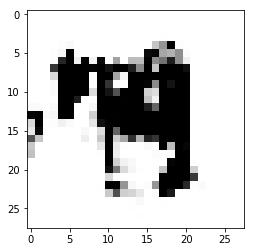

Estimate: [[ 75.2477417]]
Iteration: 22600 at 2017-07-03 01:01:04.396397


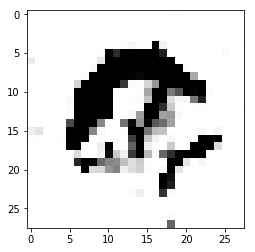

Estimate: [[-40.92464828]]
Iteration: 22700 at 2017-07-03 01:01:12.198267


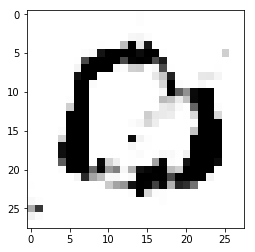

Estimate: [[ 50.71818542]]
Iteration: 22800 at 2017-07-03 01:01:20.026744


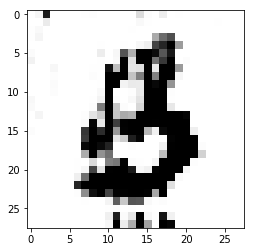

Estimate: [[-53.44852066]]
Iteration: 22900 at 2017-07-03 01:01:27.831798


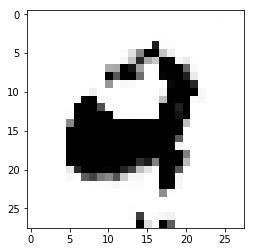

Estimate: [[-19.19378471]]
Iteration: 23000 at 2017-07-03 01:01:35.700282


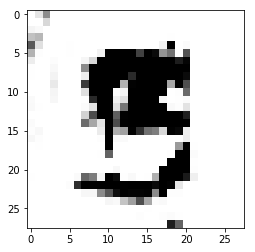

Estimate: [[ 10.27516556]]
Iteration: 23100 at 2017-07-03 01:01:43.583286


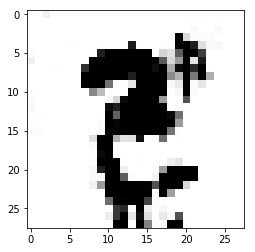

Estimate: [[-26.76741791]]
Iteration: 23200 at 2017-07-03 01:01:51.438450


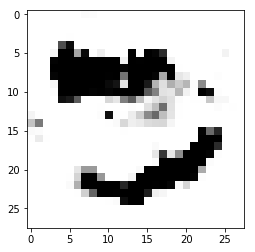

Estimate: [[-0.52714443]]
Iteration: 23300 at 2017-07-03 01:01:59.270365


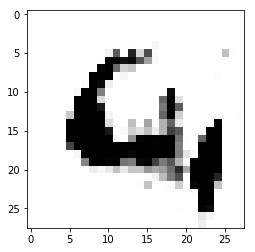

Estimate: [[ 16.28285789]]
Iteration: 23400 at 2017-07-03 01:02:07.153719


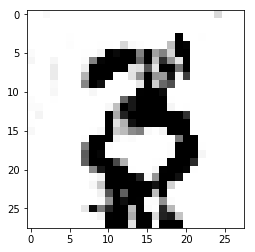

Estimate: [[ 24.38272095]]
Iteration: 23500 at 2017-07-03 01:02:15.038689


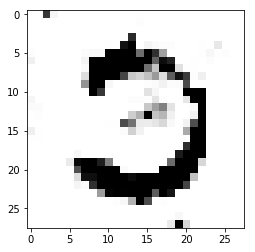

Estimate: [[ 2.1639502]]
Iteration: 23600 at 2017-07-03 01:02:22.885217


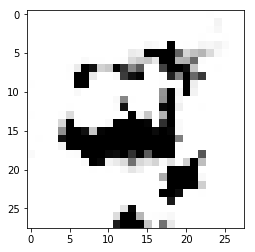

Estimate: [[-19.39248657]]
Iteration: 23700 at 2017-07-03 01:02:30.752985


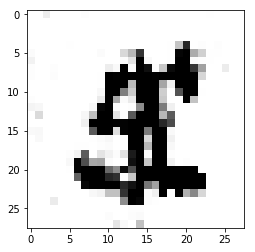

Estimate: [[-37.52058792]]
Iteration: 23800 at 2017-07-03 01:02:38.640672


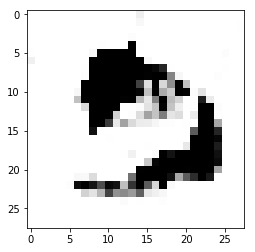

Estimate: [[-16.11981201]]
Iteration: 23900 at 2017-07-03 01:02:46.522970


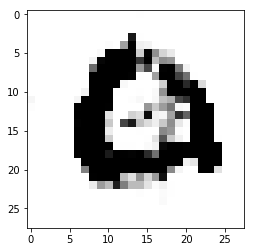

Estimate: [[ 21.59206009]]
Iteration: 24000 at 2017-07-03 01:02:55.069499


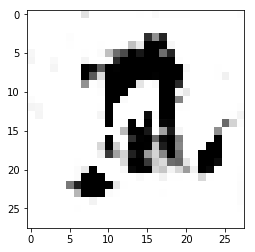

Estimate: [[ 28.63369179]]
Iteration: 24100 at 2017-07-03 01:03:02.979308


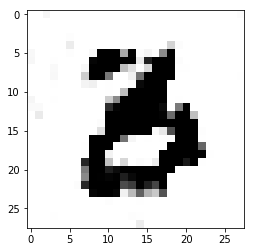

Estimate: [[ 53.39417648]]
Iteration: 24200 at 2017-07-03 01:03:10.969567


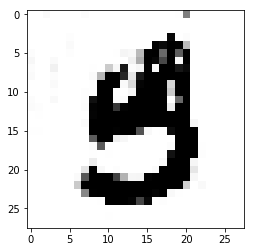

Estimate: [[-6.66215038]]
Iteration: 24300 at 2017-07-03 01:03:18.938290


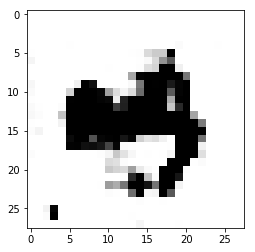

Estimate: [[ 5.93083715]]
Iteration: 24400 at 2017-07-03 01:03:26.909307


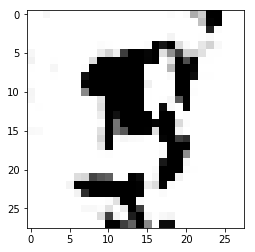

Estimate: [[ 23.22230339]]
Iteration: 24500 at 2017-07-03 01:03:34.887574


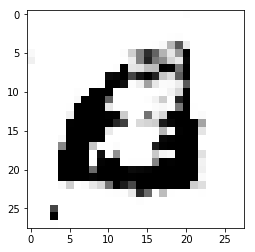

Estimate: [[ 15.94235992]]
Iteration: 24600 at 2017-07-03 01:03:42.906161


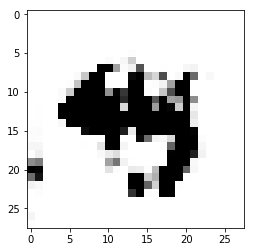

Estimate: [[-27.62782097]]
Iteration: 24700 at 2017-07-03 01:03:50.815889


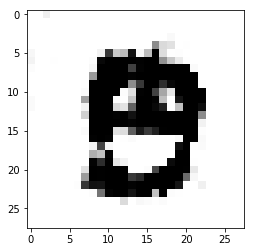

Estimate: [[ 7.54970646]]
Iteration: 24800 at 2017-07-03 01:03:58.772682


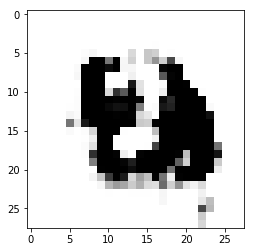

Estimate: [[-86.64561462]]
Iteration: 24900 at 2017-07-03 01:04:06.780163


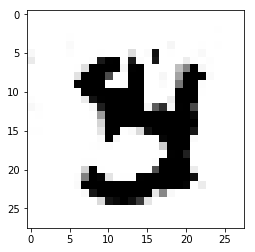

Estimate: [[ 4.31259823]]
Iteration: 25000 at 2017-07-03 01:04:14.763804


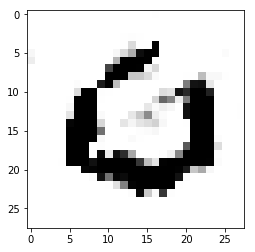

Estimate: [[ 22.22672844]]
Iteration: 25100 at 2017-07-03 01:04:22.715942


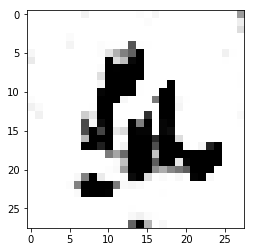

Estimate: [[ 16.22706413]]
Iteration: 25200 at 2017-07-03 01:04:30.721942


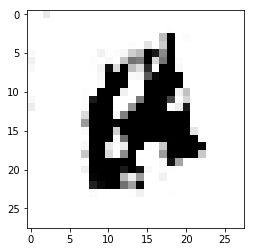

Estimate: [[-3.3479712]]
Iteration: 25300 at 2017-07-03 01:04:38.685988


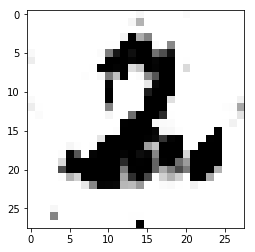

Estimate: [[-12.40035152]]
Iteration: 25400 at 2017-07-03 01:04:46.662108


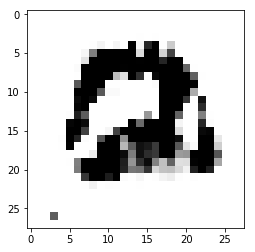

Estimate: [[-11.77489853]]
Iteration: 25500 at 2017-07-03 01:04:54.644867


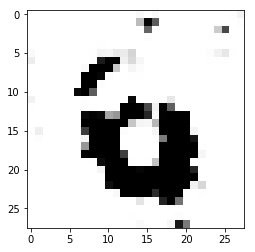

Estimate: [[-14.79311562]]
Iteration: 25600 at 2017-07-03 01:05:02.665927


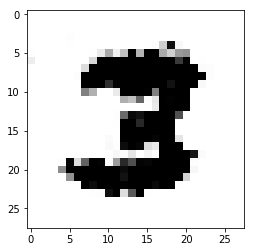

Estimate: [[ 40.02627563]]
Iteration: 26800 at 2017-07-03 01:06:38.509098


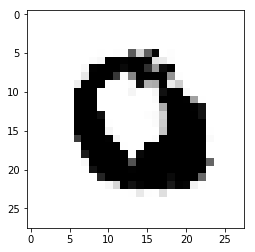

Estimate: [[-26.2749691]]


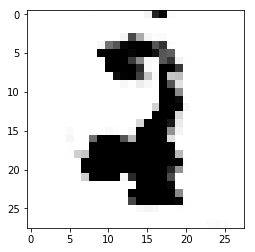

Estimate: [[-22.9698658]]
Iteration: 40000 at 2017-07-03 01:25:03.023270


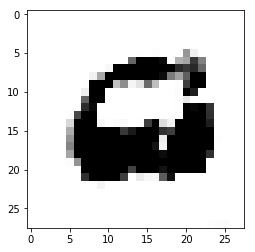

Estimate: [[ 16.74054337]]
Iteration: 40100 at 2017-07-03 01:25:11.702429


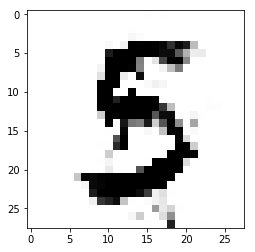

Estimate: [[ 28.67922974]]
Iteration: 40200 at 2017-07-03 01:25:20.414395


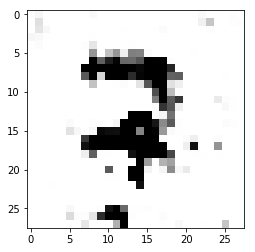

Estimate: [[-50.76895142]]
Iteration: 40300 at 2017-07-03 01:25:29.126926


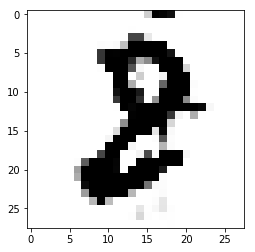

Estimate: [[ 15.43420506]]
Iteration: 40400 at 2017-07-03 01:25:37.854797


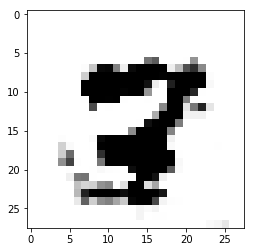

Estimate: [[-63.47593689]]
Iteration: 40500 at 2017-07-03 01:25:46.507743


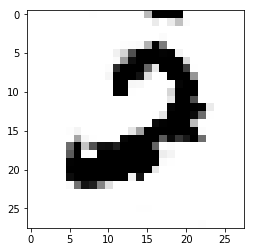

Estimate: [[ 82.93307495]]
Iteration: 40600 at 2017-07-03 01:25:55.381572


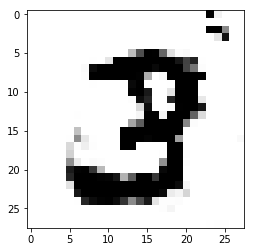

Estimate: [[-5.185009]]
Iteration: 40700 at 2017-07-03 01:26:04.055524


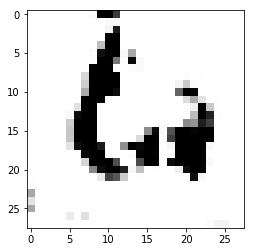

Estimate: [[ 99.04335785]]
Iteration: 40800 at 2017-07-03 01:26:12.725185


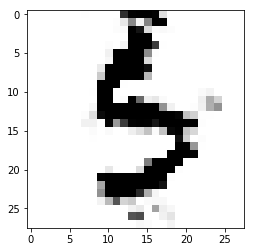

Estimate: [[ 4.12072802]]
Iteration: 40900 at 2017-07-03 01:26:21.436823


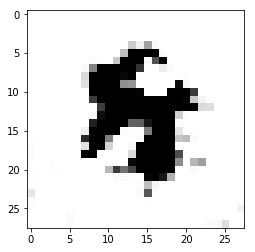

Estimate: [[-58.39308548]]
Iteration: 41000 at 2017-07-03 01:26:30.130640


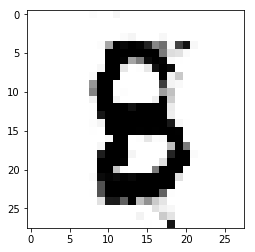

Estimate: [[ 34.81069183]]
Iteration: 41100 at 2017-07-03 01:26:38.921325


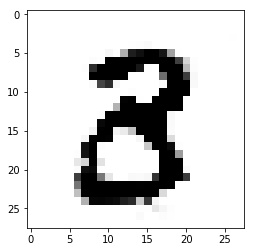

Estimate: [[ 9.97371101]]
Iteration: 41200 at 2017-07-03 01:26:48.820239


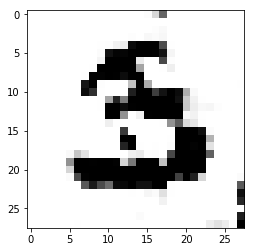

Estimate: [[ 21.60405731]]
Iteration: 41300 at 2017-07-03 01:26:57.585576


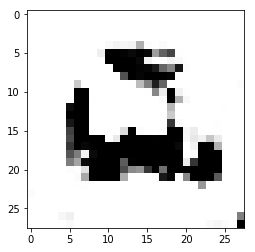

Estimate: [[-1.41653681]]
Iteration: 41400 at 2017-07-03 01:27:06.457937


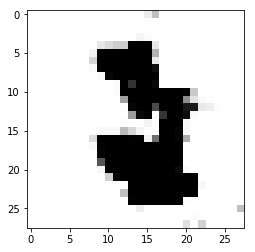

Estimate: [[-18.57193184]]
Iteration: 41500 at 2017-07-03 01:27:15.288189


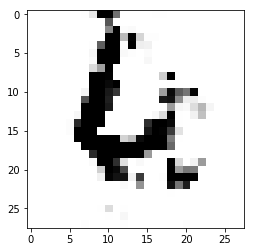

Estimate: [[-24.77240372]]
Iteration: 41600 at 2017-07-03 01:27:24.101835


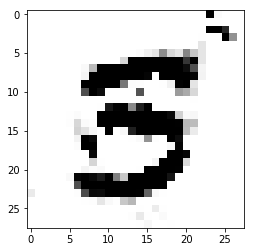

Estimate: [[-18.97842216]]
Iteration: 41700 at 2017-07-03 01:27:33.058657


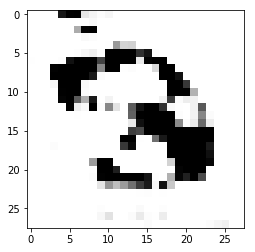

Estimate: [[-50.56932831]]
Iteration: 41800 at 2017-07-03 01:27:41.900269


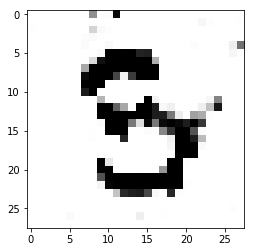

Estimate: [[-23.02510262]]
Iteration: 41900 at 2017-07-03 01:27:50.641894


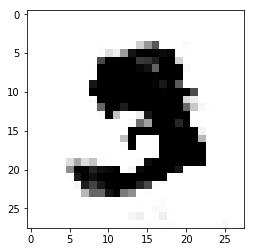

Estimate: [[ 0.6637888]]
Iteration: 42000 at 2017-07-03 01:27:59.502873


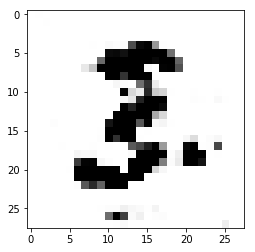

Estimate: [[-7.94076252]]
Iteration: 42100 at 2017-07-03 01:28:08.326364


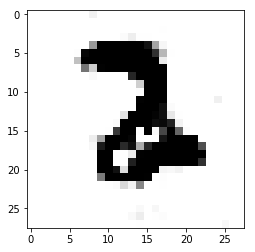

Estimate: [[ 14.01092243]]
Iteration: 42200 at 2017-07-03 01:28:17.199861


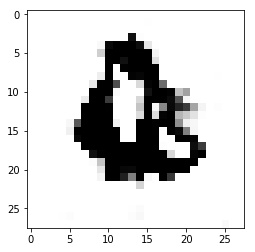

Estimate: [[-14.45357609]]
Iteration: 42300 at 2017-07-03 01:28:25.956749


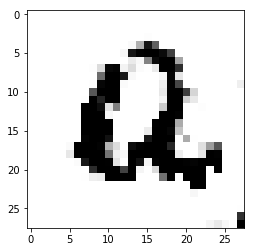

Estimate: [[-18.09246635]]
Iteration: 42400 at 2017-07-03 01:28:34.944802


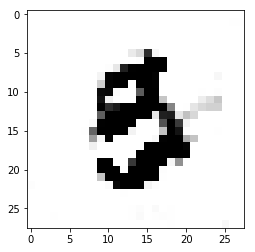

Estimate: [[ 12.35757637]]
Iteration: 42500 at 2017-07-03 01:28:43.799814


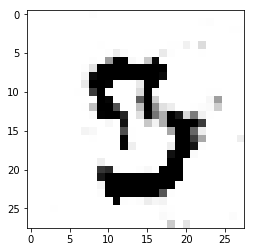

Estimate: [[ 12.96109104]]
Iteration: 42600 at 2017-07-03 01:28:52.592489


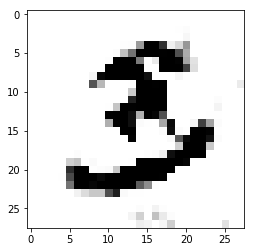

Estimate: [[-17.81495857]]
Iteration: 42700 at 2017-07-03 01:29:01.381228


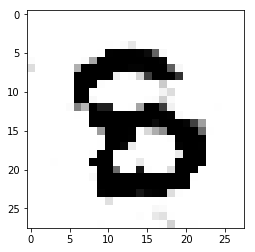

Estimate: [[ 4.40151739]]
Iteration: 42800 at 2017-07-03 01:29:10.239110


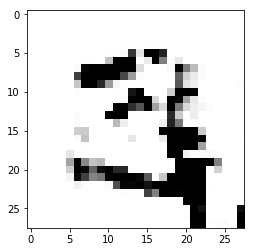

Estimate: [[ 20.44444847]]
Iteration: 42900 at 2017-07-03 01:29:19.048084


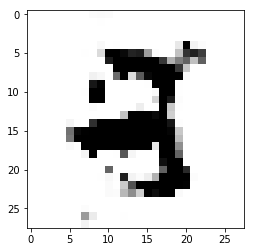

Estimate: [[-70.38126373]]
Iteration: 43000 at 2017-07-03 01:29:27.989400


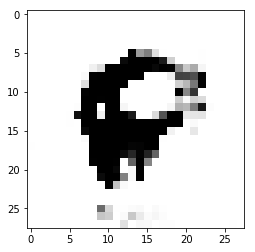

Estimate: [[ 93.71212769]]
Iteration: 43100 at 2017-07-03 01:29:36.865405


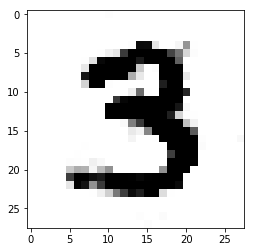

Estimate: [[-8.13261223]]
Iteration: 43200 at 2017-07-03 01:29:45.736036


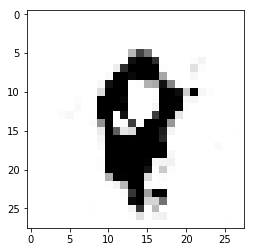

Estimate: [[ 39.29504395]]
Iteration: 43300 at 2017-07-03 01:29:54.589184


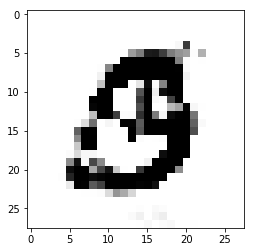

Estimate: [[ 8.07432365]]
Iteration: 43400 at 2017-07-03 01:30:03.390005


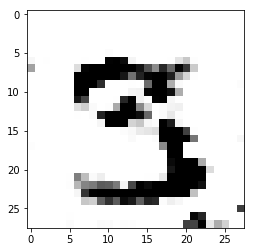

Estimate: [[-31.2220211]]
Iteration: 43500 at 2017-07-03 01:30:12.205377


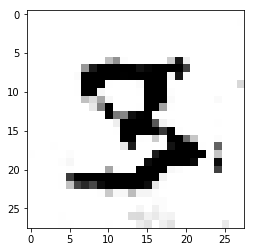

Estimate: [[-10.62805176]]
Iteration: 43600 at 2017-07-03 01:30:21.166325


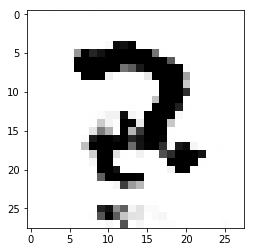

Estimate: [[-23.82176971]]
Iteration: 43700 at 2017-07-03 01:30:29.977227


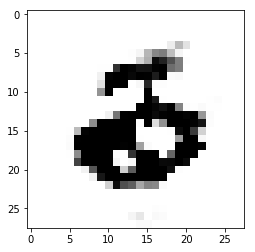

Estimate: [[ 12.62878799]]
Iteration: 43800 at 2017-07-03 01:30:38.876630


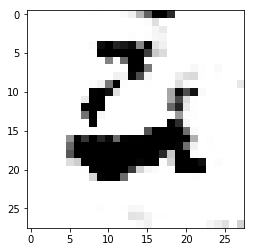

Estimate: [[-24.11291885]]
Iteration: 43900 at 2017-07-03 01:30:47.813548


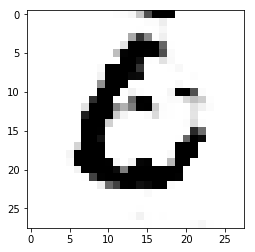

Estimate: [[-4.14266777]]
Iteration: 44000 at 2017-07-03 01:30:56.712889


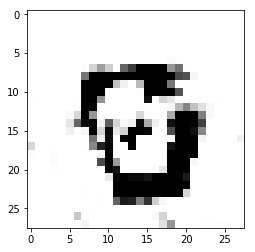

Estimate: [[-18.58277512]]
Iteration: 44100 at 2017-07-03 01:31:05.730664


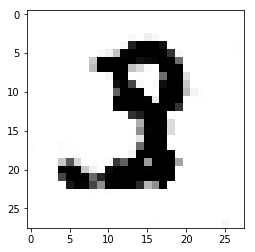

Estimate: [[ 3.71136856]]
Iteration: 44200 at 2017-07-03 01:31:14.661305


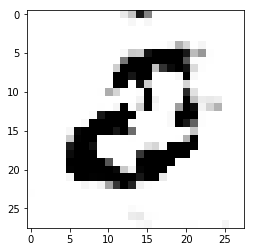

Estimate: [[-2.75474501]]
Iteration: 44300 at 2017-07-03 01:31:23.562000


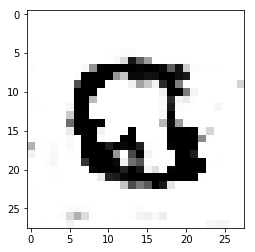

Estimate: [[-62.59428406]]
Iteration: 44400 at 2017-07-03 01:31:32.473092


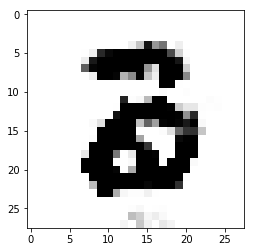

Estimate: [[-48.68337631]]
Iteration: 44500 at 2017-07-03 01:31:41.403154


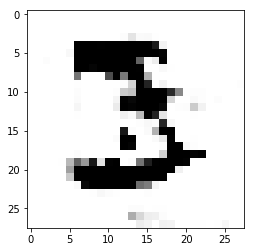

Estimate: [[-8.03813648]]
Iteration: 44600 at 2017-07-03 01:31:50.319825


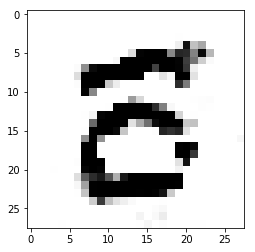

Estimate: [[-15.76527309]]
Iteration: 44700 at 2017-07-03 01:31:59.516422


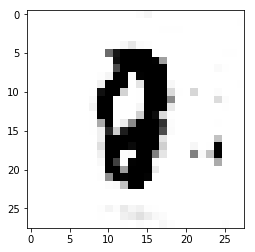

Estimate: [[ 6.73056507]]
Iteration: 44800 at 2017-07-03 01:32:08.513668


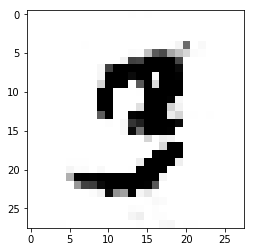

Estimate: [[ 18.1429615]]
Iteration: 44900 at 2017-07-03 01:32:17.446039


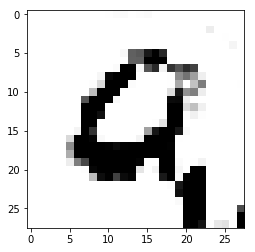

Estimate: [[ 71.5672226]]
Iteration: 45000 at 2017-07-03 01:32:26.479185


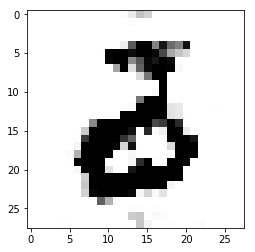

Estimate: [[ 25.37079811]]
Iteration: 45100 at 2017-07-03 01:32:35.489547


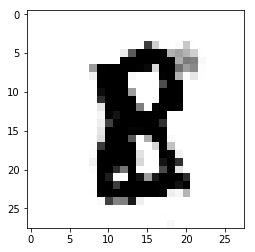

Estimate: [[ 50.30063248]]
Iteration: 45200 at 2017-07-03 01:32:44.681771


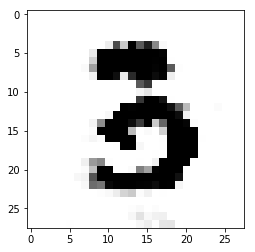

Estimate: [[ 9.52559566]]
Iteration: 45300 at 2017-07-03 01:32:53.704553


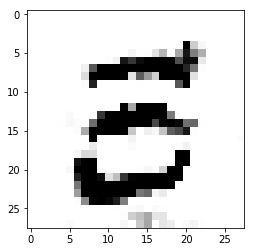

Estimate: [[ 76.77346802]]
Iteration: 45400 at 2017-07-03 01:33:02.665531


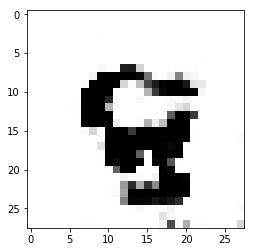

Estimate: [[-35.47540283]]
Iteration: 45500 at 2017-07-03 01:33:11.672485


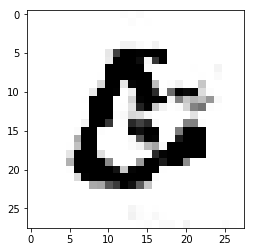

Estimate: [[ 4.05524349]]
Iteration: 45600 at 2017-07-03 01:33:20.571512


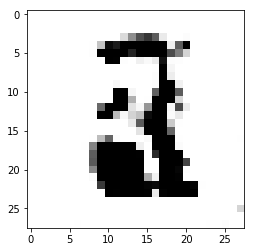

Estimate: [[ 13.99420071]]
Iteration: 45700 at 2017-07-03 01:33:29.563708


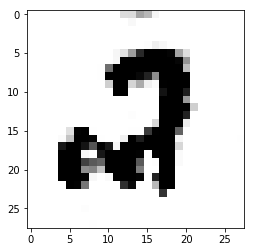

Estimate: [[ 7.08006001]]
Iteration: 45800 at 2017-07-03 01:33:38.530858


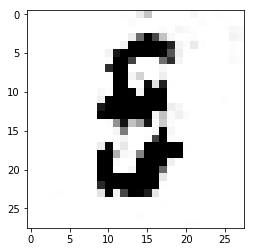

Estimate: [[-1.9668963]]
Iteration: 45900 at 2017-07-03 01:33:47.556726


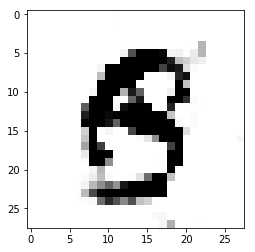

Estimate: [[-11.71485806]]
Iteration: 46000 at 2017-07-03 01:33:56.598520


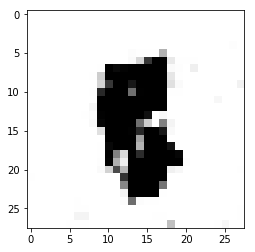

Estimate: [[ 95.29337311]]
Iteration: 46100 at 2017-07-03 01:34:05.574396


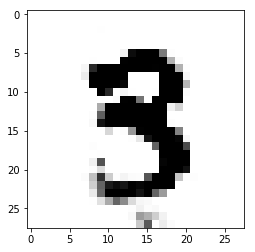

Estimate: [[ 25.18152428]]
Iteration: 46200 at 2017-07-03 01:34:14.649779


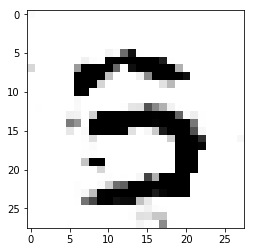

Estimate: [[ 6.75272608]]
Iteration: 46300 at 2017-07-03 01:34:23.704186


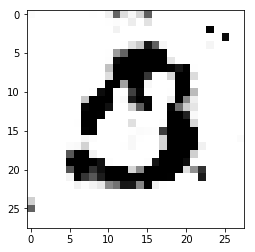

Estimate: [[-0.51154333]]
Iteration: 46400 at 2017-07-03 01:34:32.709875


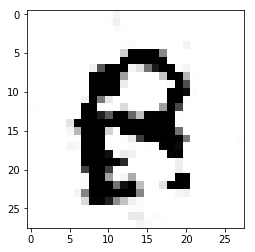

Estimate: [[ 16.29878426]]
Iteration: 46500 at 2017-07-03 01:34:41.700203


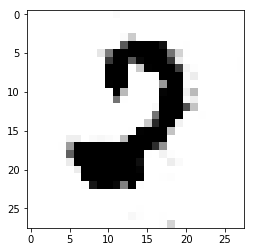

Estimate: [[ 66.45523071]]
Iteration: 46600 at 2017-07-03 01:34:50.696324


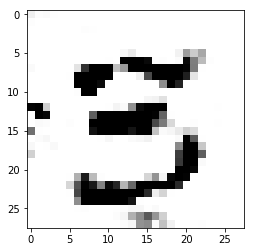

Estimate: [[-26.36301231]]
Iteration: 46700 at 2017-07-03 01:34:59.904781


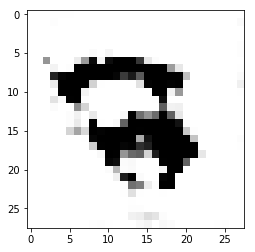

Estimate: [[-31.0951519]]
Iteration: 46800 at 2017-07-03 01:35:08.966953


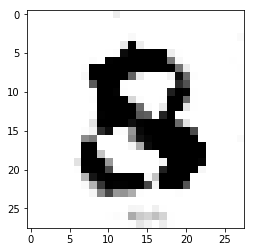

Estimate: [[-16.84204674]]
Iteration: 46900 at 2017-07-03 01:35:18.035588


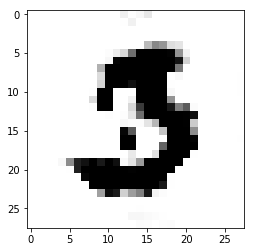

Estimate: [[ 1.10833943]]
Iteration: 47000 at 2017-07-03 01:35:26.989010


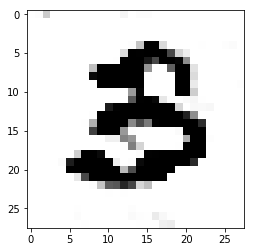

Estimate: [[ 17.78884125]]
Iteration: 47100 at 2017-07-03 01:35:35.939113


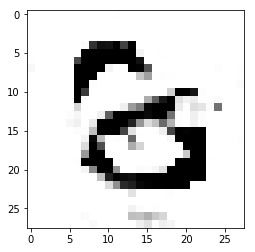

Estimate: [[ 25.41238022]]
Iteration: 47200 at 2017-07-03 01:35:45.113547


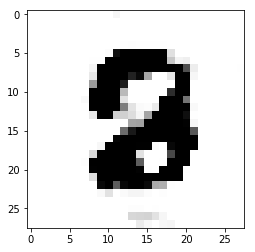

Estimate: [[-37.8336525]]
Iteration: 47300 at 2017-07-03 01:35:54.116662


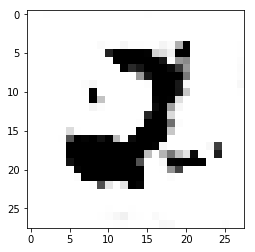

Estimate: [[-93.33054352]]
Iteration: 47400 at 2017-07-03 01:36:03.156575


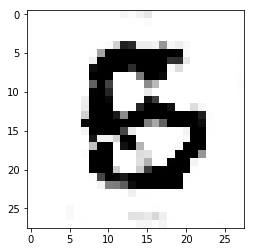

Estimate: [[-9.84409618]]
Iteration: 47500 at 2017-07-03 01:36:12.178840


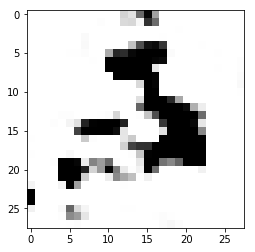

Estimate: [[ 18.19529724]]
Iteration: 47600 at 2017-07-03 01:36:21.204343


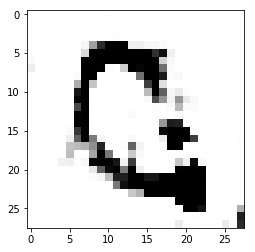

Estimate: [[ 113.8730011]]
Iteration: 47700 at 2017-07-03 01:36:30.244804


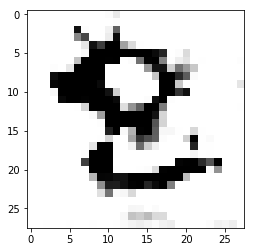

Estimate: [[ 6.12322044]]
Iteration: 47800 at 2017-07-03 01:36:39.293683


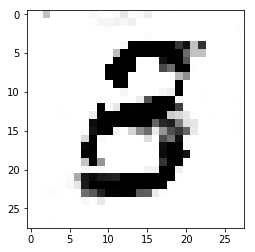

Estimate: [[ 35.22856903]]
Iteration: 47900 at 2017-07-03 01:36:48.332256


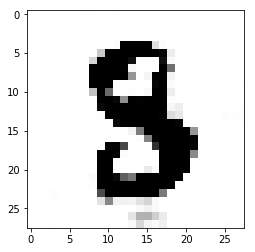

Estimate: [[-10.70107269]]
Iteration: 48000 at 2017-07-03 01:36:57.436392


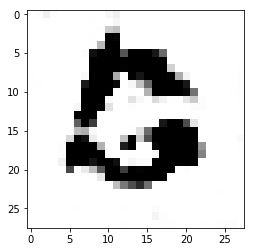

Estimate: [[-31.26469421]]
Iteration: 48100 at 2017-07-03 01:37:06.509026


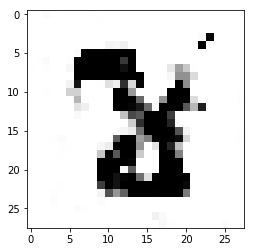

Estimate: [[ 81.56002808]]
Iteration: 48200 at 2017-07-03 01:37:15.796950


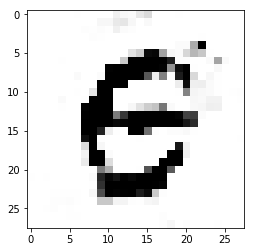

Estimate: [[-61.22319412]]
Iteration: 48300 at 2017-07-03 01:37:24.904542


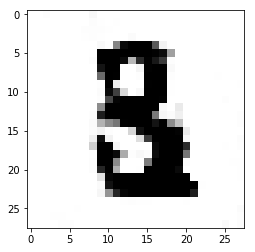

Estimate: [[ 12.56133652]]
Iteration: 48400 at 2017-07-03 01:37:33.926383


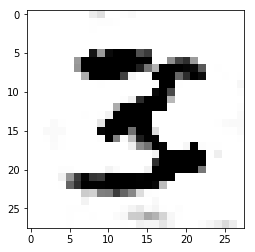

Estimate: [[ 2.0194788]]
Iteration: 48500 at 2017-07-03 01:37:44.073282


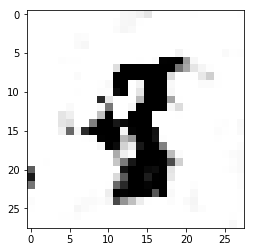

Estimate: [[-140.15104675]]
Iteration: 48600 at 2017-07-03 01:37:53.141819


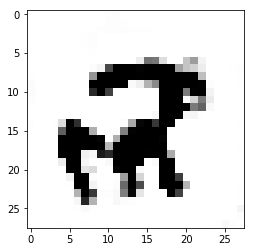

Estimate: [[ 88.90465546]]
Iteration: 48700 at 2017-07-03 01:38:02.363540


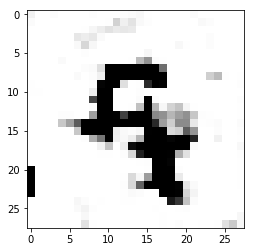

Estimate: [[-37.95123291]]
Iteration: 48800 at 2017-07-03 01:38:11.537417


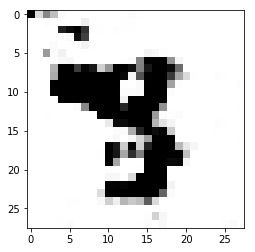

Estimate: [[ 241.55427551]]
Iteration: 48900 at 2017-07-03 01:38:20.576080


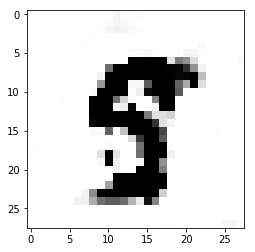

Estimate: [[ 9.60101318]]
Iteration: 51400 at 2017-07-03 01:42:10.541362


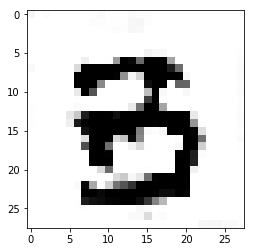

Estimate: [[ 11.52793503]]
Iteration: 51500 at 2017-07-03 01:42:19.782631


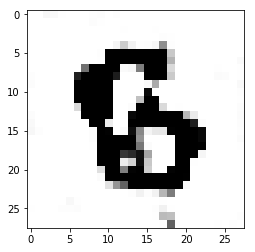

Estimate: [[ 83.65209198]]
Iteration: 51600 at 2017-07-03 01:42:29.006322


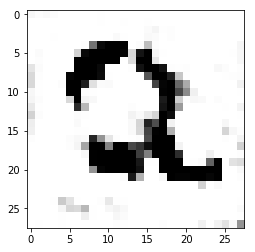

Estimate: [[-11.75320721]]
Iteration: 51700 at 2017-07-03 01:42:38.445490


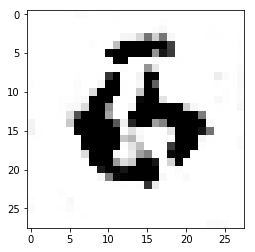

Estimate: [[-55.57554626]]
Iteration: 51800 at 2017-07-03 01:42:47.754874


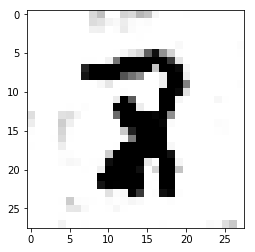

Estimate: [[ 5.01472569]]
Iteration: 51900 at 2017-07-03 01:42:56.982243


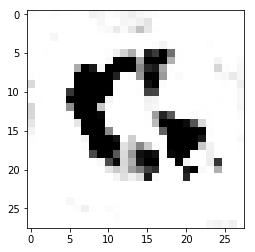

Estimate: [[-6.97255516]]
Iteration: 52000 at 2017-07-03 01:43:06.226890


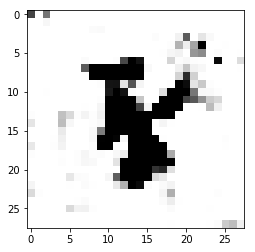

Estimate: [[-51.50401306]]
Iteration: 52100 at 2017-07-03 01:43:15.503756


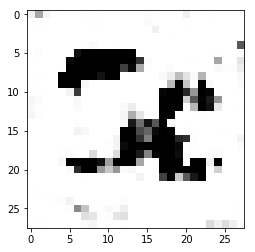

Estimate: [[ 52.91733932]]
Iteration: 52200 at 2017-07-03 01:43:24.874442


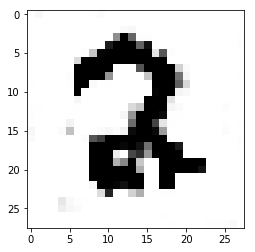

Estimate: [[-14.38253307]]
Iteration: 52300 at 2017-07-03 01:43:34.137717


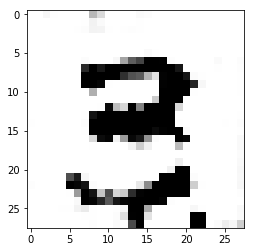

Estimate: [[-62.82108307]]
Iteration: 52400 at 2017-07-03 01:43:43.365272


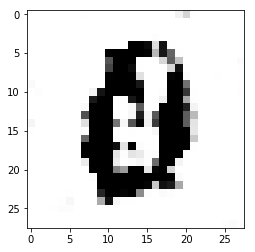

Estimate: [[ 36.72263718]]
Iteration: 52500 at 2017-07-03 01:43:52.684621


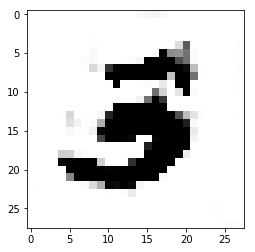

Estimate: [[-31.15217018]]
Iteration: 52600 at 2017-07-03 01:44:01.995416


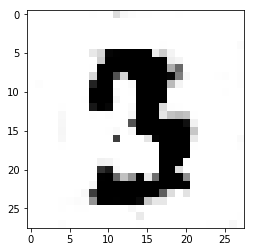

Estimate: [[ 19.15133286]]
Iteration: 52700 at 2017-07-03 01:44:11.480843


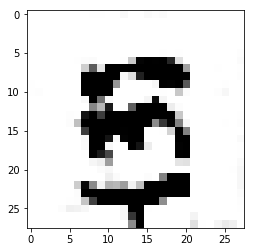

Estimate: [[-104.42308044]]
Iteration: 52800 at 2017-07-03 01:44:20.757106


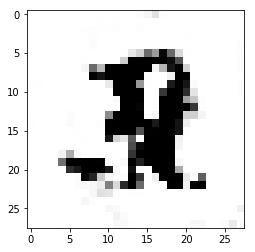

Estimate: [[-75.92288971]]
Iteration: 52900 at 2017-07-03 01:44:30.082584


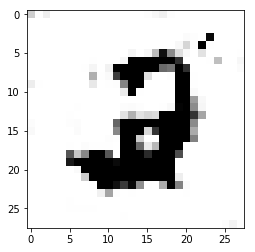

Estimate: [[ 28.59632874]]
Iteration: 53000 at 2017-07-03 01:44:39.352179


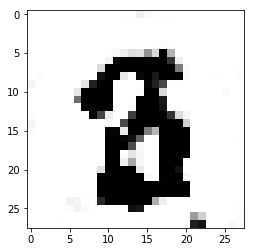

Estimate: [[ 28.40001297]]
Iteration: 53100 at 2017-07-03 01:44:48.676686


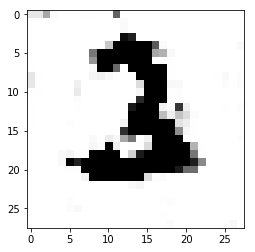

Estimate: [[ 37.93419266]]
Iteration: 53200 at 2017-07-03 01:44:58.148540


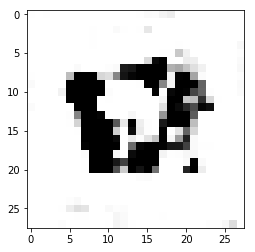

Estimate: [[-11.13492966]]
Iteration: 53300 at 2017-07-03 01:45:07.468848


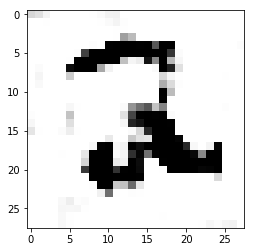

Estimate: [[ 121.61911774]]
Iteration: 53400 at 2017-07-03 01:45:16.763112


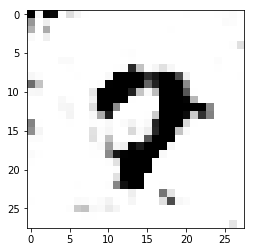

Estimate: [[-56.17657471]]
Iteration: 53500 at 2017-07-03 01:45:26.120063


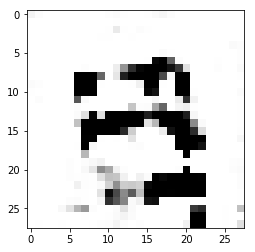

Estimate: [[-119.50213623]]
Iteration: 53600 at 2017-07-03 01:45:35.431799


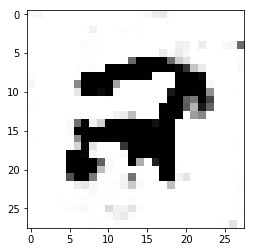

Estimate: [[ 118.18448639]]
Iteration: 53700 at 2017-07-03 01:45:44.785973


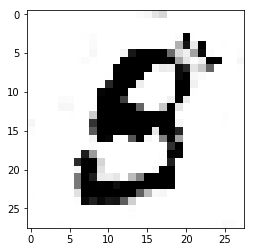

Estimate: [[ 69.16133881]]
Iteration: 53800 at 2017-07-03 01:45:54.104199


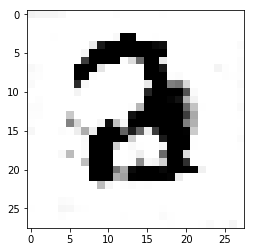

Estimate: [[-48.38726044]]
Iteration: 53900 at 2017-07-03 01:46:03.423943


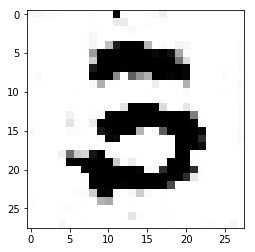

Estimate: [[-26.93542862]]
Iteration: 54000 at 2017-07-03 01:46:12.893828


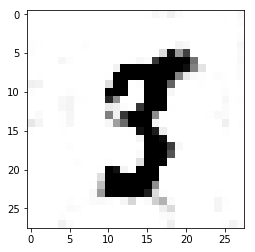

Estimate: [[-5.50451708]]
Iteration: 54100 at 2017-07-03 01:46:22.307332


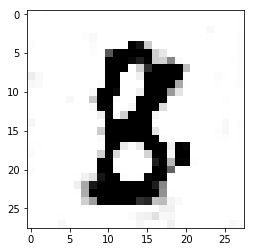

Estimate: [[ 94.08682251]]
Iteration: 54200 at 2017-07-03 01:46:31.813102


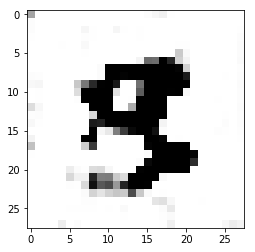

Estimate: [[-68.15837097]]
Iteration: 54300 at 2017-07-03 01:46:41.290552


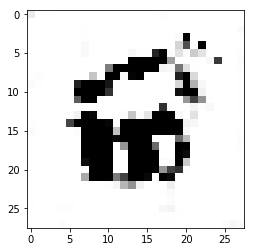

Estimate: [[-7.59154797]]
Iteration: 54400 at 2017-07-03 01:46:50.691623


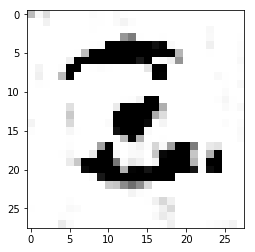

Estimate: [[ 15.75219536]]
Iteration: 54500 at 2017-07-03 01:47:00.082393


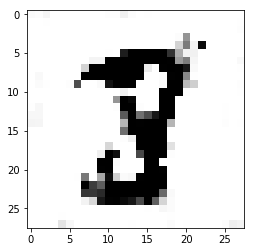

Estimate: [[ 17.4585495]]
Iteration: 54600 at 2017-07-03 01:47:09.510631


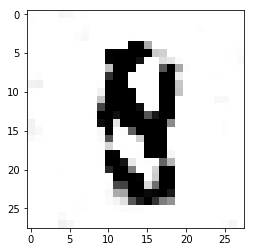

Estimate: [[-6.47605324]]
Iteration: 54700 at 2017-07-03 01:47:19.066601


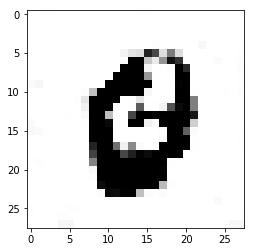

Estimate: [[-34.83073807]]
Iteration: 54800 at 2017-07-03 01:47:28.471422


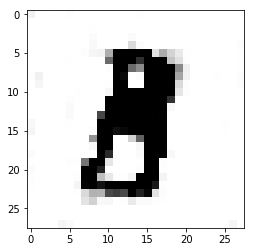

Estimate: [[ 28.35639763]]
Iteration: 54900 at 2017-07-03 01:47:37.837553


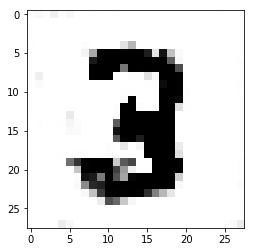

Estimate: [[ 16.61096573]]
Iteration: 55000 at 2017-07-03 01:47:47.244187


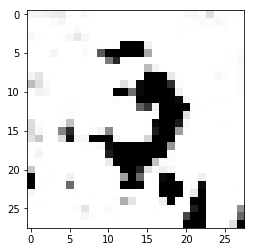

Estimate: [[-213.53367615]]
Iteration: 55100 at 2017-07-03 01:47:56.646121


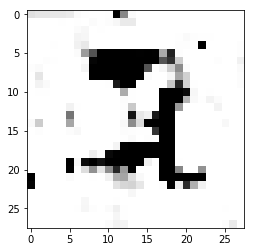

Estimate: [[ 3.08480334]]
Iteration: 55200 at 2017-07-03 01:48:06.254483


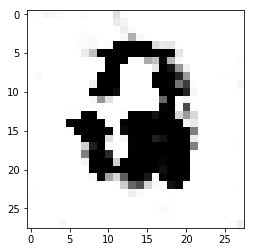

Estimate: [[ 32.66429901]]
Iteration: 55300 at 2017-07-03 01:48:15.745124


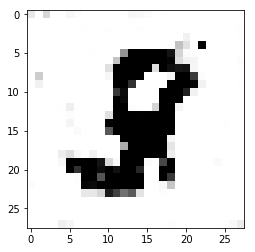

Estimate: [[ 89.26636505]]
Iteration: 55400 at 2017-07-03 01:48:25.269699


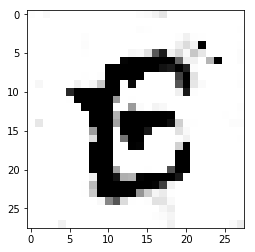

Estimate: [[ 66.32509613]]
Iteration: 55500 at 2017-07-03 01:48:34.700343


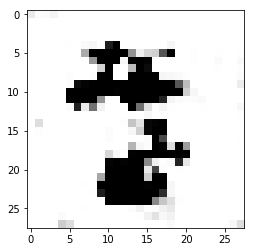

Estimate: [[-101.56895447]]
Iteration: 55600 at 2017-07-03 01:48:44.155206


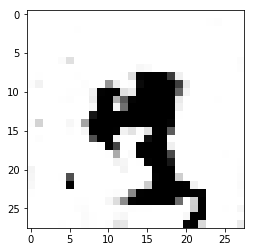

Estimate: [[-32.120224]]
Iteration: 55700 at 2017-07-03 01:48:53.765780


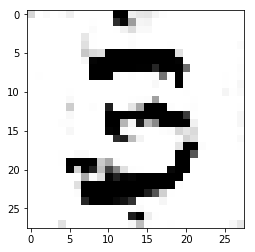

Estimate: [[ 1.49900222]]
Iteration: 55800 at 2017-07-03 01:49:03.176133


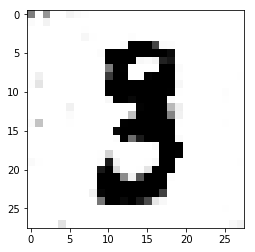

Estimate: [[-59.35855865]]
Iteration: 55900 at 2017-07-03 01:49:12.663467


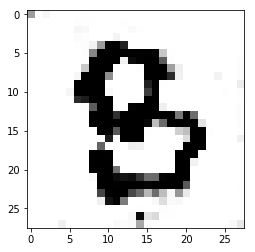

Estimate: [[ 35.47652054]]
Iteration: 56000 at 2017-07-03 01:49:22.160117


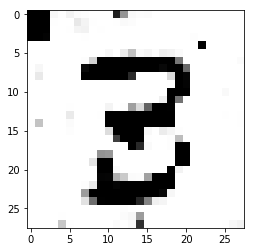

Estimate: [[ 50.21653748]]
Iteration: 56100 at 2017-07-03 01:49:31.636391


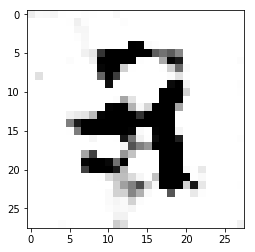

Estimate: [[ 34.67326736]]
Iteration: 56200 at 2017-07-03 01:49:41.223392


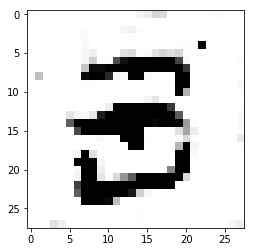

Estimate: [[ 11.32405663]]
Iteration: 56300 at 2017-07-03 01:49:50.754337


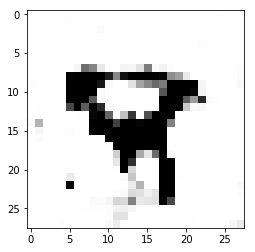

Estimate: [[ 16.13484192]]
Iteration: 56400 at 2017-07-03 01:50:00.257062


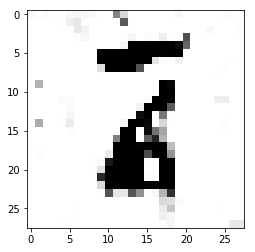

Estimate: [[ 22.62348366]]
Iteration: 56500 at 2017-07-03 01:50:09.853886


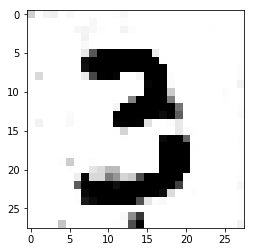

Estimate: [[ 62.09172058]]
Iteration: 56600 at 2017-07-03 01:50:19.414288


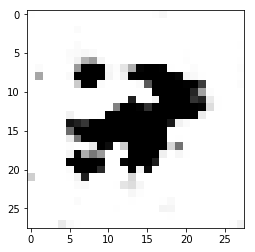

Estimate: [[-85.27514648]]
Iteration: 56700 at 2017-07-03 01:50:29.088074


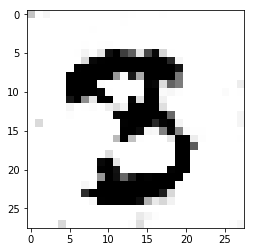

Estimate: [[-76.76454163]]
Iteration: 56800 at 2017-07-03 01:50:39.938082


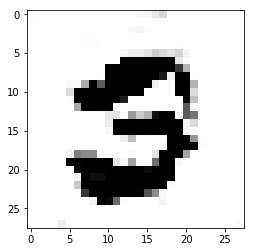

Estimate: [[-28.09024429]]
Iteration: 56900 at 2017-07-03 01:50:49.453122


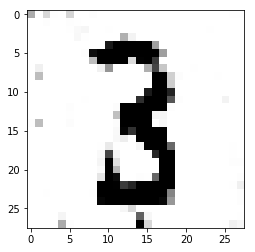

Estimate: [[-16.02456284]]
Iteration: 57000 at 2017-07-03 01:50:59.026134


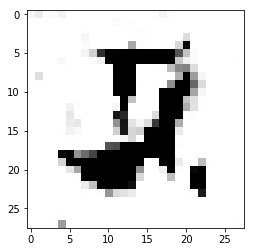

Estimate: [[-65.39187622]]
Iteration: 57100 at 2017-07-03 01:51:08.612327


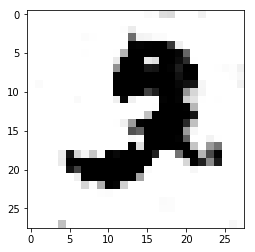

Estimate: [[ 4.00175571]]
Iteration: 57200 at 2017-07-03 01:51:18.390233


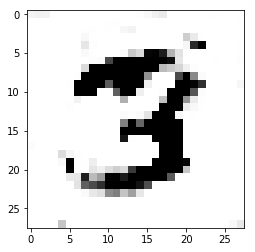

Estimate: [[ 8.88853455]]
Iteration: 57300 at 2017-07-03 01:51:27.976243


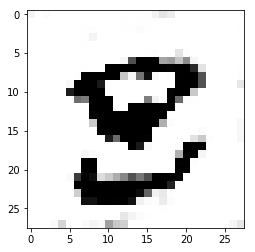

Estimate: [[-1.49631166]]
Iteration: 57400 at 2017-07-03 01:51:37.562145


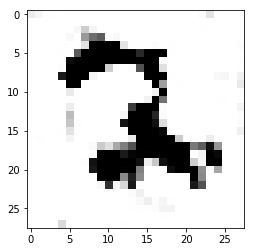

Estimate: [[ 54.38479233]]
Iteration: 57500 at 2017-07-03 01:51:47.144410


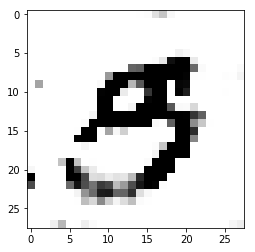

Estimate: [[ 47.35108185]]
Iteration: 57600 at 2017-07-03 01:51:56.825996


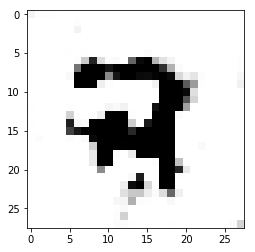

Estimate: [[ 8.58641624]]
Iteration: 57700 at 2017-07-03 01:52:06.668581


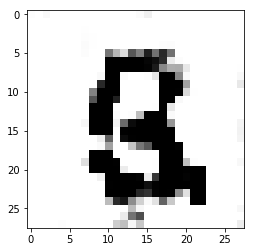

Estimate: [[-33.44762802]]
Iteration: 57800 at 2017-07-03 01:52:16.321060


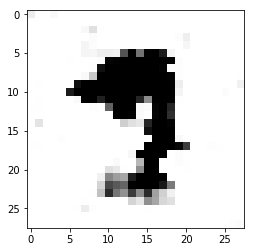

Estimate: [[-67.11984253]]
Iteration: 57900 at 2017-07-03 01:52:25.894921


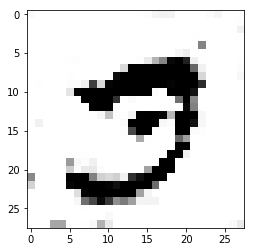

Estimate: [[ 90.52915955]]
Iteration: 58000 at 2017-07-03 01:52:35.578365


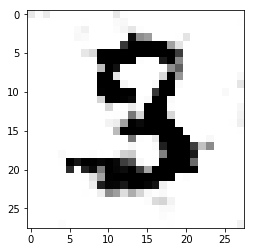

Estimate: [[-86.39232635]]
Iteration: 58100 at 2017-07-03 01:52:45.260569


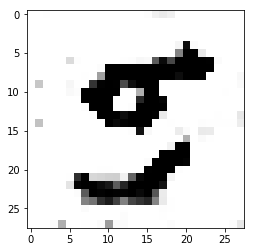

Estimate: [[ 35.78233719]]
Iteration: 58200 at 2017-07-03 01:52:55.111039


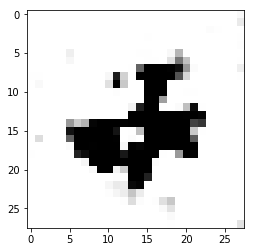

Estimate: [[ 71.69606018]]
Iteration: 58300 at 2017-07-03 01:53:04.779580


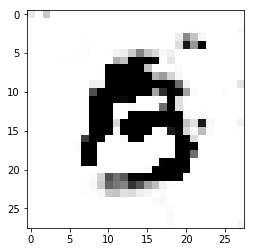

Estimate: [[ 17.45204926]]
Iteration: 58400 at 2017-07-03 01:53:14.457455


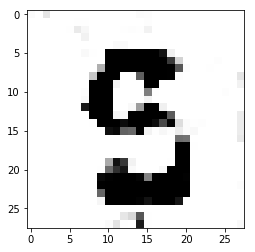

Estimate: [[-18.65642548]]
Iteration: 58500 at 2017-07-03 01:53:24.103518


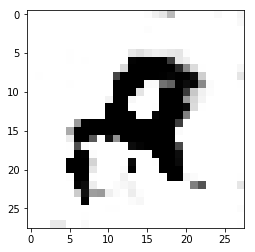

Estimate: [[ 55.02825165]]
Iteration: 58600 at 2017-07-03 01:53:33.720798


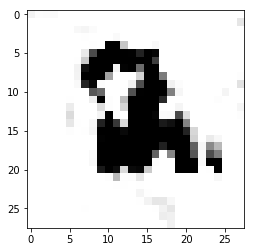

Estimate: [[-29.59280014]]
Iteration: 58700 at 2017-07-03 01:53:43.548067


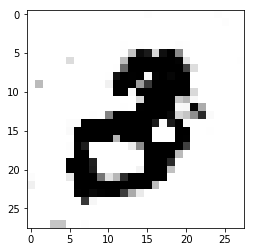

Estimate: [[ 9.22068119]]
Iteration: 58800 at 2017-07-03 01:53:53.205501


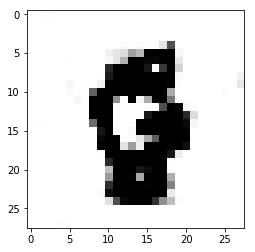

Estimate: [[-32.90281296]]
Iteration: 58900 at 2017-07-03 01:54:02.831497


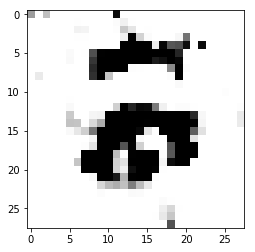

Estimate: [[ 5.7982254]]
Iteration: 59000 at 2017-07-03 01:54:12.525505


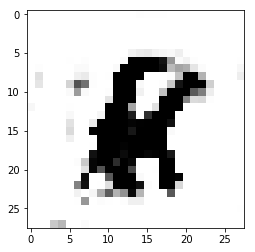

Estimate: [[-79.49767303]]
Iteration: 59100 at 2017-07-03 01:54:22.138438


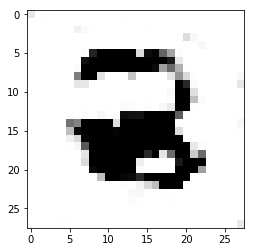

Estimate: [[-87.88652802]]
Iteration: 59200 at 2017-07-03 01:54:31.889242


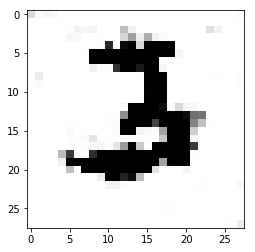

Estimate: [[ 30.48776627]]
Iteration: 59300 at 2017-07-03 01:54:41.556676


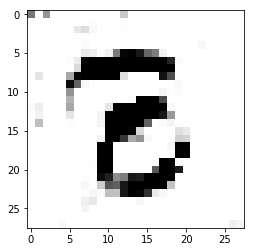

Estimate: [[-49.77763367]]
Iteration: 59400 at 2017-07-03 01:54:51.201682


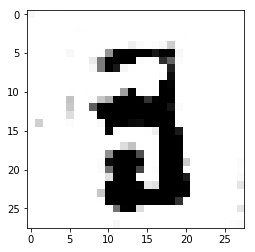

Estimate: [[ 17.74598885]]
Iteration: 59500 at 2017-07-03 01:55:00.829587


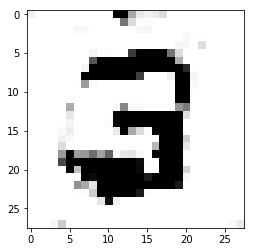

Estimate: [[ 49.06690979]]
Iteration: 59600 at 2017-07-03 01:55:10.534449


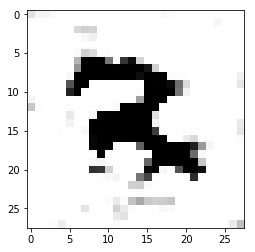

Estimate: [[-86.12985992]]
Iteration: 59700 at 2017-07-03 01:55:20.325573


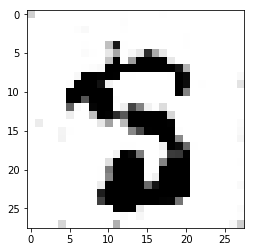

Estimate: [[-94.33740997]]
Iteration: 59800 at 2017-07-03 01:55:30.065783


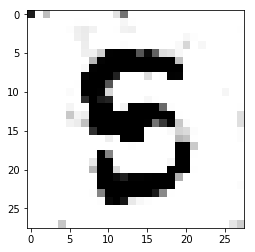

Estimate: [[-32.36572647]]
Iteration: 59900 at 2017-07-03 01:55:39.770354


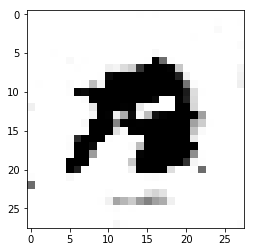

Estimate: [[-98.57693481]]
Iteration: 60000 at 2017-07-03 01:55:49.542338


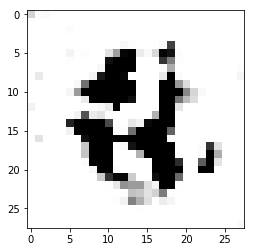

Estimate: [[ 44.86639404]]
Iteration: 60100 at 2017-07-03 01:55:59.198120


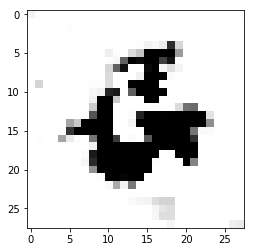

Estimate: [[-0.14737344]]
Iteration: 60200 at 2017-07-03 01:56:09.107595


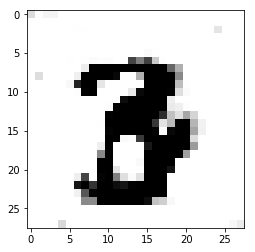

Estimate: [[-35.5557518]]
Iteration: 60300 at 2017-07-03 01:56:18.824617


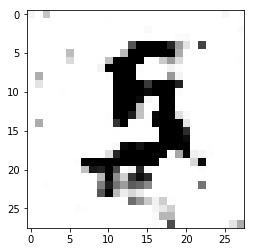

Estimate: [[-52.06402206]]
Iteration: 60400 at 2017-07-03 01:56:28.472304


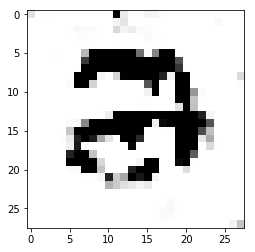

Estimate: [[-88.98365784]]
Iteration: 60500 at 2017-07-03 01:56:38.165264


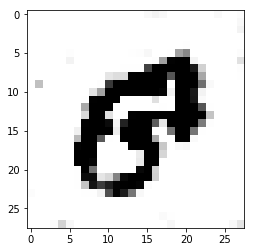

Estimate: [[ 9.44563007]]
Iteration: 60600 at 2017-07-03 01:56:47.844090


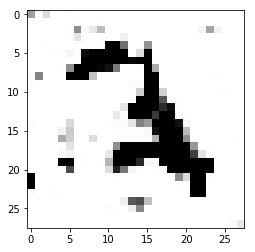

Estimate: [[ 35.56612778]]
Iteration: 60700 at 2017-07-03 01:56:57.644978


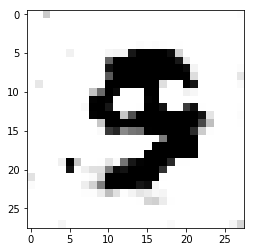

Estimate: [[-125.86975861]]
Iteration: 60800 at 2017-07-03 01:57:07.369155


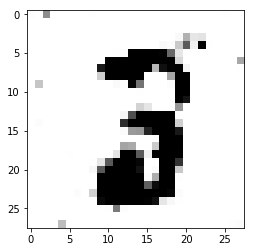

Estimate: [[ 103.03569794]]
Iteration: 60900 at 2017-07-03 01:57:17.149649


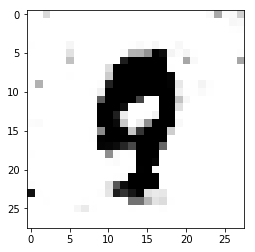

Estimate: [[ 4.46837759]]
Iteration: 61000 at 2017-07-03 01:57:26.854002


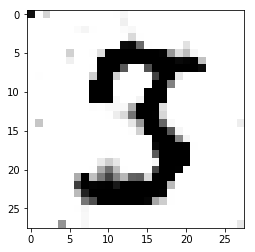

Estimate: [[ 29.47136116]]
Iteration: 61100 at 2017-07-03 01:57:36.600697


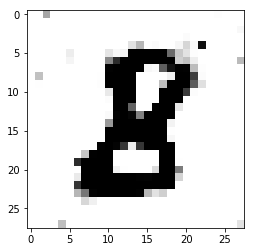

Estimate: [[ 33.60417175]]
Iteration: 61200 at 2017-07-03 01:57:46.494301


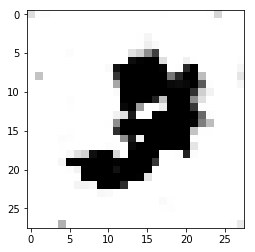

Estimate: [[ 6.01076317]]
Iteration: 61300 at 2017-07-03 01:57:56.298475


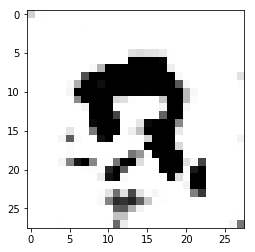

Estimate: [[-105.65618896]]
Iteration: 61400 at 2017-07-03 01:58:06.097104


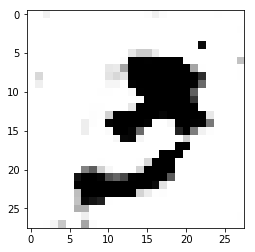

Estimate: [[ 54.37226105]]
Iteration: 61500 at 2017-07-03 01:58:15.888909


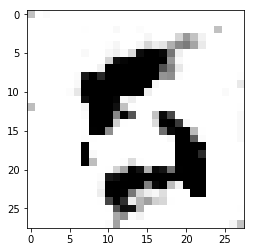

Estimate: [[-33.69026184]]
Iteration: 61600 at 2017-07-03 01:58:25.707411


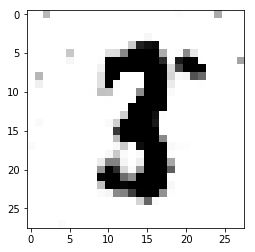

Estimate: [[ 131.29814148]]
Iteration: 61700 at 2017-07-03 01:58:35.608783


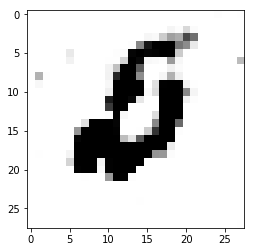

Estimate: [[ 9.53983879]]
Iteration: 61800 at 2017-07-03 01:58:45.460047


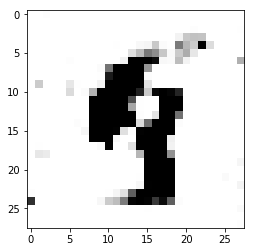

Estimate: [[ 135.34928894]]
Iteration: 61900 at 2017-07-03 01:58:55.253467


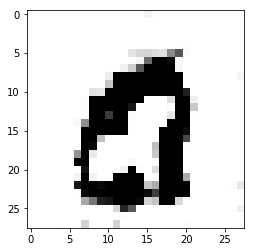

Estimate: [[ 52.88286591]]
Iteration: 62000 at 2017-07-03 01:59:05.158294


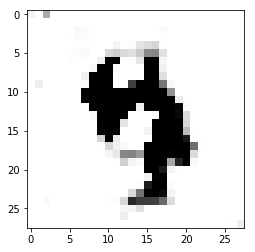

Estimate: [[ 17.79699898]]
Iteration: 62100 at 2017-07-03 01:59:14.983912


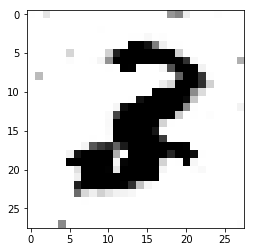

Estimate: [[ 60.38426971]]
Iteration: 62200 at 2017-07-03 01:59:24.958859


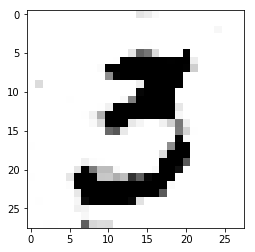

Estimate: [[-63.83825302]]
Iteration: 62300 at 2017-07-03 01:59:34.796635


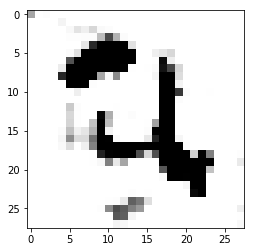

Estimate: [[-72.38143921]]
Iteration: 62400 at 2017-07-03 01:59:44.598349


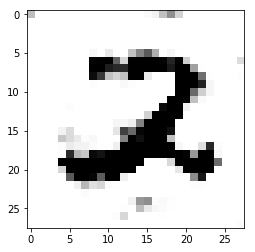

Estimate: [[ 127.11345673]]
Iteration: 62500 at 2017-07-03 01:59:54.439596


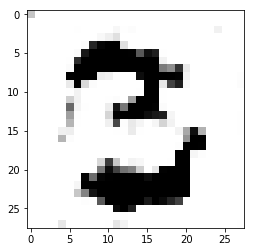

Estimate: [[-25.8195858]]
Iteration: 62600 at 2017-07-03 02:00:04.306590


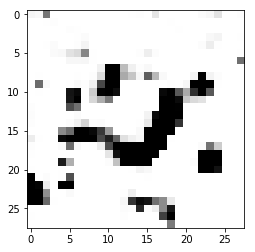

Estimate: [[ 25.84605217]]
Iteration: 62700 at 2017-07-03 02:00:14.332233


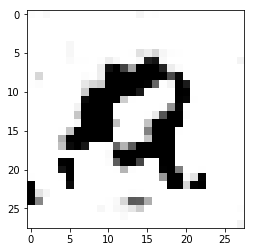

Estimate: [[-93.05119324]]
Iteration: 62800 at 2017-07-03 02:00:24.087197


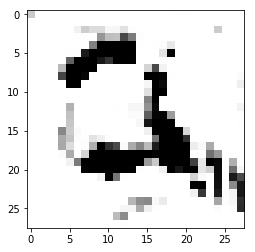

Estimate: [[-70.5459137]]
Iteration: 62900 at 2017-07-03 02:00:33.890710


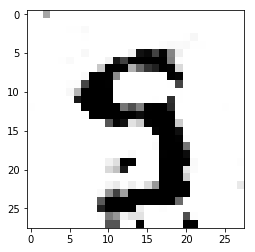

Estimate: [[ 73.55795288]]
Iteration: 63000 at 2017-07-03 02:00:43.686248


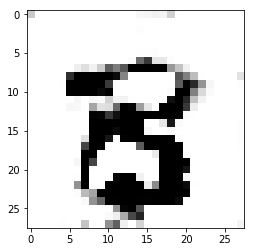

Estimate: [[-97.78653717]]
Iteration: 63100 at 2017-07-03 02:00:53.538765


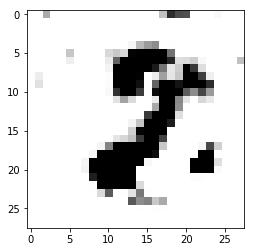

Estimate: [[-3.85978746]]
Iteration: 63200 at 2017-07-03 02:01:03.552125


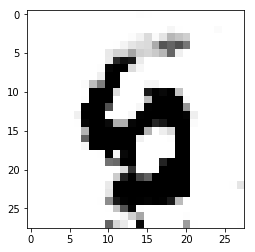

Estimate: [[ 90.63146973]]
Iteration: 63300 at 2017-07-03 02:01:13.424508


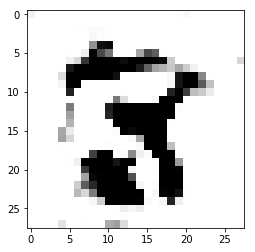

Estimate: [[-3.69024539]]
Iteration: 63400 at 2017-07-03 02:01:23.249179


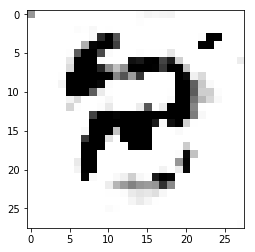

Estimate: [[-54.31583023]]
Iteration: 63500 at 2017-07-03 02:01:33.111081


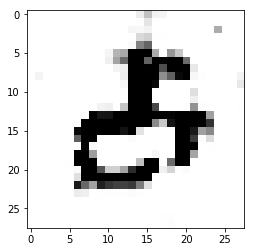

Estimate: [[ 81.39313507]]
Iteration: 63600 at 2017-07-03 02:01:43.000967


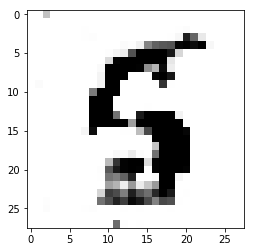

Estimate: [[ 55.73627472]]
Iteration: 63700 at 2017-07-03 02:01:53.039392


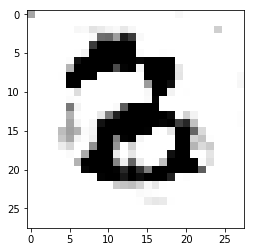

Estimate: [[-101.68444824]]
Iteration: 63800 at 2017-07-03 02:02:02.935618


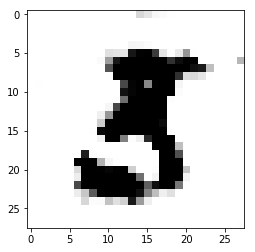

Estimate: [[ 44.16072464]]
Iteration: 63900 at 2017-07-03 02:02:13.196389


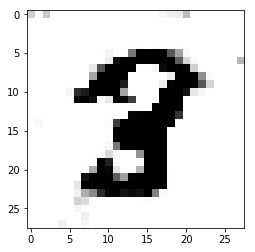

Estimate: [[-32.25722122]]
Iteration: 64000 at 2017-07-03 02:02:23.065509


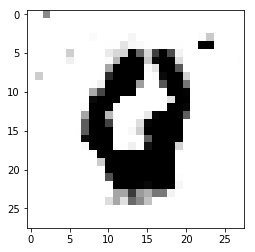

Estimate: [[-42.93436432]]
Iteration: 64100 at 2017-07-03 02:02:32.917481


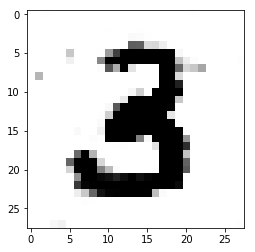

Estimate: [[-15.15750313]]
Iteration: 64200 at 2017-07-03 02:02:42.972995


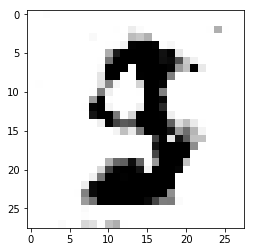

Estimate: [[-120.38595581]]
Iteration: 64300 at 2017-07-03 02:02:52.855105


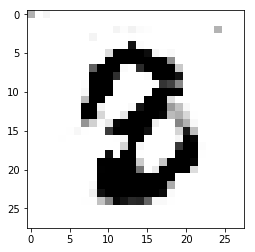

Estimate: [[-39.97261429]]
Iteration: 64400 at 2017-07-03 02:03:02.766285


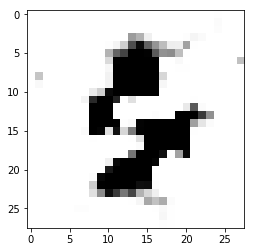

Estimate: [[-25.52882004]]
Iteration: 64500 at 2017-07-03 02:03:12.713144


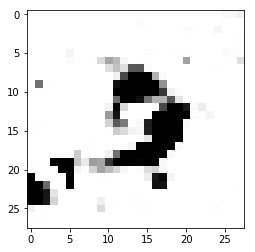

Estimate: [[-171.8465271]]
Iteration: 64600 at 2017-07-03 02:03:22.654793


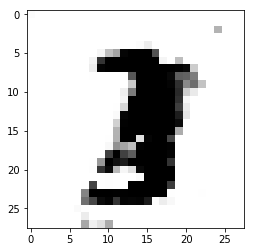

Estimate: [[ 56.09132767]]
Iteration: 64700 at 2017-07-03 02:03:32.770183


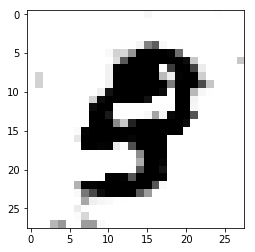

Estimate: [[ 26.75034904]]
Iteration: 64800 at 2017-07-03 02:03:42.662038


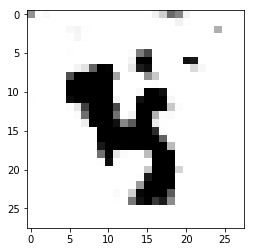

Estimate: [[ 165.26242065]]
Iteration: 64900 at 2017-07-03 02:03:52.630613


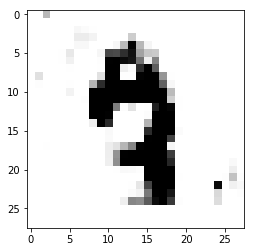

Estimate: [[ 54.93680191]]
Iteration: 65000 at 2017-07-03 02:04:02.599736


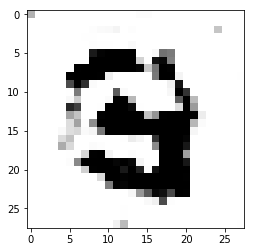

Estimate: [[-107.41229248]]
Iteration: 65100 at 2017-07-03 02:04:12.560973


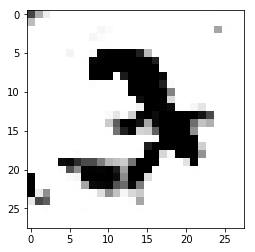

Estimate: [[ 41.74836731]]
Iteration: 65200 at 2017-07-03 02:04:22.654300


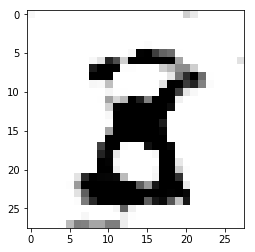

Estimate: [[ 11.78600311]]
Iteration: 65300 at 2017-07-03 02:04:32.595963


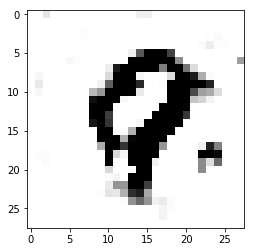

Estimate: [[ 51.75033569]]
Iteration: 65400 at 2017-07-03 02:04:42.510819


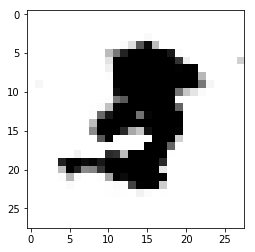

Estimate: [[ 107.71501923]]
Iteration: 65500 at 2017-07-03 02:04:52.400792


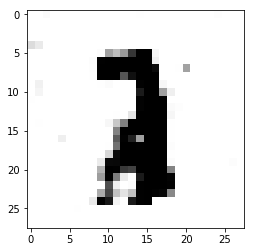

Estimate: [[ 40.42533112]]
Iteration: 65600 at 2017-07-03 02:05:02.343050


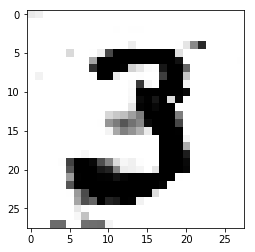

Estimate: [[-102.81787109]]
Iteration: 65700 at 2017-07-03 02:05:12.448190


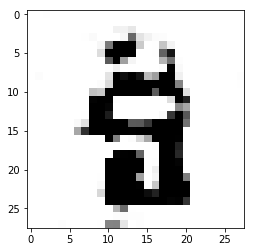

Estimate: [[ 80.41122437]]
Iteration: 65800 at 2017-07-03 02:05:22.454429


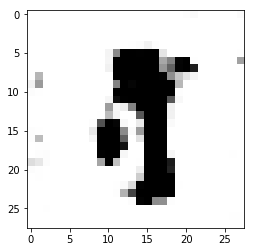

Estimate: [[ 38.87189102]]
Iteration: 65900 at 2017-07-03 02:05:32.476885


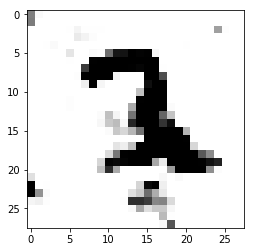

Estimate: [[-56.96032333]]
Iteration: 66000 at 2017-07-03 02:05:42.451531


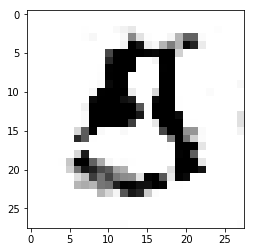

Estimate: [[-95.28456879]]
Iteration: 66100 at 2017-07-03 02:05:52.362521


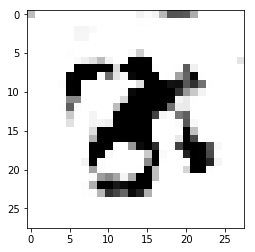

Estimate: [[ 62.46657181]]
Iteration: 66200 at 2017-07-03 02:06:04.022940


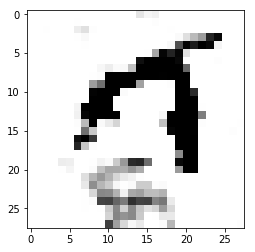

Estimate: [[ 52.31222153]]
Iteration: 66300 at 2017-07-03 02:06:14.113792


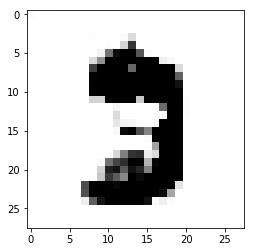

Estimate: [[ 93.29774475]]
Iteration: 66400 at 2017-07-03 02:06:24.281963


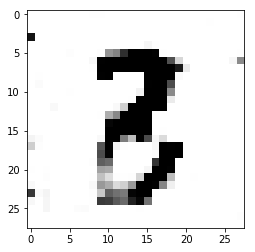

Estimate: [[-59.4073143]]
Iteration: 66500 at 2017-07-03 02:06:34.354981


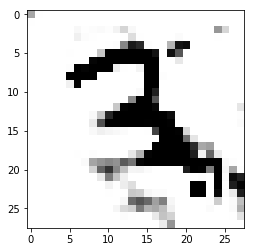

Estimate: [[ 221.22871399]]
Iteration: 66600 at 2017-07-03 02:06:44.410558


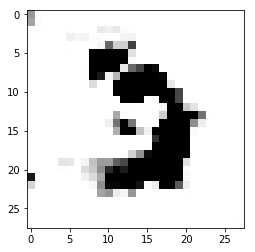

Estimate: [[-15.16256618]]
Iteration: 66700 at 2017-07-03 02:06:54.625057


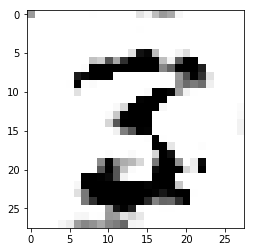

Estimate: [[-38.70018768]]
Iteration: 66800 at 2017-07-03 02:07:04.740382


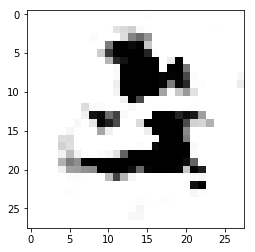

Estimate: [[-34.51231766]]
Iteration: 66900 at 2017-07-03 02:07:14.870965


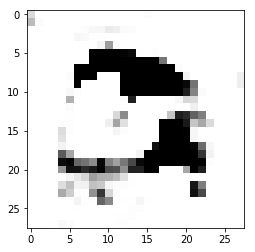

Estimate: [[ 65.56985474]]
Iteration: 67000 at 2017-07-03 02:07:24.917035


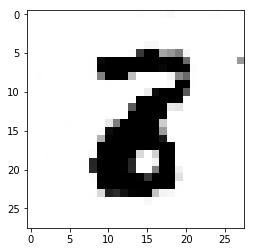

Estimate: [[ 23.43829346]]
Iteration: 67100 at 2017-07-03 02:07:35.016201


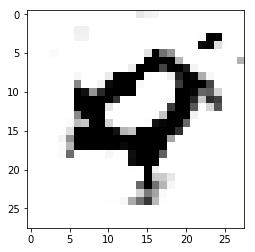

Estimate: [[ 151.28559875]]
Iteration: 67200 at 2017-07-03 02:07:45.143374


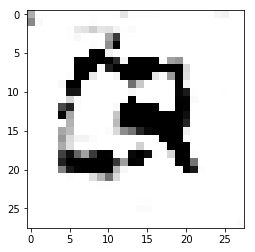

Estimate: [[-16.42506027]]
Iteration: 67300 at 2017-07-03 02:07:55.271842


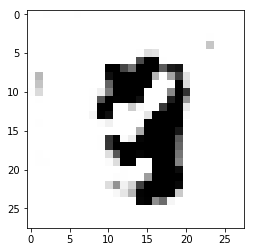

Estimate: [[-44.848629]]
Iteration: 67400 at 2017-07-03 02:08:05.425986


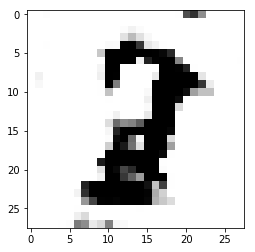

Estimate: [[ 38.32482147]]
Iteration: 67500 at 2017-07-03 02:08:15.635303


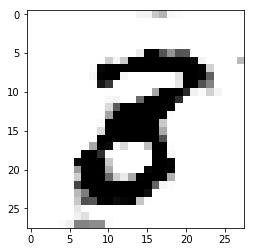

Estimate: [[ 96.06024933]]
Iteration: 67600 at 2017-07-03 02:08:25.759313


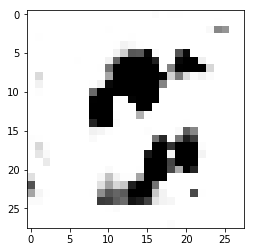

Estimate: [[-63.03735733]]
Iteration: 67700 at 2017-07-03 02:08:36.069542


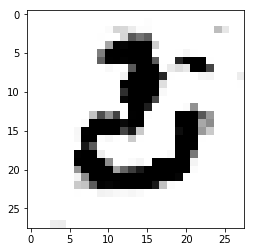

Estimate: [[ 116.784729]]
Iteration: 67800 at 2017-07-03 02:08:46.189837
Iteration: 77600 at 2017-07-03 02:25:38.777148


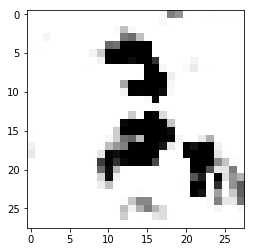

Estimate: [[-136.45587158]]
Iteration: 77700 at 2017-07-03 02:25:49.452983


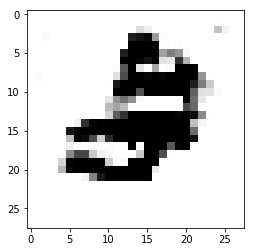

Estimate: [[ 174.51643372]]
Iteration: 77800 at 2017-07-03 02:25:59.936972


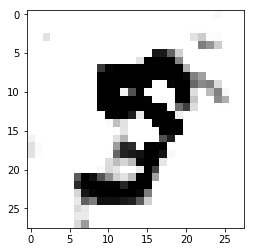

Estimate: [[-53.6709938]]
Iteration: 77900 at 2017-07-03 02:26:10.527479


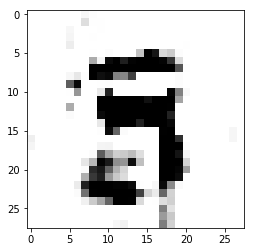

Estimate: [[-44.11337662]]
Iteration: 78000 at 2017-07-03 02:26:21.096363


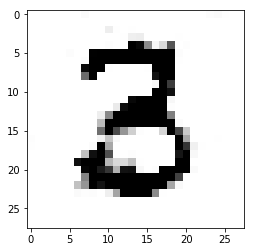

Estimate: [[ 185.45314026]]
Iteration: 78100 at 2017-07-03 02:26:31.677195


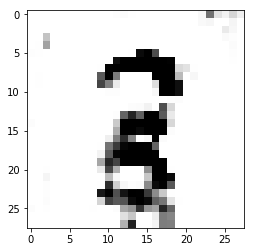

Estimate: [[-156.88813782]]
Iteration: 78200 at 2017-07-03 02:26:42.283766


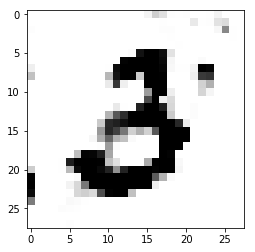

Estimate: [[-103.69618988]]
Iteration: 78300 at 2017-07-03 02:26:52.863311


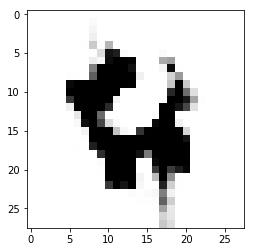

Estimate: [[ 231.94902039]]
Iteration: 78400 at 2017-07-03 02:27:03.368612


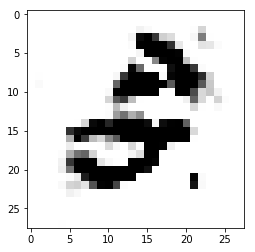

Estimate: [[-31.28681374]]
Iteration: 78500 at 2017-07-03 02:27:14.037378


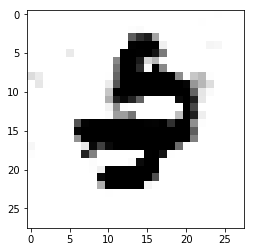

Estimate: [[ 162.40911865]]
Iteration: 78600 at 2017-07-03 02:27:24.604731


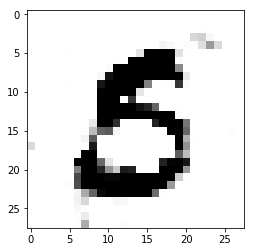

Estimate: [[-52.09595108]]
Iteration: 78700 at 2017-07-03 02:27:35.216379


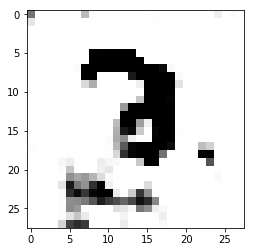

Estimate: [[-79.09907532]]
Iteration: 78800 at 2017-07-03 02:27:45.763910


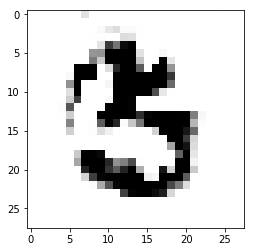

Estimate: [[-25.92485237]]
Iteration: 78900 at 2017-07-03 02:27:56.276894


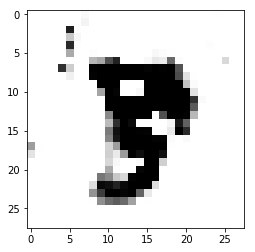

Estimate: [[ 45.59272385]]
Iteration: 79000 at 2017-07-03 02:28:06.877600


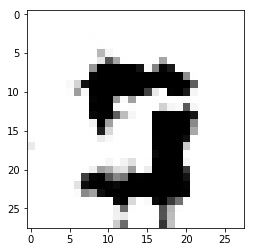

Estimate: [[ 276.62689209]]
Iteration: 79100 at 2017-07-03 02:28:18.185434


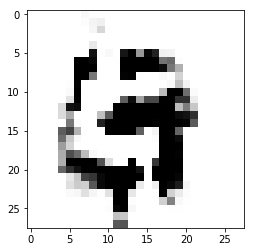

Estimate: [[ 6.81501389]]
Iteration: 79200 at 2017-07-03 02:28:28.920497


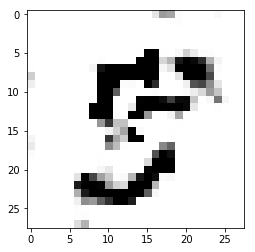

Estimate: [[-65.90510559]]
Iteration: 79300 at 2017-07-03 02:28:39.460868


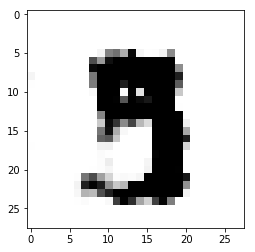

Estimate: [[ 207.72288513]]
Iteration: 79400 at 2017-07-03 02:28:50.020195


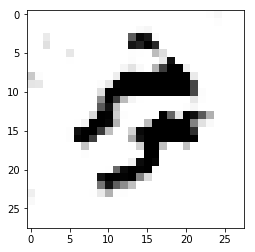

Estimate: [[ 4.79231024]]
Iteration: 79500 at 2017-07-03 02:29:00.565061


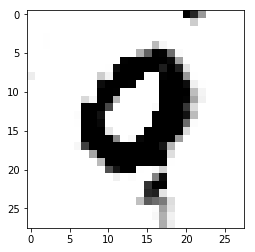

Estimate: [[ 162.09342957]]
Iteration: 79600 at 2017-07-03 02:29:11.231996


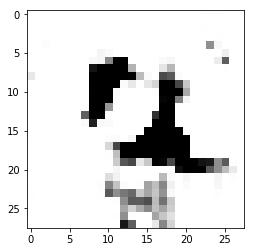

Estimate: [[-168.03656006]]
Iteration: 79700 at 2017-07-03 02:29:21.995632


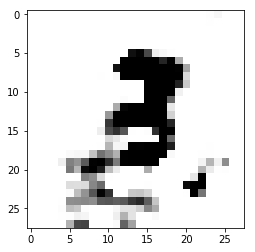

Estimate: [[-46.66082764]]
Iteration: 79800 at 2017-07-03 02:29:32.569488


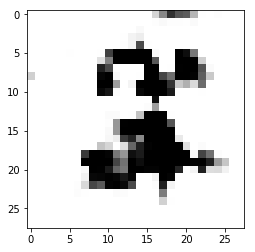

Estimate: [[-222.87564087]]
Iteration: 79900 at 2017-07-03 02:29:43.098328


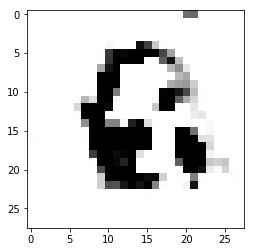

Estimate: [[-7.43646431]]
Iteration: 80000 at 2017-07-03 02:29:53.625260


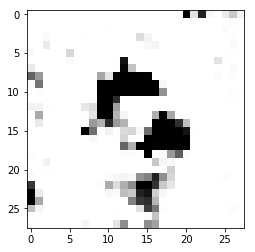

Estimate: [[-290.29104614]]
Iteration: 80100 at 2017-07-03 02:30:04.232153


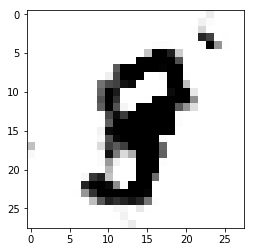

Estimate: [[ 46.21600342]]
Iteration: 80200 at 2017-07-03 02:30:14.944968


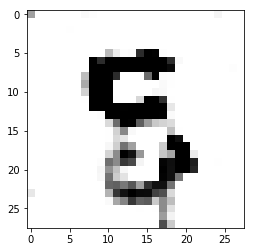

Estimate: [[-104.02311707]]
Iteration: 80300 at 2017-07-03 02:30:25.551214


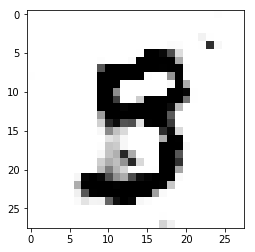

Estimate: [[ 31.89301872]]
Iteration: 80400 at 2017-07-03 02:30:36.121415


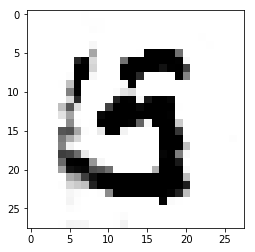

Estimate: [[-140.79943848]]
Iteration: 80500 at 2017-07-03 02:30:46.772820


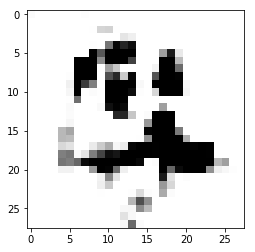

Estimate: [[-181.2775116]]
Iteration: 80600 at 2017-07-03 02:30:57.376118


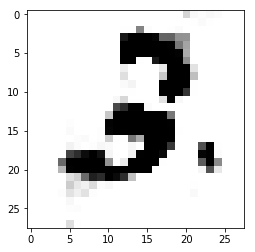

Estimate: [[ 68.10878754]]
Iteration: 80700 at 2017-07-03 02:31:08.238036


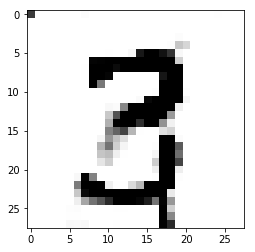

Estimate: [[ 39.24585724]]
Iteration: 80800 at 2017-07-03 02:31:18.913668


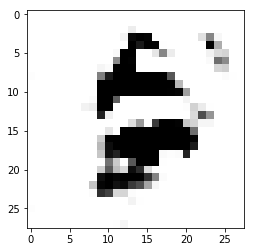

Estimate: [[-134.41882324]]
Iteration: 80900 at 2017-07-03 02:31:29.610903


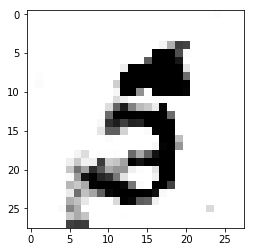

Estimate: [[-28.52502632]]
Iteration: 81000 at 2017-07-03 02:31:40.295894


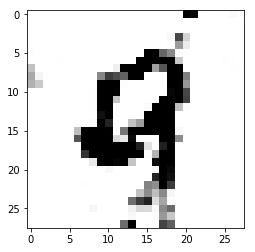

Estimate: [[ 15.85974312]]
Iteration: 81100 at 2017-07-03 02:31:50.923631


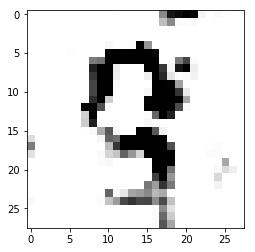

Estimate: [[ 22.89618111]]
Iteration: 81200 at 2017-07-03 02:32:01.838812


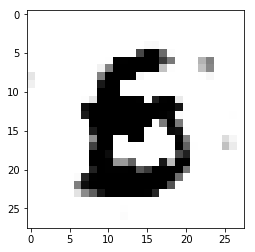

Estimate: [[ 127.97122192]]
Iteration: 81300 at 2017-07-03 02:32:12.595678


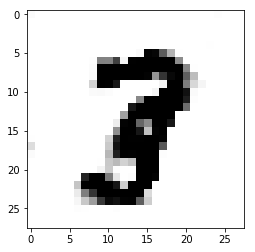

Estimate: [[ 43.94246292]]
Iteration: 81400 at 2017-07-03 02:32:23.300866


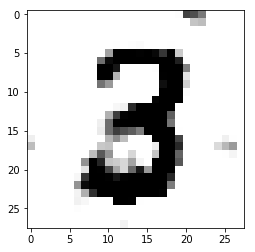

Estimate: [[-27.80722237]]
Iteration: 81500 at 2017-07-03 02:32:34.015438


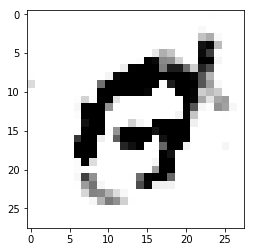

Estimate: [[ 8.0178957]]
Iteration: 81600 at 2017-07-03 02:32:44.736540


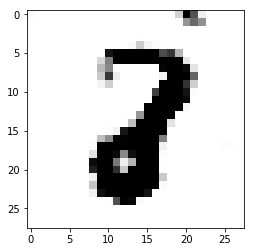

Estimate: [[ 49.16828156]]
Iteration: 81700 at 2017-07-03 02:32:55.663645


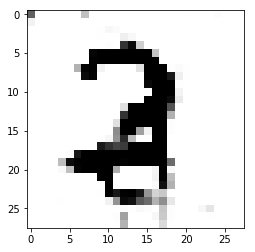

Estimate: [[ 223.28424072]]
Iteration: 81800 at 2017-07-03 02:33:06.438108


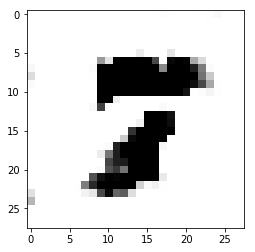

Estimate: [[-133.76585388]]
Iteration: 81900 at 2017-07-03 02:33:17.119583


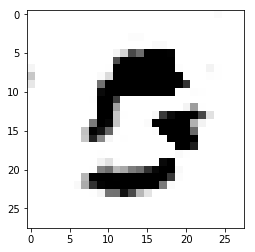

Estimate: [[ 82.77359009]]
Iteration: 82000 at 2017-07-03 02:33:27.809469


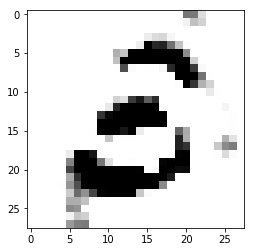

Estimate: [[-149.95368958]]
Iteration: 82100 at 2017-07-03 02:33:38.489517


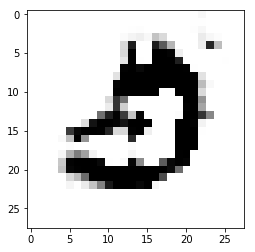

Estimate: [[ 32.92647171]]
Iteration: 82200 at 2017-07-03 02:33:49.342933


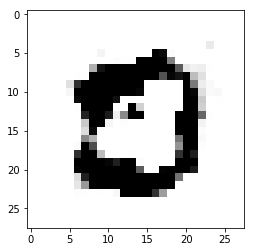

Estimate: [[ 114.95856476]]
Iteration: 82300 at 2017-07-03 02:34:00.111111


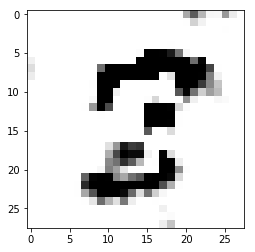

Estimate: [[ 64.45600891]]
Iteration: 82400 at 2017-07-03 02:34:10.802618


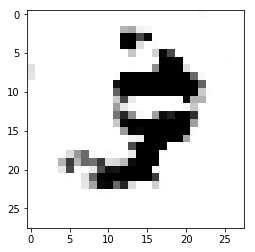

Estimate: [[-69.1876297]]
Iteration: 82500 at 2017-07-03 02:34:21.583312


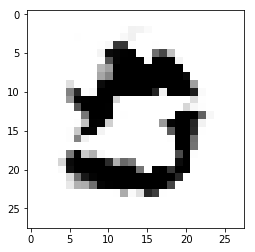

Estimate: [[ 216.71026611]]
Iteration: 82600 at 2017-07-03 02:34:32.354890


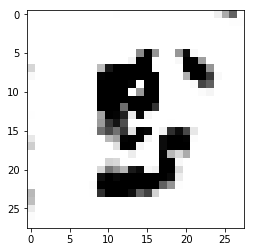

Estimate: [[-91.23019409]]
Iteration: 82700 at 2017-07-03 02:34:43.168890


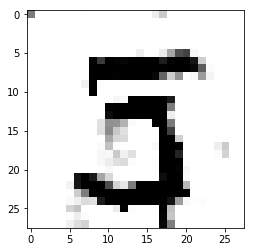

Estimate: [[ 140.07688904]]
Iteration: 82800 at 2017-07-03 02:34:54.072413


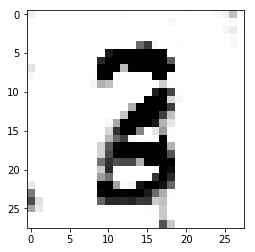

Estimate: [[-16.08957481]]
Iteration: 82900 at 2017-07-03 02:35:04.991337


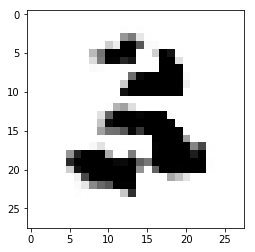

Estimate: [[-14.80535984]]
Iteration: 83000 at 2017-07-03 02:35:15.730501


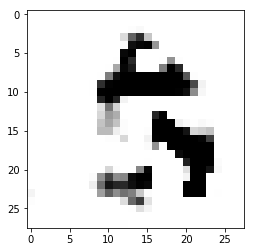

Estimate: [[ 173.15553284]]
Iteration: 83100 at 2017-07-03 02:35:26.457501


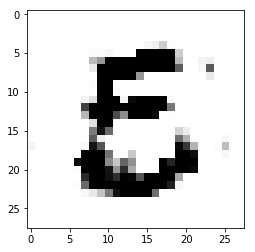

Estimate: [[ 68.75238037]]
Iteration: 83200 at 2017-07-03 02:35:37.352792


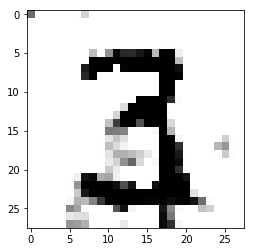

Estimate: [[-0.75380242]]
Iteration: 83300 at 2017-07-03 02:35:48.287526


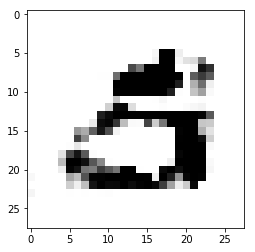

Estimate: [[-94.74737549]]
Iteration: 83400 at 2017-07-03 02:35:59.100090


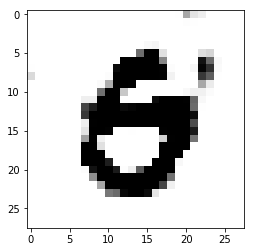

Estimate: [[ 114.27619171]]
Iteration: 83500 at 2017-07-03 02:36:09.932829


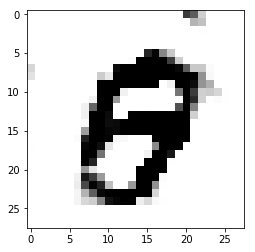

Estimate: [[ 8.79344559]]
Iteration: 83600 at 2017-07-03 02:36:20.874869


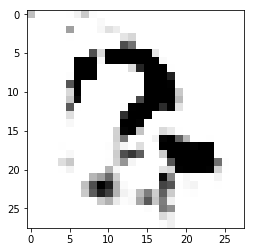

Estimate: [[ 91.13768005]]
Iteration: 83700 at 2017-07-03 02:36:31.857119


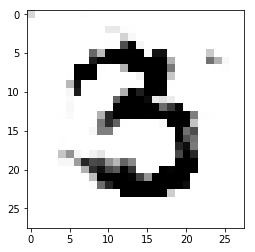

Estimate: [[-135.4675293]]
Iteration: 83800 at 2017-07-03 02:36:42.647418


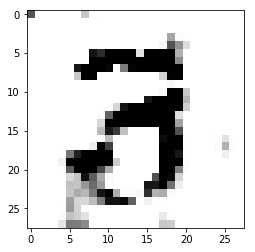

Estimate: [[ 159.22543335]]
Iteration: 83900 at 2017-07-03 02:36:53.394509


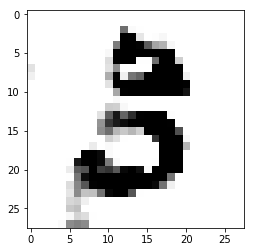

Estimate: [[-14.92668343]]
Iteration: 84000 at 2017-07-03 02:37:04.252003


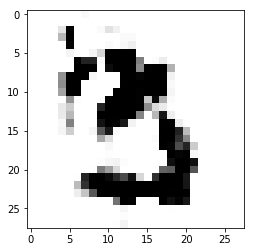

Estimate: [[-141.68916321]]
Iteration: 84100 at 2017-07-03 02:37:15.084858


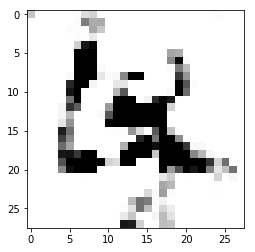

Estimate: [[ 38.007061]]
Iteration: 84200 at 2017-07-03 02:37:26.049982


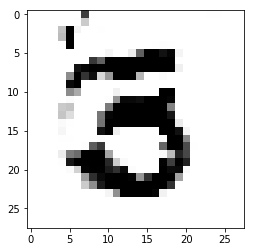

Estimate: [[ 28.43090439]]
Iteration: 84300 at 2017-07-03 02:37:36.802188


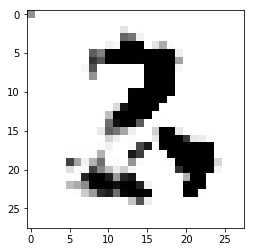

Estimate: [[ 101.14942169]]
Iteration: 84400 at 2017-07-03 02:37:47.602180


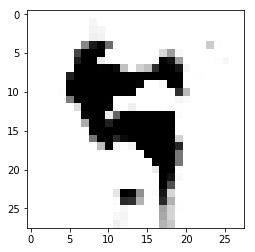

Estimate: [[ 58.32081604]]
Iteration: 84500 at 2017-07-03 02:37:58.418271


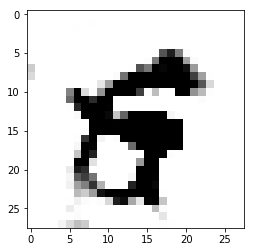

Estimate: [[ 191.8936615]]
Iteration: 84600 at 2017-07-03 02:38:09.348231


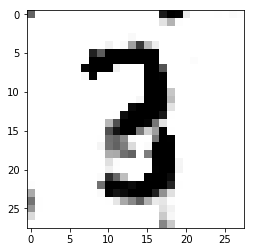

Estimate: [[ 62.28455734]]
Iteration: 84700 at 2017-07-03 02:38:20.221794


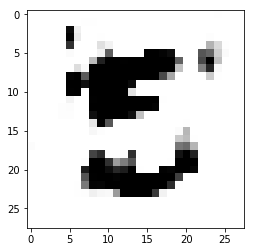

Estimate: [[ 146.43556213]]
Iteration: 84800 at 2017-07-03 02:38:30.985494


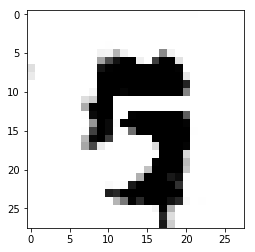

Estimate: [[ 22.94220734]]
Iteration: 84900 at 2017-07-03 02:38:41.805565


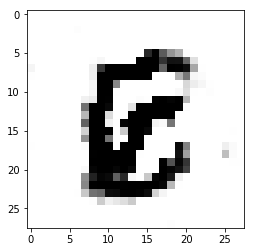

Estimate: [[-68.9473877]]
Iteration: 85000 at 2017-07-03 02:38:52.673528


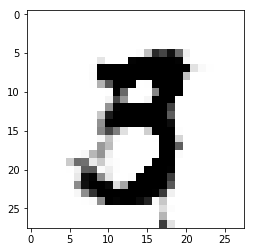

Estimate: [[-122.88716888]]
Iteration: 85100 at 2017-07-03 02:39:03.566693


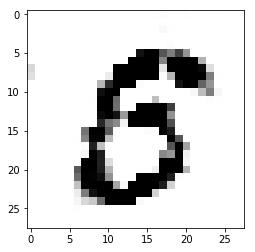

Estimate: [[-35.1717453]]
Iteration: 85200 at 2017-07-03 02:39:14.516790


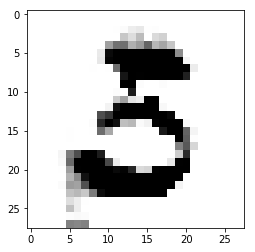

Estimate: [[ 88.35626984]]
Iteration: 85300 at 2017-07-03 02:39:25.371361


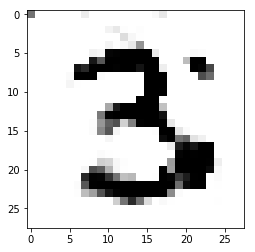

Estimate: [[ 61.58808517]]
Iteration: 85400 at 2017-07-03 02:39:36.237649


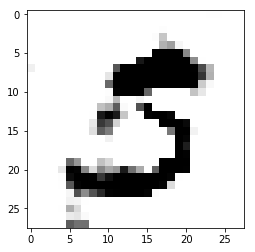

Estimate: [[-42.91287994]]
Iteration: 85500 at 2017-07-03 02:39:47.107520


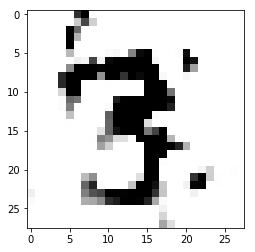

Estimate: [[-3.67347503]]
Iteration: 85600 at 2017-07-03 02:39:57.963737


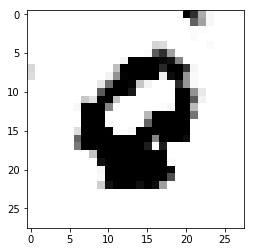

Estimate: [[ 201.45497131]]
Iteration: 85700 at 2017-07-03 02:40:08.982819


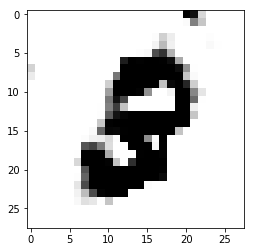

Estimate: [[ 6.50185537]]
Iteration: 85800 at 2017-07-03 02:40:19.934378


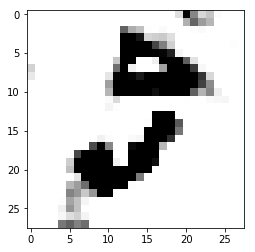

Estimate: [[ 162.24992371]]
Iteration: 85900 at 2017-07-03 02:40:30.832890


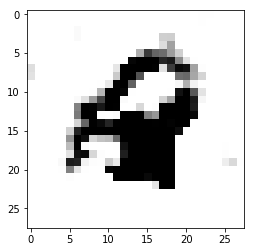

Estimate: [[ 85.70189667]]
Iteration: 86000 at 2017-07-03 02:40:41.786804


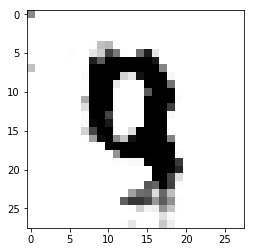

Estimate: [[ 212.74220276]]
Iteration: 86100 at 2017-07-03 02:40:52.708581


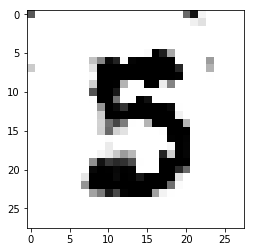

Estimate: [[-41.46294403]]
Iteration: 86200 at 2017-07-03 02:41:03.780697


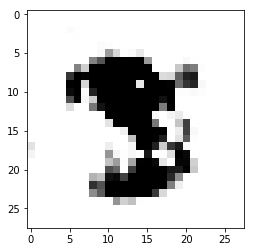

Estimate: [[-363.36392212]]
Iteration: 86300 at 2017-07-03 02:41:14.564246


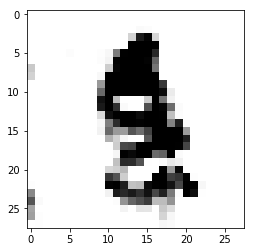

Estimate: [[-157.81761169]]
Iteration: 86400 at 2017-07-03 02:41:25.381727


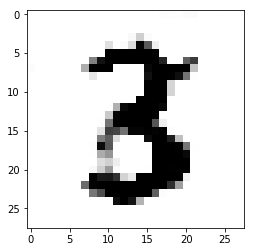

Estimate: [[ 50.71547318]]
Iteration: 86500 at 2017-07-03 02:41:36.285350


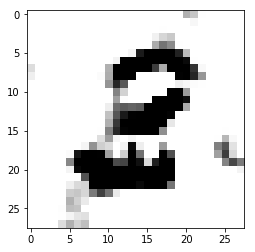

Estimate: [[-2.05364084]]
Iteration: 86600 at 2017-07-03 02:41:47.130976


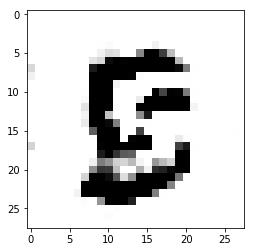

Estimate: [[-112.03888702]]
Iteration: 86700 at 2017-07-03 02:41:58.157520


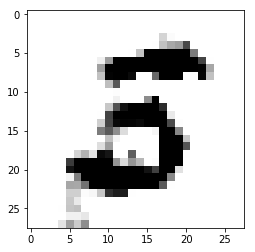

Estimate: [[-45.35866165]]
Iteration: 86800 at 2017-07-03 02:42:09.092234


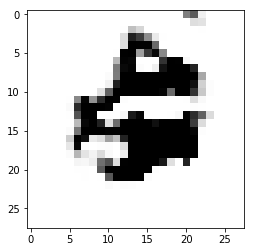

Estimate: [[ 130.56382751]]
Iteration: 86900 at 2017-07-03 02:42:20.027792


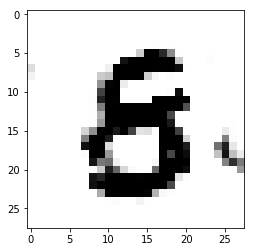

Estimate: [[-44.83420563]]
Iteration: 87000 at 2017-07-03 02:42:30.926676


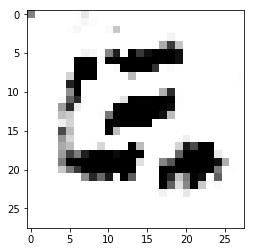

Estimate: [[-63.27014542]]
Iteration: 87100 at 2017-07-03 02:42:41.825120


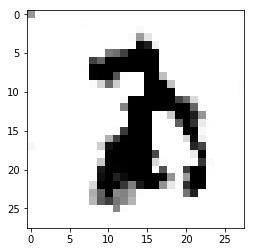

Estimate: [[ 56.70439529]]
Iteration: 87200 at 2017-07-03 02:42:52.804089


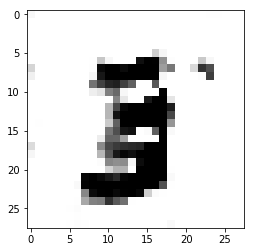

Estimate: [[-99.32070923]]
Iteration: 87300 at 2017-07-03 02:43:03.744527


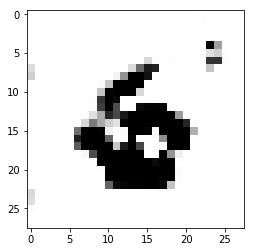

Estimate: [[ 141.19696045]]
Iteration: 87400 at 2017-07-03 02:43:14.573349


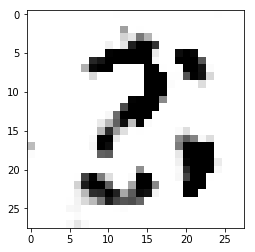

Estimate: [[ 17.15979958]]
Iteration: 87500 at 2017-07-03 02:43:25.436753


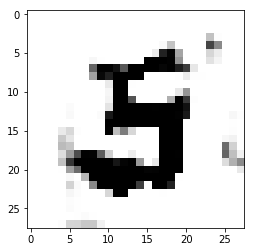

Estimate: [[-183.82667542]]
Iteration: 87600 at 2017-07-03 02:43:36.357484


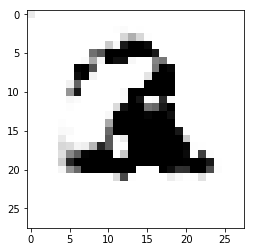

Estimate: [[-46.28639603]]
Iteration: 87700 at 2017-07-03 02:43:47.412841


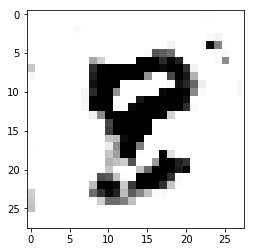

Estimate: [[ 137.12918091]]
Iteration: 87800 at 2017-07-03 02:43:58.325609


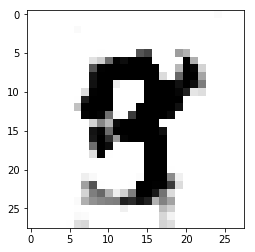

Estimate: [[ 99.61360931]]
Iteration: 87900 at 2017-07-03 02:44:09.213997


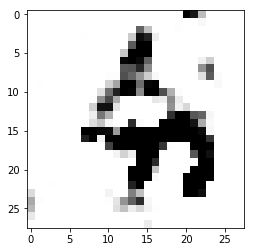

Estimate: [[-50.98691177]]
Iteration: 88000 at 2017-07-03 02:44:20.324613


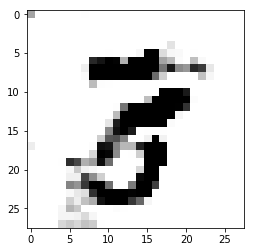

Estimate: [[-27.00327873]]
Iteration: 88100 at 2017-07-03 02:44:31.182857


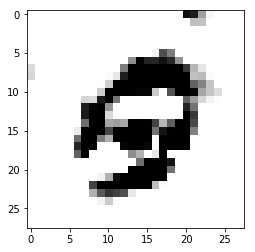

Estimate: [[-128.24897766]]
Iteration: 88200 at 2017-07-03 02:44:42.148577


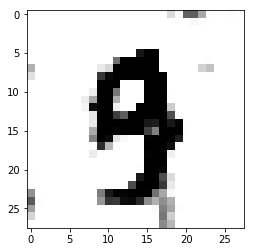

Estimate: [[-16.79501152]]
Iteration: 88300 at 2017-07-03 02:44:53.074268


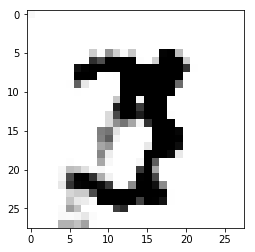

Estimate: [[-56.95855713]]
Iteration: 88400 at 2017-07-03 02:45:04.139099


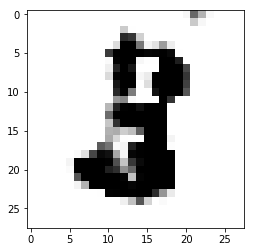

Estimate: [[-17.75322342]]
Iteration: 88500 at 2017-07-03 02:45:15.155437


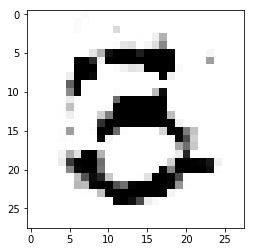

Estimate: [[-29.23199463]]
Iteration: 88600 at 2017-07-03 02:45:26.062516


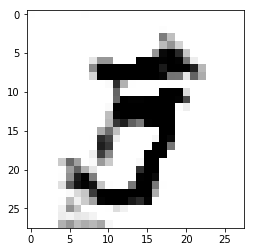

Estimate: [[ 2.28131461]]
Iteration: 88700 at 2017-07-03 02:45:37.123827


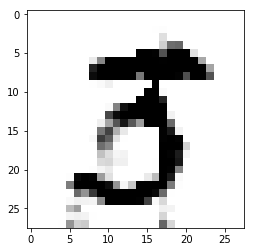

Estimate: [[-84.95368958]]
Iteration: 88800 at 2017-07-03 02:45:48.046797


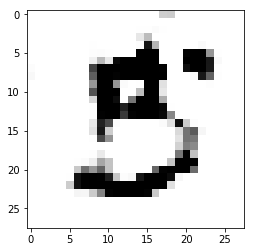

Estimate: [[ 3.05241752]]
Iteration: 88900 at 2017-07-03 02:45:58.960404


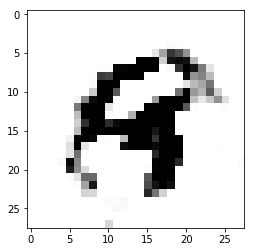

Estimate: [[ 4.20836782]]
Iteration: 89000 at 2017-07-03 02:46:11.808620


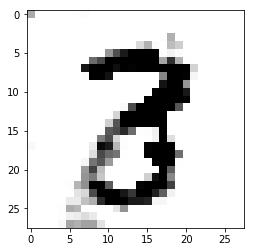

Estimate: [[-79.54711914]]
Iteration: 89100 at 2017-07-03 02:46:23.039034


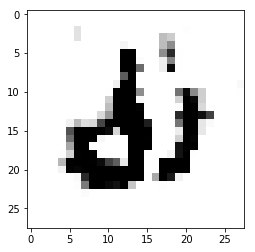

Estimate: [[-66.17679596]]
Iteration: 89200 at 2017-07-03 02:46:34.058218


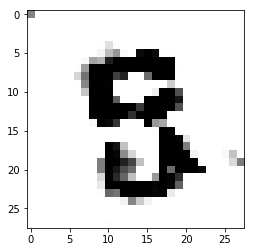

Estimate: [[-37.71741867]]
Iteration: 89300 at 2017-07-03 02:46:45.029743


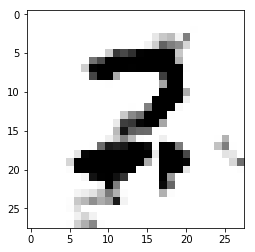

Estimate: [[ 122.59043121]]
Iteration: 89400 at 2017-07-03 02:46:56.043088


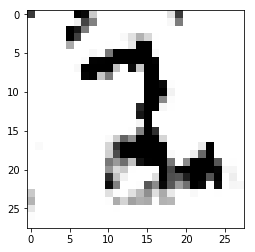

Estimate: [[ 16.12537384]]
Iteration: 89500 at 2017-07-03 02:47:07.132609


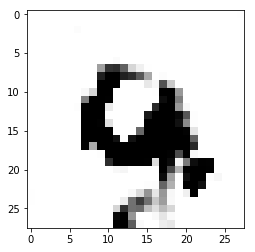

Estimate: [[-11.78573704]]
Iteration: 89600 at 2017-07-03 02:47:18.320660


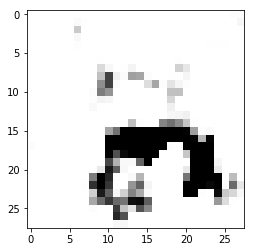

Estimate: [[ 336.2673645]]
Iteration: 89700 at 2017-07-03 02:47:29.311773


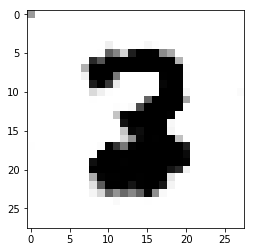

Estimate: [[-165.29154968]]
Iteration: 89800 at 2017-07-03 02:47:40.295750


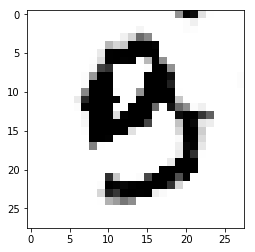

Estimate: [[-12.27764606]]
Iteration: 89900 at 2017-07-03 02:47:51.296200


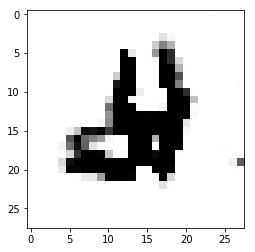

Estimate: [[ 58.86220932]]
Iteration: 90000 at 2017-07-03 02:48:02.267036


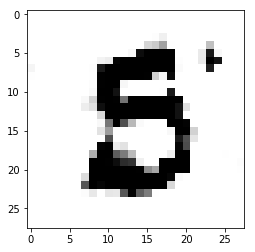

Estimate: [[-72.7219162]]
Iteration: 90100 at 2017-07-03 02:48:13.501919


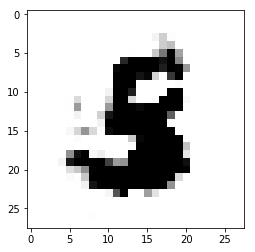

Estimate: [[-22.9276886]]
Iteration: 90200 at 2017-07-03 02:48:24.630633


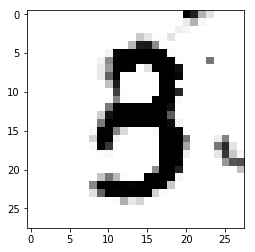

Estimate: [[ 12.81912136]]
Iteration: 90300 at 2017-07-03 02:48:35.730677


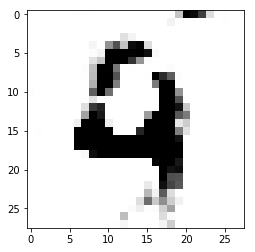

Estimate: [[-14.12129402]]
Iteration: 90400 at 2017-07-03 02:48:46.868489


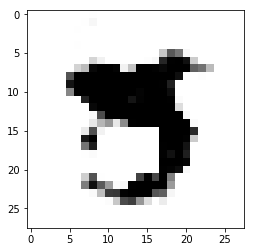

Estimate: [[-27.732687]]
Iteration: 90500 at 2017-07-03 02:48:58.002538


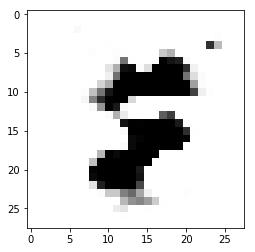

Estimate: [[ 140.07107544]]
Iteration: 90600 at 2017-07-03 02:49:09.174573


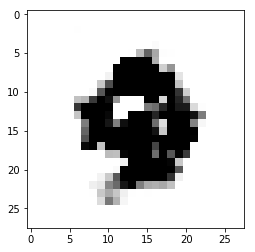

Estimate: [[-20.98626137]]
Iteration: 90700 at 2017-07-03 02:49:20.232278


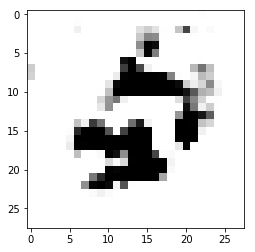

Estimate: [[-116.61003876]]
Iteration: 90800 at 2017-07-03 02:49:31.337800


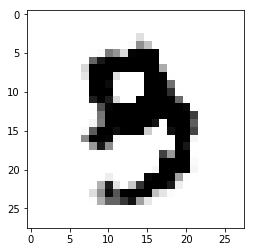

Estimate: [[ 61.58839035]]
Iteration: 90900 at 2017-07-03 02:49:42.431030


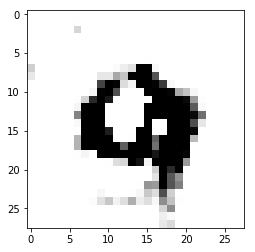

Estimate: [[ 70.45606995]]
Iteration: 91000 at 2017-07-03 02:49:53.669288


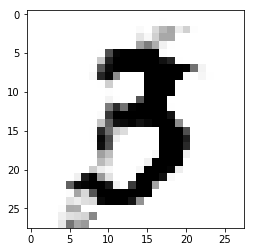

Estimate: [[-26.59193993]]
Iteration: 91100 at 2017-07-03 02:50:04.839193


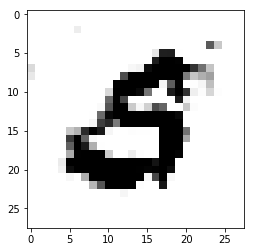

Estimate: [[ 51.56530762]]
Iteration: 91200 at 2017-07-03 02:50:15.962476


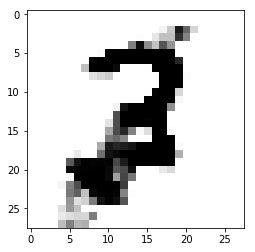

Estimate: [[ 101.51334381]]
Iteration: 91300 at 2017-07-03 02:50:26.989629


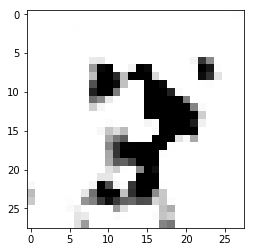

Estimate: [[ 140.04025269]]
Iteration: 91400 at 2017-07-03 02:50:38.214083


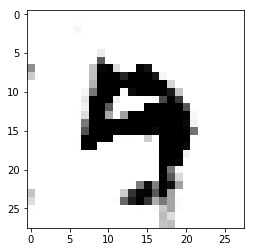

Estimate: [[ 172.05270386]]
Iteration: 91500 at 2017-07-03 02:50:49.364360


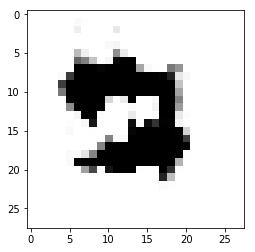

Estimate: [[-168.58532715]]
Iteration: 91600 at 2017-07-03 02:51:00.484280


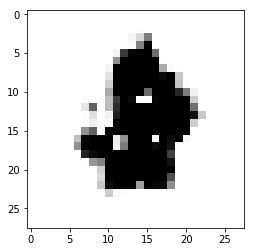

Estimate: [[-119.67414093]]
Iteration: 91700 at 2017-07-03 02:51:11.665693


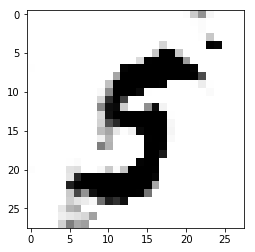

Estimate: [[ 4.27358913]]
Iteration: 91800 at 2017-07-03 02:51:22.788185


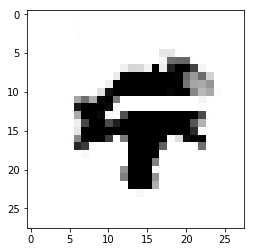

Estimate: [[ 26.33898163]]
Iteration: 91900 at 2017-07-03 02:51:34.076574


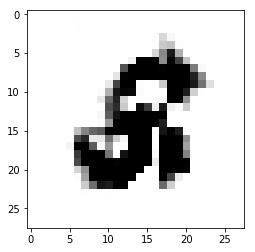

Estimate: [[ 9.57407761]]
Iteration: 92000 at 2017-07-03 02:51:45.237536


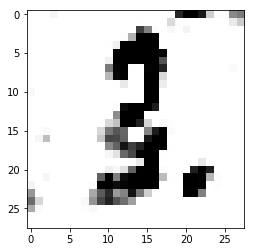

Estimate: [[-135.15362549]]
Iteration: 92100 at 2017-07-03 02:51:56.442249


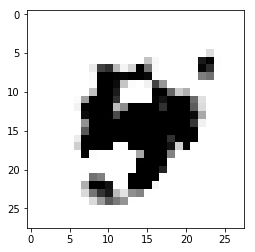

Estimate: [[-18.62724876]]
Iteration: 92200 at 2017-07-03 02:52:07.600664


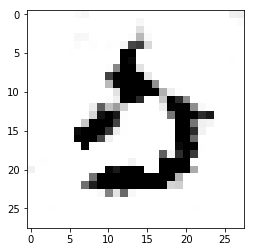

Estimate: [[-138.7383728]]
Iteration: 92300 at 2017-07-03 02:52:18.794557


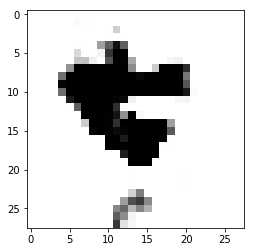

Estimate: [[ 541.15264893]]
Iteration: 92400 at 2017-07-03 02:52:30.004110


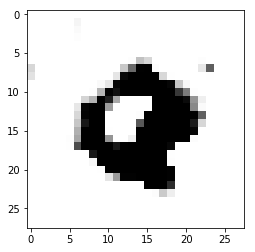

Estimate: [[ 118.27859497]]
Iteration: 92500 at 2017-07-03 02:52:41.149199


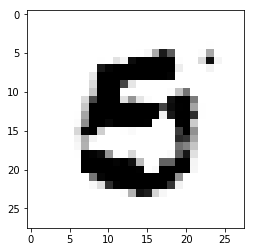

Estimate: [[ 92.22871399]]
Iteration: 92600 at 2017-07-03 02:52:52.354716


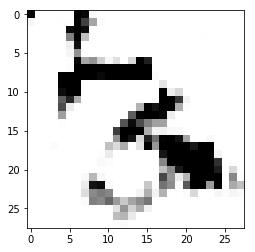

Estimate: [[ 127.05754089]]
Iteration: 92700 at 2017-07-03 02:53:03.529068


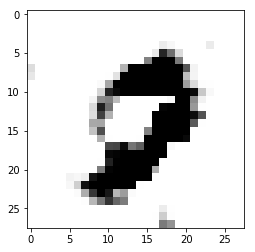

Estimate: [[ 154.7913208]]
Iteration: 92800 at 2017-07-03 02:53:14.883695


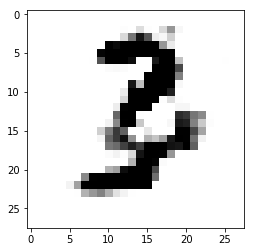

Estimate: [[ 125.5247879]]
Iteration: 92900 at 2017-07-03 02:53:26.052212


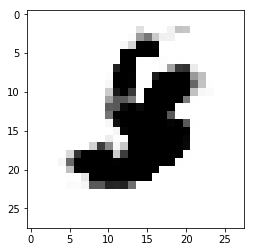

Estimate: [[ 206.43132019]]
Iteration: 93000 at 2017-07-03 02:53:37.258533


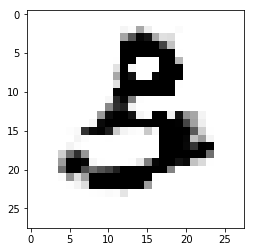

Estimate: [[ 19.18908882]]
Iteration: 93100 at 2017-07-03 02:53:48.461611


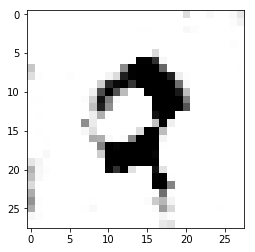

Estimate: [[-122.63769531]]
Iteration: 93200 at 2017-07-03 02:53:59.875994


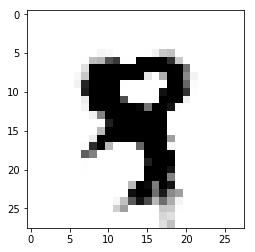

Estimate: [[-45.31350708]]
Iteration: 93300 at 2017-07-03 02:54:11.117581


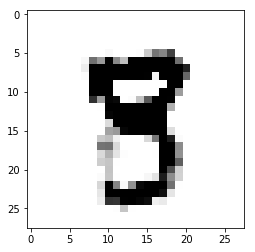

Estimate: [[-29.53344727]]
Iteration: 93400 at 2017-07-03 02:54:22.360757


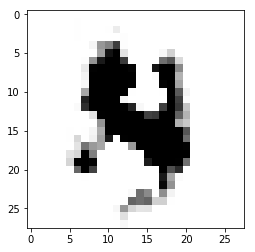

Estimate: [[-94.27170563]]
Iteration: 93500 at 2017-07-03 02:54:33.585028


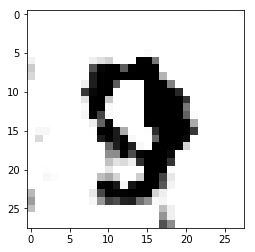

Estimate: [[ 48.15533829]]
Iteration: 93600 at 2017-07-03 02:54:44.979157


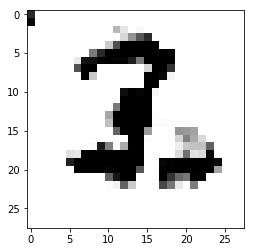

Estimate: [[ 70.04417419]]
Iteration: 93700 at 2017-07-03 02:54:56.212944


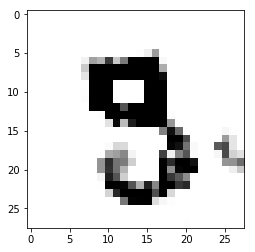

Estimate: [[ 157.39413452]]
Iteration: 93800 at 2017-07-03 02:55:07.443650


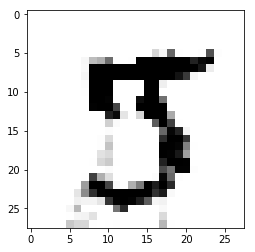

Estimate: [[ 13.40497398]]
Iteration: 93900 at 2017-07-03 02:55:18.706027


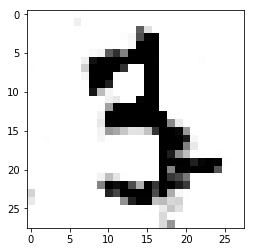

Estimate: [[-42.84261703]]
Iteration: 94000 at 2017-07-03 02:55:30.035955


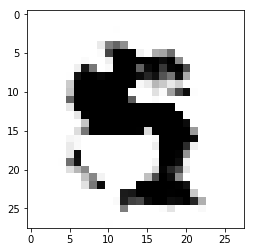

Estimate: [[-112.81297302]]
Iteration: 94100 at 2017-07-03 02:55:41.292806


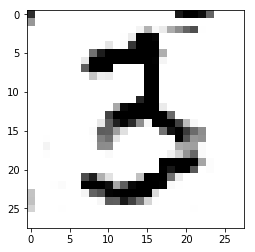

Estimate: [[ 172.96615601]]
Iteration: 94200 at 2017-07-03 02:55:52.458767


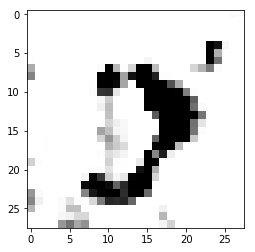

Estimate: [[-45.77573395]]
Iteration: 94300 at 2017-07-03 02:56:03.733936


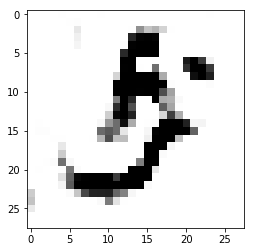

Estimate: [[-19.13026047]]
Iteration: 94400 at 2017-07-03 02:56:15.243618


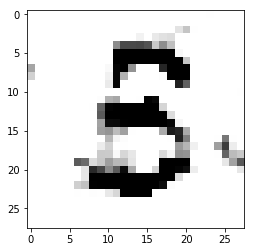

Estimate: [[-55.83607864]]
Iteration: 94500 at 2017-07-03 02:56:26.474655


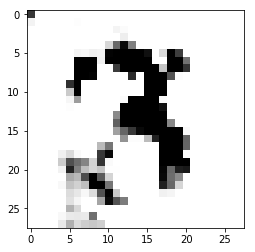

Estimate: [[-77.45763397]]
Iteration: 94600 at 2017-07-03 02:56:37.673715


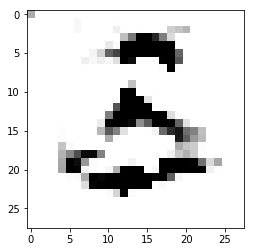

Estimate: [[ 5.18254137]]
Iteration: 94700 at 2017-07-03 02:56:48.991116


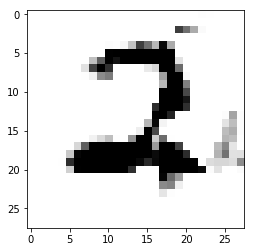

Estimate: [[ 435.62405396]]
Iteration: 94800 at 2017-07-03 02:57:00.418262


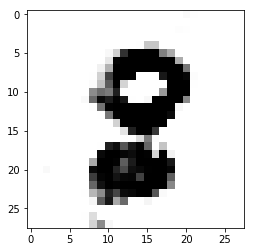

Estimate: [[ 2.59069157]]
Iteration: 94900 at 2017-07-03 02:57:11.753348


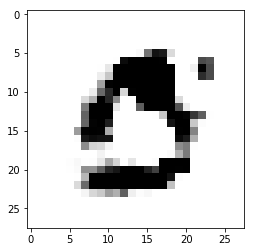

Estimate: [[ 66.79443359]]
Iteration: 95000 at 2017-07-03 02:57:23.179339


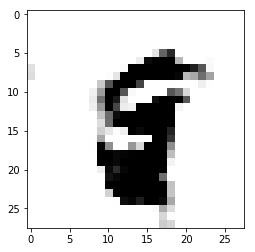

Estimate: [[ 71.48941803]]
Iteration: 95100 at 2017-07-03 02:57:34.484267


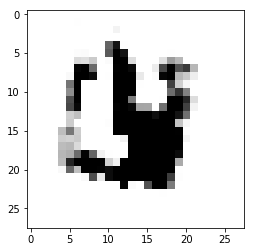

Estimate: [[ 11.03789425]]
Iteration: 95200 at 2017-07-03 02:57:45.956428


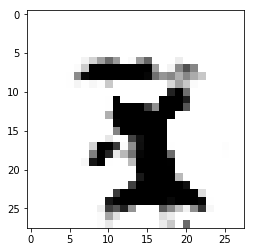

Estimate: [[ 3.38305736]]
Iteration: 95300 at 2017-07-03 02:57:57.256935


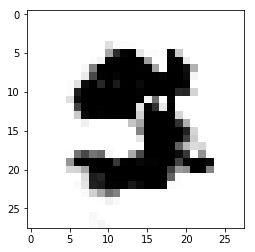

Estimate: [[-173.64126587]]
Iteration: 95400 at 2017-07-03 02:58:08.617323


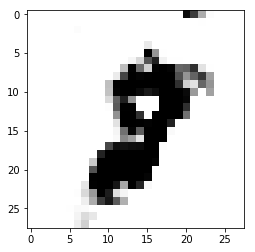

Estimate: [[ 20.52000046]]
Iteration: 95500 at 2017-07-03 02:58:19.976244


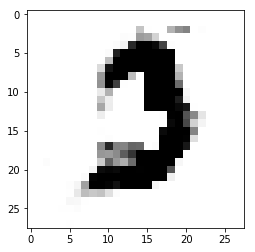

Estimate: [[ 208.16581726]]
Iteration: 95600 at 2017-07-03 02:58:31.451876


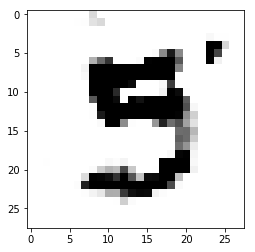

Estimate: [[-135.75093079]]
Iteration: 95700 at 2017-07-03 02:58:42.782066


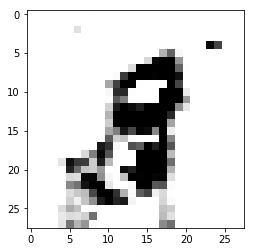

Estimate: [[-169.79232788]]
Iteration: 95800 at 2017-07-03 02:58:54.164656


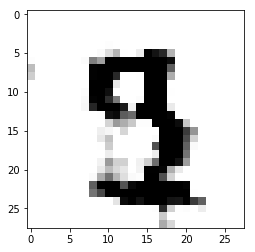

Estimate: [[-122.48796844]]
Iteration: 95900 at 2017-07-03 02:59:05.591624


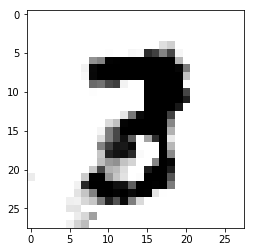

Estimate: [[ 15.32903957]]
Iteration: 96000 at 2017-07-03 02:59:16.956538


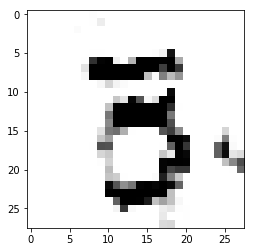

Estimate: [[ 35.74092484]]
Iteration: 96100 at 2017-07-03 02:59:28.356961


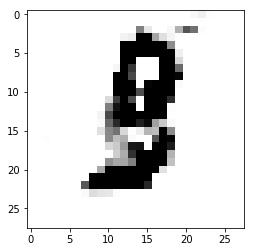

Estimate: [[ 111.55511475]]
Iteration: 96200 at 2017-07-03 02:59:39.662611


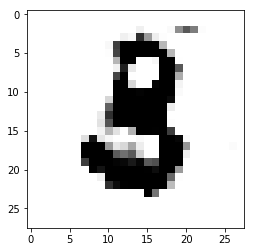

Estimate: [[-76.94486237]]
Iteration: 96300 at 2017-07-03 02:59:50.971809


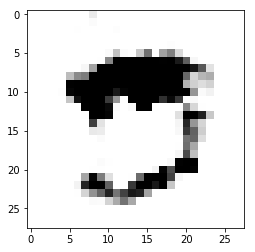

Estimate: [[ 289.21105957]]
Iteration: 96400 at 2017-07-03 03:00:02.423018


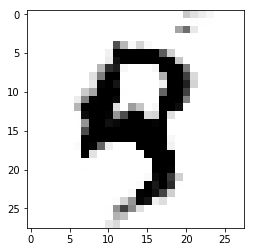

Estimate: [[ 154.54248047]]
Iteration: 96500 at 2017-07-03 03:00:13.933193


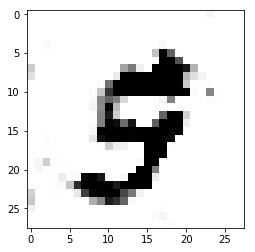

Estimate: [[-88.44212341]]
Iteration: 96600 at 2017-07-03 03:00:25.312391


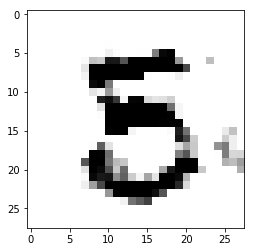

Estimate: [[-5.29476881]]
Iteration: 96700 at 2017-07-03 03:00:36.723332


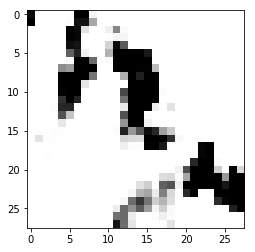

Estimate: [[ 414.34109497]]
Iteration: 96800 at 2017-07-03 03:00:48.247077


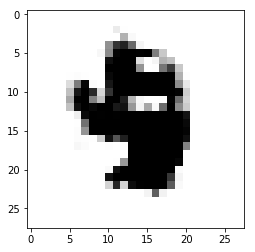

Estimate: [[ 11.44943905]]
Iteration: 96900 at 2017-07-03 03:00:59.686495


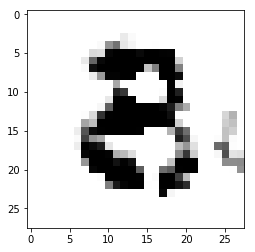

Estimate: [[ 135.8813324]]
Iteration: 97000 at 2017-07-03 03:01:11.102007


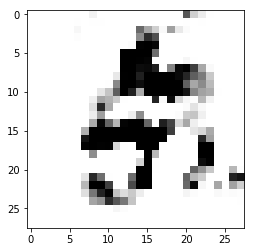

Estimate: [[-201.04745483]]
Iteration: 97100 at 2017-07-03 03:01:22.504309


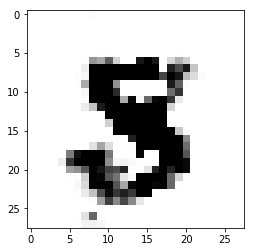

Estimate: [[-35.73957443]]
Iteration: 97200 at 2017-07-03 03:01:34.134837


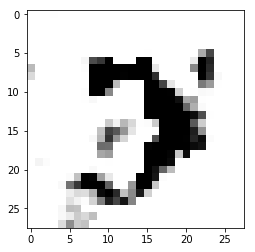

Estimate: [[ 168.03225708]]
Iteration: 97300 at 2017-07-03 03:01:45.584158


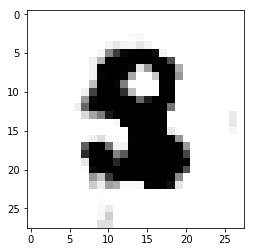

Estimate: [[ 67.40813446]]
Iteration: 97400 at 2017-07-03 03:01:56.944504


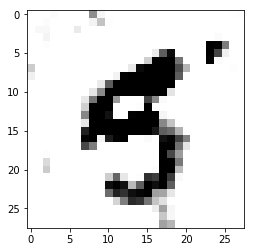

Estimate: [[ 66.12017059]]
Iteration: 97500 at 2017-07-03 03:02:08.371179


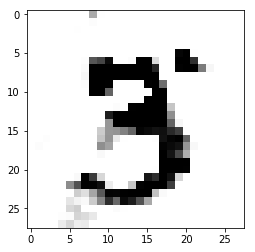

Estimate: [[ 32.20137024]]
Iteration: 97600 at 2017-07-03 03:02:21.092626


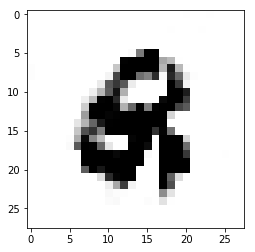

Estimate: [[ 35.96471786]]
Iteration: 97700 at 2017-07-03 03:02:32.629458


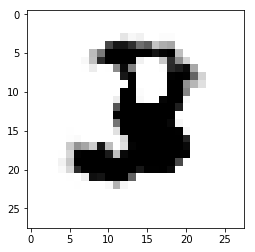

Estimate: [[ 64.32327271]]
Iteration: 97800 at 2017-07-03 03:02:44.058881


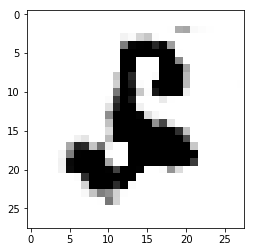

Estimate: [[ 42.87923813]]
Iteration: 97900 at 2017-07-03 03:02:55.480226


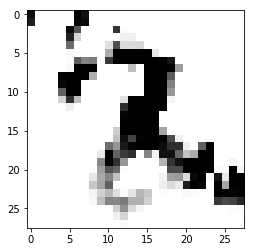

Estimate: [[ 79.78888702]]
Iteration: 98000 at 2017-07-03 03:03:07.030150


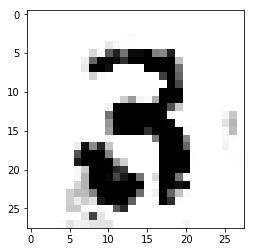

Estimate: [[-135.11505127]]
Iteration: 98100 at 2017-07-03 03:03:18.436296


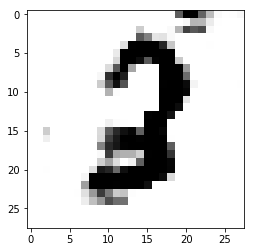

Estimate: [[ 145.34095764]]
Iteration: 98200 at 2017-07-03 03:03:29.927604


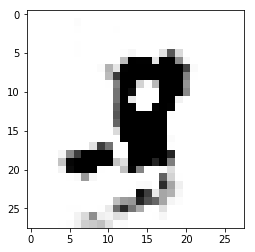

Estimate: [[-114.29612732]]
Iteration: 98300 at 2017-07-03 03:03:41.457493


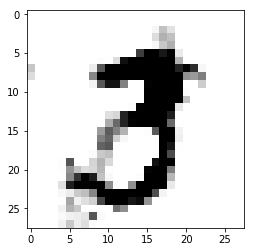

Estimate: [[ 50.24998474]]
Iteration: 98400 at 2017-07-03 03:03:53.052864


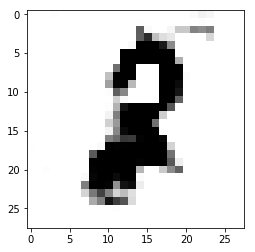

Estimate: [[-82.33475494]]
Iteration: 98500 at 2017-07-03 03:04:04.508475


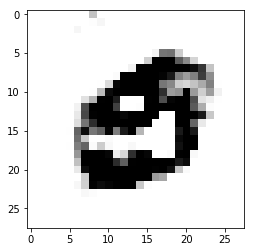

Estimate: [[ 203.94615173]]
Iteration: 98600 at 2017-07-03 03:04:16.060605


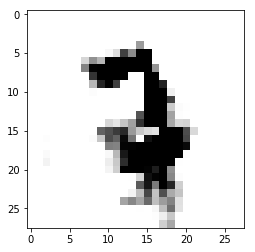

Estimate: [[ 55.11883163]]
Iteration: 98700 at 2017-07-03 03:04:27.576352


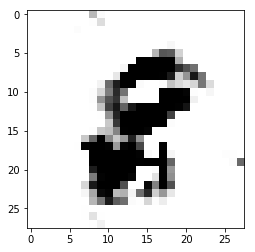

Estimate: [[ 93.74311066]]
Iteration: 98800 at 2017-07-03 03:04:39.140815


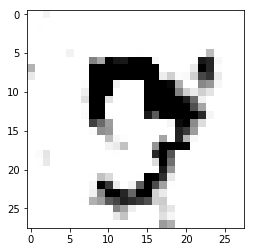

Estimate: [[ 140.7288208]]
Iteration: 98900 at 2017-07-03 03:04:50.620415


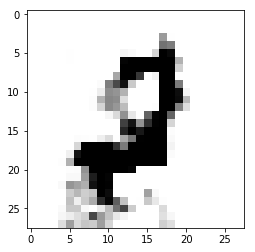

Estimate: [[ 33.53614807]]
Iteration: 99000 at 2017-07-03 03:05:02.041163


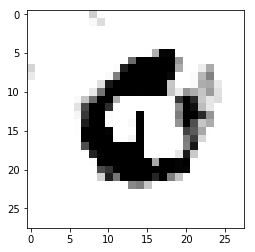

Estimate: [[-48.15920258]]
Iteration: 99100 at 2017-07-03 03:05:13.525640


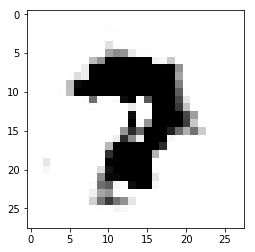

Estimate: [[ 15.33477592]]
Iteration: 99200 at 2017-07-03 03:05:25.119011


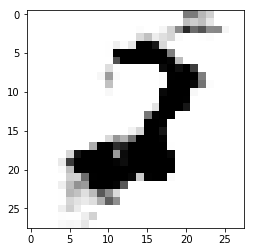

Estimate: [[ 63.34928131]]
Iteration: 99300 at 2017-07-03 03:05:36.584538


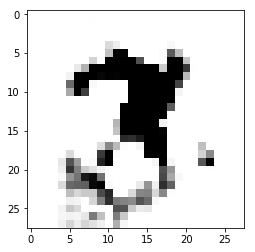

Estimate: [[ 134.16410828]]
Iteration: 99400 at 2017-07-03 03:05:48.188125


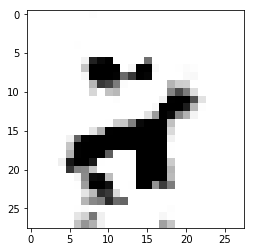

Estimate: [[-44.15329361]]
Iteration: 99500 at 2017-07-03 03:05:59.939619


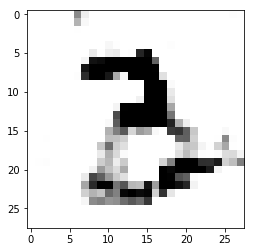

Estimate: [[-0.53397882]]
Iteration: 99600 at 2017-07-03 03:06:11.677209


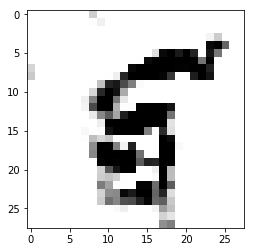

Estimate: [[ 172.28448486]]
Iteration: 99700 at 2017-07-03 03:06:23.219799


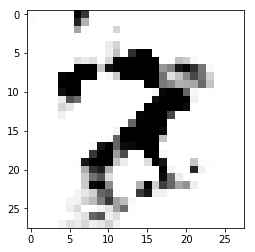

Estimate: [[-121.39639282]]
Iteration: 99800 at 2017-07-03 03:06:34.816708


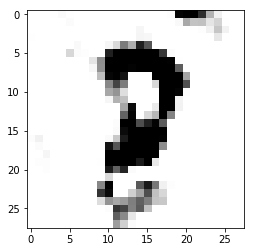

Estimate: [[ 95.45017242]]
Iteration: 99900 at 2017-07-03 03:06:46.401482


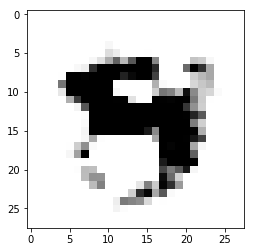

Estimate: [[-153.0168457]]


In [ ]:


sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        scipy.misc.imsave(
            "images/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+".png", 
            images[0].reshape([28, 28])
        )
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)

In [22]:
saver = tf.train.Saver()
saver.save(sess, 'mnist-gan-model', global_step=100000)

'mnist-gan-model-100000'